In [3]:
import os
import shap
import sys
sys.path.append('./pyuid3')
#sys.path.append('./EXPLAN/LORE')
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
import random



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from sklearn.svm import SVC

import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [5]:
def generate_phantom_data(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [6]:
def decision_boundary(clf1, explain_instance, X,y,f1='x1',f2='x2', dec_only=True, ax=None, palette='Set2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig,ax= plt.subplots(figsize=(9,4))

    
    ax.contour(xx, yy, Z, cmap=palette)
    if not dec_only:
        X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap=palette,ax=ax)

    
    ax.plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)

    ax.set(title='DecTree decision boundary')
 

In [7]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired


def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Example of local concept building (inverse sampling, density sampling prevents from building overcomplicated trees)
Local is not local at all -- the concept may be local, but its building could require a reach-out away from the locality,
On the outher hand, locality should not be considered in a global setting, becasue the simplicity migh be lost (dt covering unrelated concepts as additional branches) 
The selection of the samples to build local concepts to explain is crucial

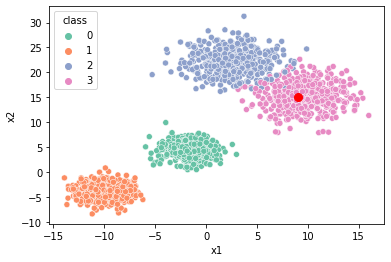

In [6]:
instance2explain = {'x1':9,'x2':15, 'class':3}
#instance2explain = {'x1':4,'x2':20, 'class':0}
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1,cluster_std=1.4)
X2,y2 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42,cluster_std=2.4)
X2[:,0]+=5
X2[:,1]+=13
X=np.concatenate((X,X2))
y= np.concatenate((y,y2+2))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')
graph.axes.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

### LORE neigh

In [7]:
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

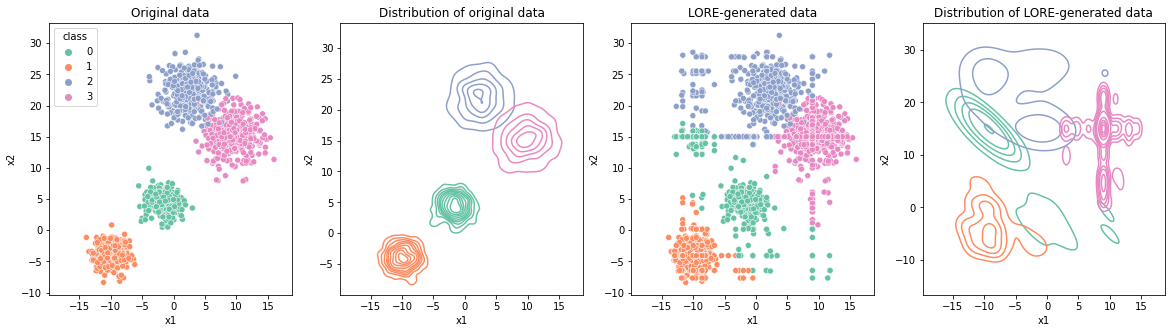

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('LORE-generated data')
axes[3].set_title('Distribution of LORE-generated data')
plt.savefig('./pix/lore-generated-data.pdf', format='pdf',bbox_inches='tight')

In [9]:
X_explain = np.concatenate((np.array(list(instance2explain.values()))[:-1].reshape(1,-1), dataset['X']))
exp_LORE, info_LORE = lore.explain(0, X_explain,
                                   dataset, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path='./EXPLAN/yadt/',
                                   sep=';', log=True, depth=10)

rule_LORE = {} 
for i,v in  exp_LORE[0][1].items():
    rule_LORE[i] = [v]


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1053\n + load time: 0.0082 secs (3.15 MiB/s, 128.41 K rows/s)\n + indexing ... done\n + total time: 0.011061 secs (2.33 MiB/s, 95.19 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) built\n + size: 39 depth: 8 nf: 2 time: 0.011573 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 2 time: 3.8e-05 secs\n'


In [10]:
exp_LORE

([{'class': 3},
  {'x1': '>1.630634', 'x2': '2.634089< x2 <=21.017595'},
  [532.0, 5.0]],
 [{'x2': '-20.244945< x2 <=2.634089'}])

### EXPLAN neigh

In [11]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

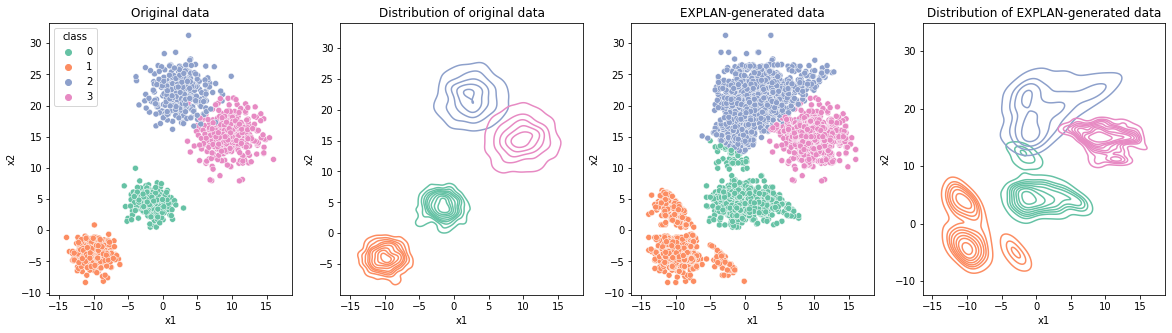

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('EXPLAN-generated data')
axes[3].set_title('Distribution of EXPLAN-generated data')
plt.savefig('./pix/explan-generated-data.pdf', format='pdf',bbox_inches='tight')

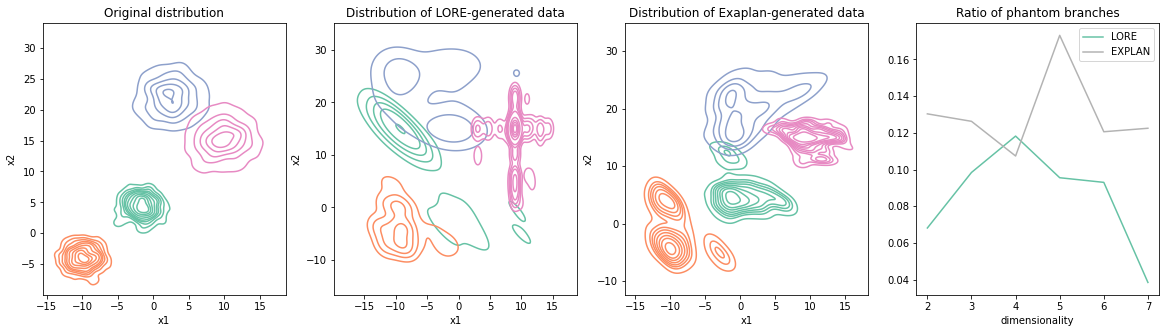

In [13]:
sdf = pd.read_csv('phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
#sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan']].mean().plot(ax=axes[3], cmap='Set2')
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
axes[3].set_title('Ratio of phantom branches')
axes[3].legend(['LORE','EXPLAN'])
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

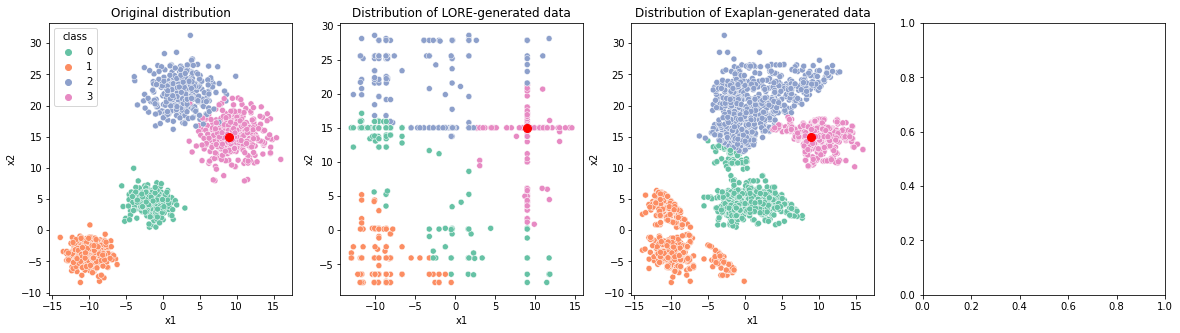

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
#sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
#sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)

instance2explain = {'x1':9,'x2':15, 'class':3}
axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

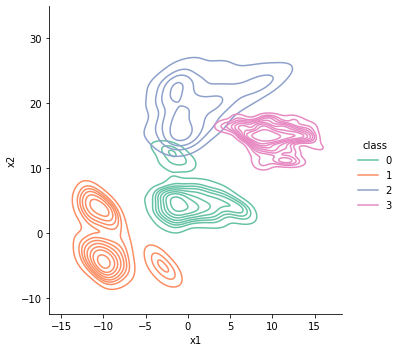

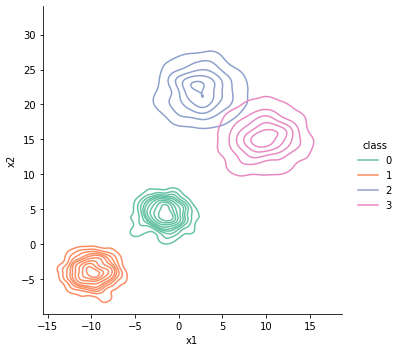

In [15]:
sns.displot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

In [16]:
exp_EXPLAN, info_EXPLAN = explan.Explainer(np.array(list(instance2explain.values()))[:-1],
                                               blackbox,
                                               dataset,
                                               N_samples=3000,
                                               tau=200,depth=10)
rule_EXPLAN = {} 
for i,v in  exp_EXPLAN[1].items():
    rule_EXPLAN[i] = [v]

exp_EXPLAN

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1512\n + load time: 0.006731 secs (8.22 MiB/s, 224.63 K rows/s)\n + indexing ... done\n + total time: 0.010144 secs (5.45 MiB/s, 149.05 K rows/s)\nBuilding 1 tree(s) on 1512 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 2 time: 0.011977 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 2 time: 0.00015 secs\n'


[{'class': 3},
 {'x2': '8.07974< x2 <=18.53518', 'x1': '>6.805250'},
 [358.0, 1.3]]

### LUX neigh

In [17]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=False, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=False,
                                         representative='centroid')


(-15.400336008034298, 17.480904720359618)

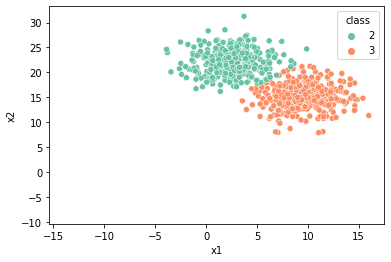

In [18]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette='Set2')
graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

In [19]:
lux.fit(train[features], train[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=False, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=False,prune=True,
                                         representative='centroid')


In [20]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x1 >= 6.3010738258457835 AND x2 < 21.034608247661986 THEN class = 3 # 0.9764487016609265\n'

## Example of Greedy algorithm vs SHAP-powered tree (shap-powered tree is less complicated)

In [21]:
#todo; the iris dataset the complexity as a number of features used
#does it improve the consistency with shap? it does not have to?

## Example of uncertainty incorporation in LUX (explaning why model made predictio when model is uncertain of its decision)

In [22]:
#the high precision rules and sampling around decision boundary

## Example of data generation  (true paterns visible in the data are hidden) -- NO DATA GENERATION, OR SMART GENERATION THAT DOES NOT CHANGE DISTRIBUTION

### LORE

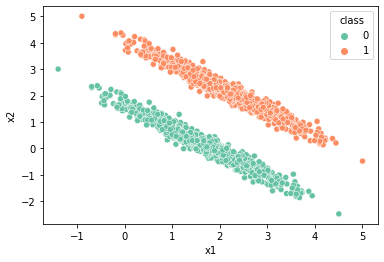

In [23]:
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')

In [24]:

instance2explain = {'x1':1.5,'x2':-0.5, 'class':0}
instance2explain = {'x1':0,'x2':1.5, 'class':0}
#instance2explain = {'x1':0,'x2':1, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

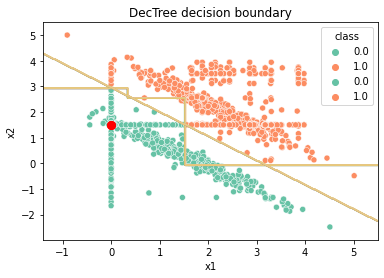

In [25]:
depth = 4
exclf = DecisionTreeClassifier(max_depth=depth)
exclf.fit(Zdf[features], Zdf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

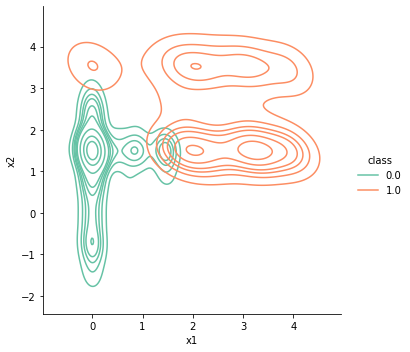

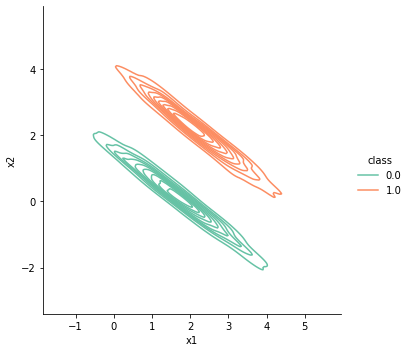

In [26]:
sns.displot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

In [27]:
# dtg = Source(tree.export_graphviz(exclf, out_file=None, feature_names=features, filled = True,max_depth=depth))
# display(SVG(dtg.pipe(format='svg')))

### Explan

In [28]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

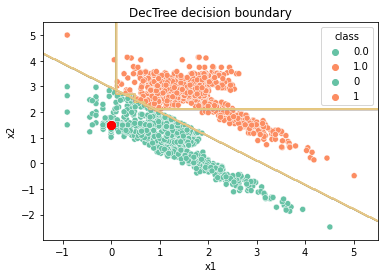

In [29]:
depth = 4
exclf = DecisionTreeClassifier(max_depth=depth)
exclf.fit(Ndf[features], Ndf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

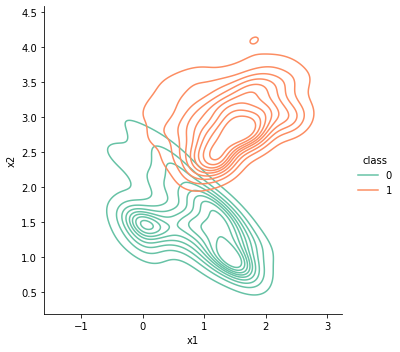

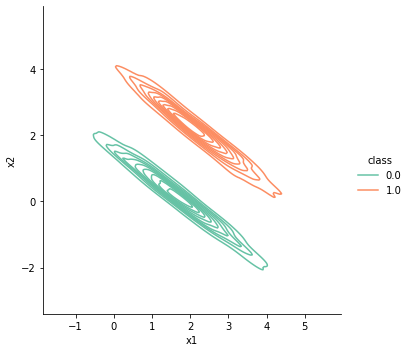

In [30]:
sns.displot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

### LUX

In [31]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

In [32]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

<AxesSubplot:xlabel='x1', ylabel='x2'>

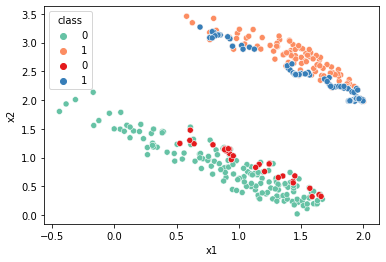

In [33]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', hue='class', palette='Set1',ax=graph.axes)

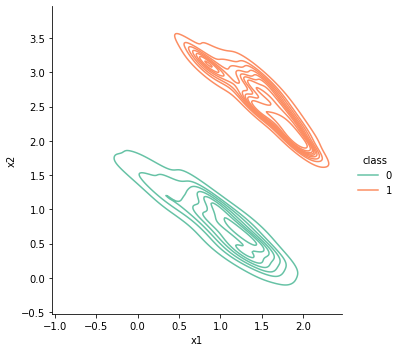

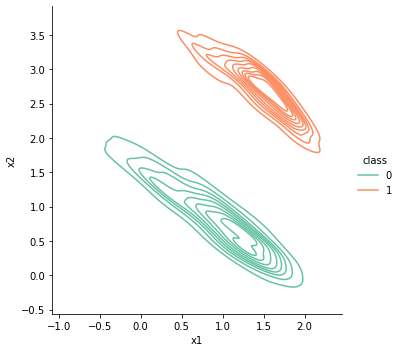

In [34]:
sns.displot(data=Zdf_lux,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=Zdf_lux_noos,x='x1',y='x2', hue='class', kind='kde', fill=False, palette='Set2')

### Lux on more complex example

In [35]:
X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf[target] = y
features = [f for f in Xdf.columns if f not in [target]]
train, test = train_test_split(Xdf, test_size=0.33, random_state=42)
blackbox = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
blackbox.fit(train[features], train[target])

RandomForestClassifier()

<AxesSubplot:xlabel='x1', ylabel='x2'>

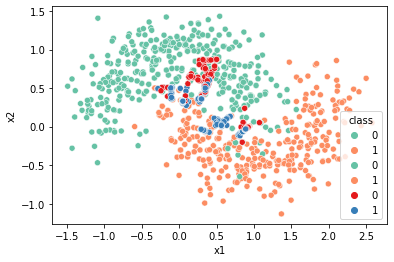

In [36]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', hue='class', palette='Set1',ax=graph.axes)

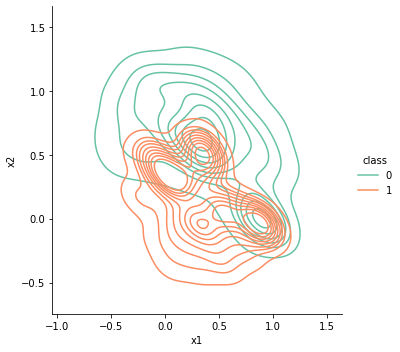

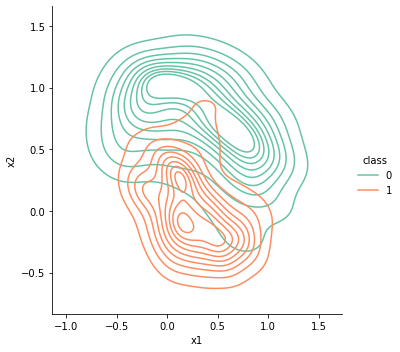

In [37]:
sns.displot(data=Zdf_lux,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=Zdf_lux_noos,x='x1',y='x2', hue='class', kind='kde', fill=False, palette='Set2')

## Branch utilisation (phantom branches)

In [ ]:
# generate neigh with lore, explan
# fit uid3, use counterfactual code genration on real data to see how it goes
def get_covered(rule, dataset, features, categorical=None):
    if categorical is None:
        categorical = [False]*len(features)
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical))[i] == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    return covered

def coverage_rules(tree, background_train, background_eval,features):
    rules  = tree.to_dict(reduce=True)

    #filter out rules with class same as not_class
    coever_rules = []
    mingen = None
    numfan = 0
    for rule in rules:
        coever_rules.append(rule)
        #find coverage points from background
        rule['covered'] = len(get_covered(rule['rule'],background_eval, features, None))/len(get_covered(rule['rule'],background_train, features, None))
        #find candidates from background according to counterfactual_representative
        if mingen is None or mingen > rule['covered']:
            mingen=rule['covered']
        if rule['covered'] == 0:
            numfan+=1
    return coever_rules,mingen,numfan,numfan/len(rules)

summary=[]
for f in range(2,20):
    for _ in range(1,20):
        if f > 4:
            f2=int(f/2)
            f3=int(f/3)
            f1=f
        else:
            f1=f2=2
            f3=1
            
        try:
            X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f1, #random_state=3,
                                                           n_informative=f2, n_redundant=0, n_repeated=0, n_clusters_per_class=f3,
                                                           n_classes=3)
            cols = [f'f_{i}' for i in range(0,X.shape[1])]
            Xdf = pd.DataFrame(X, columns=cols)
            Xdf['class'] = y

            target = 'class'
            features = [f for f in Xdf.columns if f not in [target]]
            train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

            blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
            blackbox.fit(train[features],train[target])
            categorical_indicator = [False]*len(features)

            #train.loc[len(train)] = instance2explain
            idx = random.randint(0, len(train))
            dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})


            Zdf,Z = generate_phantom_data(idx_record2explain=idx, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
                        ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                        discrete_use_probabilities=True,
                        continuous_function_estimation=True)



            i2e = train.iloc[idx][features].values
            dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
            # Representative data selection step
            representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = blackbox.predict(Ndf[features])


            lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, 
                      grow_confidence_threshold = 0, min_samples=10 )
            X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[idx][features].values],X_importances = None, 
                                                 exclude_neighbourhood=False, use_parity=True, 
                                                 inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=False, 
                                                 oversampling=True,
                                                 representative='centroid')

            #LORE
            data = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lore = len(uid3.tree.to_dict())
            crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)
            uid3.predict(test)
        

            #EXPLAN
            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_explan = len(uid3.tree.to_dict())
            crgen_ep,mg_ep,numfan_ep,prop_ep = coverage_rules(uid3.tree, Ndf, train,features=features)

            ##LUX
            X_train_sample_c = X_train_sample.copy()
            X_train_sample_c[target] = blackbox.predict(X_train_sample_c)
            data = Data.parse_dataframe(X_train_sample_c)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lux = len(uid3.tree.to_dict())
            crgreal,mr,numfanr,propr = coverage_rules(uid3.tree, X_train_sample_c, train,features=features)
            print(f'Num of features {f} Minimal coverage generated {mg}, minimal coverage real {mr}, proportion of phantom: {numfan}')
            summary.append([f,mg,mg_ep,mr,numfan,numfan_ep,numfanr,prop,prop_ep,propr,rnum_lore, rnum_explan, rnum_lux])
        except:
            pass
        
    

In [ ]:

sdf = pd.DataFrame(summary, columns=['dimensionality','min_cov_lore','min_cov_explan','min_cov_lux','phantom_no_lore','phantom_no_explan',
                                     'phantom_no_lux','phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux',
                                     'rules_lore','rules_explan','rules_lux'])
sdf.to_csv('phantoms.csv',index=False)

In [ ]:
sdf = pd.read_csv('phantoms.csv')

In [ ]:
sdf.groupby('dimensionality')[['phantom_no_lore','phantom_no_explan','phantom_no_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[[ 'rules_lore','rules_explan','rules_lux']].mean().plot()

## Example of oblique necessity (lineary decbound in DT is counterintuitive fro experts) -- DT DOES NOT ALWAYS CAPTURES WHAT MODEL TRIES TO CAPTURE

## Need for visualization of explanations throuhg the lenses of DS (explanation should be backed by data distribution, otherwise it is missing important informaiton)

## Tradeoff between locla/global by selecting the fraction

# Stability among same instance

In [44]:
f=8
X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f, random_state=3,
                                                       n_informative=int(f/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(f/3),
                                                       n_classes=2)
cols = [f'f_{i}' for i in range(0,X.shape[1])]
Xdf = pd.DataFrame(X, columns=cols)
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain


SVC(kernel='linear', probability=True)

In [45]:
idx = 10
i2e = train.iloc[idx][features].values
dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})

In [ ]:

rules_temp=[]
stab_stats=[]
stability_data=[]
# EXPLAN hyper-parameters
N_samples = 3000#n_neighbors
tau = 250#int(n_neighbors)/len(np.unique(df[target])


for ff in range(4, 6):

    X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=ff, random_state=3,
                                                           n_informative=int(ff/2), n_redundant=0, n_repeated=0,
                                              clusters_per_class=int(ff/3),
                                                           n_classes=2)
    cols = [f'f_{i}' for i in range(0,X.shape[1])]
    Xdf = pd.DataFrame(X, columns=cols)
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

    blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
    blackbox.fit(train[features],train[target])

    #train.loc[len(train)] = instance2explain
    idx = 10
    i2e = train.iloc[idx][features].values
    dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})


    pos_label = blackbox.predict(np.array(i2e).reshape(1,-1))[0]
    for _ in range(0,2):
        # Explaining instance x using EXPLAN
        exp_EXPLAN, info_EXPLAN = explan.Explainer(i2e,
                                                   blackbox,
                                                   dataset,
                                                   N_samples=N_samples,
                                                   tau=tau,depth=depth)
        rule_EXPLAN = {} 
        for i,v in  exp_EXPLAN[1].items():
            rule_EXPLAN[i] = [v]

        rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
        #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}

        cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, 
                                                                                        [False]*len(features), exp_EXPLAN[0][dataset['class_name']], 
                                                                                        class_label='class')


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% LORE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
        exp_LORE, info_LORE = lore.explain(0, X_explain,
                                           dataset, blackbox,
                                           ng_function=genetic_neighborhood,
                                           discrete_use_probabilities=True,
                                           continuous_function_estimation=False,
                                           returns_infos=True, path='./EXPLAN/yadt/',
                                           sep=';', log=True, depth=depth)

        rule_LORE = {} 
        for i,v in  exp_LORE[0][1].items():
            rule_LORE[i] = [v]

        rule_LORE = split_rule_conditions(rule_LORE)

        cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, [False]*len(features), 
                                                                              exp_LORE[0][0][dataset['class_name']], class_label='class')


        ############################ ANCHOR ######################################
        X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
        anchor_explainer = fit_anchor(dataset, train[features].values, train[features].values, train[target].values, train[target].values, X_explain)
        exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                    blackbox.predict, threshold=np.max([0.5]+[f for f in [prec_LORE,prec_EXPLAN] if f is not np.nan]))

        anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
        ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]



        #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
        #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
        #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
        #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

        rule_Anchor_full = anchor2arule(exp_Anchor)
        rule_Anchor={}
        for i,v in rule_Anchor_full.items():
            if i in ats_anchor[:anch_depth+1]:
                rule_Anchor[i]=[v]

        dfXExplain = build_df2explain(blackbox, X_explain, dataset)
        rule_Anchor = split_rule_conditions(rule_Anchor)

        cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, 
                                                                                        [False]*len(features), pos_label, class_label='class')

        ##########################################LUX
        categorical_indicator=[False]*len(features)
        uncertain_entropy_evaluator=UncertainEntropyEvaluator()
        n_jobs=-1
        oblique=True
        rsv=None

        lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, 
                  neighborhood_size=0.2,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], categorical=categorical_indicator,
                                                      X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                      use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                                     representative='centroid',density_sampling=True,n_jobs=-1)
        lux.attributes_names=X_train_sample.columns
        # lux.fit(train[features], train[target], 
        #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
        #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
        #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        if lux.classifier is not None:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,
                                    depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                    n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)


        justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
        rule_lux_shap = justification_dict['rule']


        rules_temp.append([np.array(i2e).reshape(1,-1),blackbox.predict(np.array(i2e).reshape(1,-1))[0],rule_EXPLAN, rule_LORE, rule_Anchor,rule_lux_shap])

    
    

    
    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE','rule_ANCHOR','rule_LUX'])
    stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']]
    stability_data.append(['tmp',ff]+list(np.concatenate(stab_stats)))
## save results       

#TODO: coverage, prec/rec/f1, variance as entropy of counts of appearence of variables in explanations

In [77]:
results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE', 'rule_ANCHOR','rule_LUX'])
stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']]
stability_data.append(['tmp','tmp']+list(np.concatenate(stab_stats)))

ssdf = pd.DataFrame(stab_stats, columns=['mean_instance','std_instance','mean_feature','std_feature'], index= ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX'])

ssdf.to_csv('stability.csv')

In [76]:
ssdf

,mean_instance,std_instance,mean_feature,std_feature
rule_EXPLAN,0.507254,0.242999,0.60349,0.262056
rule_LORE,0.432524,0.246187,0.62525,0.252532
rule_ANCHOR,0.708256,0.250605,0.70900,0.251301
rule_LUX,0.791964,0.365533,0.98040,0.097035


In [ ]:


stab_stats=[]
stability_data=[]
# EXPLAN hyper-parameters
N_samples = 3000#n_neighbors
tau = 250#int(n_neighbors)/len(np.unique(df[target])



for fi in range(4,20):
    depth=fi*2
    X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=fi, random_state=3,
                                                           n_informative=int(fi/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(fi/3),
                                                           n_classes=2)
    cols = [f'f_{i}' for i in range(0,X.shape[1])]
    Xdf = pd.DataFrame(X, columns=cols)
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

    blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
    blackbox.fit(train[features],train[target])

    #train.loc[len(train)] = instance2explain
    idx = 10
    i2e = train.iloc[idx][features].values
    dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})
    pos_label = blackbox.predict(np.array(i2e).reshape(1,-1))[0]
    rules_temp=[]
    for _ in range(0,100):
        # Explaining instance x using EXPLAN
        exp_EXPLAN, info_EXPLAN = explan.Explainer(i2e,
                                                   blackbox,
                                                   dataset,
                                                   N_samples=N_samples,
                                                   tau=tau,depth=depth)
        rule_EXPLAN = {} 
        for i,v in  exp_EXPLAN[1].items():
            rule_EXPLAN[i] = [v]

        rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
        #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}

        cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, 
                                                                                        [False]*len(features), exp_EXPLAN[0][dataset['class_name']], 
                                                                                        class_label='class')


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% LORE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
        exp_LORE, info_LORE = lore.explain(0, X_explain,
                                           dataset, blackbox,
                                           ng_function=genetic_neighborhood,
                                           discrete_use_probabilities=True,
                                           continuous_function_estimation=False,
                                           returns_infos=True, path='./EXPLAN/yadt/',
                                           sep=';', log=True, depth=depth)

        rule_LORE = {} 
        for i,v in  exp_LORE[0][1].items():
            rule_LORE[i] = [v]

        rule_LORE = split_rule_conditions(rule_LORE)

        cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, [False]*len(features), 
                                                                              exp_LORE[0][0][dataset['class_name']], class_label='class')


        ############################ ANCHOR ######################################
        X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
        anchor_explainer = fit_anchor(dataset, train[features].values, train[features].values, train[target].values, train[target].values, X_explain)
        exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                    blackbox.predict, threshold=np.max([0.5]+[f for f in [prec_LORE,prec_EXPLAN] if f is not np.nan]))

        anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
        ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]



        #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
        #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
        #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
        #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

        rule_Anchor_full = anchor2arule(exp_Anchor)
        rule_Anchor={}
        for i,v in rule_Anchor_full.items():
            if i in ats_anchor[:anch_depth+1]:
                rule_Anchor[i]=[v]

        dfXExplain = build_df2explain(blackbox, X_explain, dataset)
        rule_Anchor = split_rule_conditions(rule_Anchor)

        cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, 
                                                                                        [False]*len(features), pos_label, class_label='class')

        ##########################################LUX
        categorical_indicator=[False]*len(features)
        uncertain_entropy_evaluator=UncertainEntropyEvaluator()
        n_jobs=-1
        oblique=True
        rsv=None

        lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, 
                  neighborhood_size=0.2,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], categorical=categorical_indicator,
                                                      X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                      use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                                     representative='centroid',density_sampling=True,n_jobs=-1)
        lux.attributes_names=X_train_sample.columns
        # lux.fit(train[features], train[target], 
        #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
        #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
        #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        if lux.classifier is not None:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,
                                    depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                    n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)


        justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
        rule_lux_shap = justification_dict['rule']


        rules_temp.append([np.array(i2e).reshape(1,-1),blackbox.predict(np.array(i2e).reshape(1,-1))[0],rule_EXPLAN, rule_LORE, rule_Anchor,rule_lux_shap])





    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE','rule_ANCHOR','rule_LUX'])
    stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']]
    stability_data.append(['tmp',fi]+list(np.concatenate(stab_stats)))
    ## save results       

#TODO: coverage, prec/rec/f1, variance as entropy of counts of appearence of variables in explanations

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 8
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 4 class: 1 weight: 0 rows: 612\n + load time: 0.005223 secs (8.91 MiB/s, 117.17 K rows/s)\n + indexing ... done\n + total time: 0.007384 secs (6.3 MiB/s, 82.88 K rows/s)\nBuilding 1 tree(s) on 612 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 2 time: 0.010796 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 2 time: 0.000168 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 8
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 4 class: 1 weight: 0 rows: 1071\n + load time: 0.005559 secs (14.42 MiB/s, 192.66 K rows/s)\n + indexing ... done\n + total time: 0.006932 secs (11.56 MiB/s, 154.5 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1108\n + load time: 0.015565 secs (8.07 MiB/s, 71.18 K rows/s)\n + indexing ... done\n + total time: 0.017655 secs (7.11 MiB/s, 62.75 K rows/s)\nBuilding 1 tree(s) on 1108 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.005196 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 5 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1077\n + load time: 0.015024 secs (7.99 MiB/s, 71.68 K rows/s)\n + indexing ... done\n + total time: 0.036344 secs (3.3 MiB/s, 29.63 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 672\n + load time: 0.010653 secs (7.15 MiB/s, 63.08 K rows/s)\n + indexing ... done\n + total time: 0.013164 secs (5.78 MiB/s, 51.04 K rows/s)\nBuilding 1 tree(s) on 672 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 4 time: 0.003931 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 4 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1077\n + load time: 0.022178 secs (5.41 MiB/s, 48.56 K rows/s)\n + indexing ... done\n + total time: 0.023444 secs (5.12 MiB/s, 45.93 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1382\n + load time: 0.015141 secs (10.37 MiB/s, 91.27 K rows/s)\n + indexing ... done\n + total time: 0.020389 secs (7.7 MiB/s, 67.78 K rows/s)\nBuilding 1 tree(s) on 1382 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 4 time: 0.011806 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 4 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.010691 secs (11.28 MiB/s, 101.01 K rows/s)\n + indexing ... done\n + total time: 0.012597 secs (9.57 MiB/s, 85.73 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1702\n + load time: 0.011025 secs (17.53 MiB/s, 154.37 K rows/s)\n + indexing ... done\n + total time: 0.015081 secs (12.82 MiB/s, 112.85 K rows/s)\nBuilding 1 tree(s) on 1702 cases\n + tree(s) built\n + size: 61 depth: 9 nf: 5 time: 0.009028 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 9 nf: 5 time: 4.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.012733 secs (9.47 MiB/s, 84.81 K rows/s)\n + indexing ... done\n + total time: 0.014497 secs (8.31 MiB/s, 74.49 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s)

Exact explainer: 313it [00:17,  7.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 586\n + load time: 0.016522 secs (4.03 MiB/s, 35.46 K rows/s)\n + indexing ... done\n + total time: 0.018604 secs (3.58 MiB/s, 31.49 K rows/s)\nBuilding 1 tree(s) on 586 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 4 time: 0.003305 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 4 time: 0.000496 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1077\n + load time: 0.007982 secs (15.09 MiB/s, 134.92 K rows/s)\n + indexing ... done\n + total time: 0.012163 secs (9.9 MiB/s, 88.54 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 790\n + load time: 0.014639 secs (6.13 MiB/s, 53.96 K rows/s)\n + indexing ... done\n + total time: 0.021397 secs (4.19 MiB/s, 36.92 K rows/s)\nBuilding 1 tree(s) on 790 cases\n + tree(s) built\n + size: 21 depth: 7 nf: 4 time: 0.0032 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 4 time: 1.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.009284 secs (12.89 MiB/s, 115.57 K rows/s)\n + indexing ... done\n + total time: 0.011235 secs (10.65 MiB/s, 95.5 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 918\n + load time: 0.009492 secs (10.99 MiB/s, 96.71 K rows/s)\n + indexing ... done\n + total time: 0.012765 secs (8.17 MiB/s, 71.91 K rows/s)\nBuilding 1 tree(s) on 918 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 3 time: 0.013439 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 3 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1076\n + load time: 0.007511 secs (15.97 MiB/s, 143.25 K rows/s)\n + indexing ... done\n + total time: 0.008872 secs (13.52 MiB/s, 121.28 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.71it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1186\n + load time: 0.031311 secs (4.29 MiB/s, 37.87 K rows/s)\n + indexing ... done\n + total time: 0.034258 secs (3.92 MiB/s, 34.61 K rows/s)\nBuilding 1 tree(s) on 1186 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 3 time: 0.003964 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 3 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.007482 secs (16 MiB/s, 143.41 K rows/s)\n + indexing ... done\n + total time: 0.008996 secs (13.31 MiB/s, 119.27 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1026\n + load time: 0.013786 secs (8.45 MiB/s, 74.42 K rows/s)\n + indexing ... done\n + total time: 0.016857 secs (6.91 MiB/s, 60.86 K rows/s)\nBuilding 1 tree(s) on 1026 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 4 time: 0.018484 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 4 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.007005 secs (17.14 MiB/s, 153.31 K rows/s)\n + indexing ... done\n + total time: 0.009609 secs (12.49 MiB/s, 111.77 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s)

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 808\n + load time: 0.014287 secs (6.42 MiB/s, 56.55 K rows/s)\n + indexing ... done\n + total time: 0.016703 secs (5.49 MiB/s, 48.37 K rows/s)\nBuilding 1 tree(s) on 808 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 5 time: 0.007913 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 5 time: 1.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1084\n + load time: 0.00854 secs (14.16 MiB/s, 126.93 K rows/s)\n + indexing ... done\n + total time: 0.010167 secs (11.89 MiB/s, 106.61 K rows/s)\nBuilding 1 tree(s) on 1084 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1198\n + load time: 0.009754 secs (13.95 MiB/s, 122.82 K rows/s)\n + indexing ... done\n + total time: 0.013076 secs (10.41 MiB/s, 91.61 K rows/s)\nBuilding 1 tree(s) on 1198 cases\n + tree(s) built\n + size: 35 depth: 9 nf: 5 time: 0.006414 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 9 nf: 5 time: 4.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1062\n + load time: 0.01265 secs (9.38 MiB/s, 83.95 K rows/s)\n + indexing ... done\n + total time: 0.015028 secs (7.9 MiB/s, 70.66 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 702\n + load time: 0.032992 secs (2.41 MiB/s, 21.27 K rows/s)\n + indexing ... done\n + total time: 0.038854 secs (2.05 MiB/s, 18.06 K rows/s)\nBuilding 1 tree(s) on 702 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 3 time: 0.011446 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 3 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1079\n + load time: 0.040448 secs (2.98 MiB/s, 26.67 K rows/s)\n + indexing ... done\n + total time: 0.041936 secs (2.88 MiB/s, 25.72 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1128\n + load time: 0.013344 secs (9.59 MiB/s, 84.53 K rows/s)\n + indexing ... done\n + total time: 0.016211 secs (7.89 MiB/s, 69.58 K rows/s)\nBuilding 1 tree(s) on 1128 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 5 time: 0.018223 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 5 nf: 5 time: 0.00076 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.012473 secs (9.6 MiB/s, 86.1 K rows/s)\n + indexing ... done\n + total time: 0.016647 secs (7.19 MiB/s, 64.51 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1296\n + load time: 0.010326 secs (14.28 MiB/s, 125.5 K rows/s)\n + indexing ... done\n + total time: 0.013172 secs (11.19 MiB/s, 98.39 K rows/s)\nBuilding 1 tree(s) on 1296 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 5 time: 0.012044 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 5 time: 0.000228 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1082\n + load time: 0.007889 secs (15.29 MiB/s, 137.15 K rows/s)\n + indexing ... done\n + total time: 0.009492 secs (12.71 MiB/s, 113.99 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 616\n + load time: 0.006287 secs (11.06 MiB/s, 97.97 K rows/s)\n + indexing ... done\n + total time: 0.008408 secs (8.27 MiB/s, 73.26 K rows/s)\nBuilding 1 tree(s) on 616 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 2 time: 0.002172 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 0.000105 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1075\n + load time: 0.007285 secs (16.49 MiB/s, 147.56 K rows/s)\n + indexing ... done\n + total time: 0.008646 secs (13.9 MiB/s, 124.33 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 604\n + load time: 0.01574 secs (4.36 MiB/s, 38.37 K rows/s)\n + indexing ... done\n + total time: 0.020772 secs (3.3 MiB/s, 29.07 K rows/s)\nBuilding 1 tree(s) on 604 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 4 time: 0.00394 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 4 time: 5.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.010437 secs (11.48 MiB/s, 102.9 K rows/s)\n + indexing ... done\n + total time: 0.012379 secs (9.68 MiB/s, 86.75 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built\n

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 548\n + load time: 0.014414 secs (4.31 MiB/s, 38.01 K rows/s)\n + indexing ... done\n + total time: 0.018712 secs (3.32 MiB/s, 29.28 K rows/s)\nBuilding 1 tree(s) on 548 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 4 time: 0.004847 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 4 time: 1.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1070\n + load time: 0.019865 secs (6.02 MiB/s, 53.86 K rows/s)\n + indexing ... done\n + total time: 0.021639 secs (5.52 MiB/s, 49.44 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1066\n + load time: 0.014957 secs (8.11 MiB/s, 71.27 K rows/s)\n + indexing ... done\n + total time: 0.017739 secs (6.83 MiB/s, 60.09 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 3 time: 0.012285 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 3 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1065\n + load time: 0.010662 secs (11.17 MiB/s, 99.88 K rows/s)\n + indexing ... done\n + total time: 0.011871 secs (10.03 MiB/s, 89.71 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 792\n + load time: 0.008172 secs (11.01 MiB/s, 96.91 K rows/s)\n + indexing ... done\n + total time: 0.010469 secs (8.6 MiB/s, 75.65 K rows/s)\nBuilding 1 tree(s) on 792 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 6 time: 0.006488 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 7 nf: 6 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1068\n + load time: 0.006998 secs (17.08 MiB/s, 152.61 K rows/s)\n + indexing ... done\n + total time: 0.008756 secs (13.65 MiB/s, 121.97 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1268\n + load time: 0.00976 secs (14.74 MiB/s, 129.91 K rows/s)\n + indexing ... done\n + total time: 0.01228 secs (11.72 MiB/s, 103.25 K rows/s)\nBuilding 1 tree(s) on 1268 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 4 time: 0.012139 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 4 time: 6.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.008389 secs (14.28 MiB/s, 127.78 K rows/s)\n + indexing ... done\n + total time: 0.010211 secs (11.73 MiB/s, 104.98 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 584\n + load time: 0.00892 secs (7.43 MiB/s, 65.47 K rows/s)\n + indexing ... done\n + total time: 0.011921 secs (5.56 MiB/s, 48.98 K rows/s)\nBuilding 1 tree(s) on 584 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 4 time: 0.003931 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 4 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1070\n + load time: 0.01266 secs (9.44 MiB/s, 84.51 K rows/s)\n + indexing ... done\n + total time: 0.014173 secs (8.43 MiB/s, 75.49 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built\n

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1238\n + load time: 0.010674 secs (13.14 MiB/s, 115.98 K rows/s)\n + indexing ... done\n + total time: 0.015994 secs (8.77 MiB/s, 77.4 K rows/s)\nBuilding 1 tree(s) on 1238 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 5 time: 0.007227 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 5 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1064\n + load time: 0.010082 secs (11.79 MiB/s, 105.53 K rows/s)\n + indexing ... done\n + total time: 0.012444 secs (9.55 MiB/s, 85.5 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 680\n + load time: 0.011646 secs (6.63 MiB/s, 58.38 K rows/s)\n + indexing ... done\n + total time: 0.013928 secs (5.54 MiB/s, 48.82 K rows/s)\nBuilding 1 tree(s) on 680 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 3 time: 0.003272 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 3 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1067\n + load time: 0.010235 secs (11.66 MiB/s, 104.25 K rows/s)\n + indexing ... done\n + total time: 0.013749 secs (8.68 MiB/s, 77.6 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 736\n + load time: 0.015863 secs (5.26 MiB/s, 46.39 K rows/s)\n + indexing ... done\n + total time: 0.018165 secs (4.59 MiB/s, 40.51 K rows/s)\nBuilding 1 tree(s) on 736 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 6 time: 0.011002 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.014025 secs (8.59 MiB/s, 77 K rows/s)\n + indexing ... done\n + total time: 0.016977 secs (7.09 MiB/s, 63.61 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) built\n 

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1130\n + load time: 0.011402 secs (11.25 MiB/s, 99.1 K rows/s)\n + indexing ... done\n + total time: 0.013855 secs (9.26 MiB/s, 81.55 K rows/s)\nBuilding 1 tree(s) on 1130 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 3 time: 0.01741 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 3 time: 0.003136 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.011814 secs (10.12 MiB/s, 90.73 K rows/s)\n + indexing ... done\n + total time: 0.013063 secs (9.15 MiB/s, 82.06 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 780\n + load time: 0.019049 secs (4.64 MiB/s, 40.94 K rows/s)\n + indexing ... done\n + total time: 0.021734 secs (4.07 MiB/s, 35.88 K rows/s)\nBuilding 1 tree(s) on 780 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 4 time: 0.005395 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1085\n + load time: 0.022987 secs (5.26 MiB/s, 47.2 K rows/s)\n + indexing ... done\n + total time: 0.027065 secs (4.47 MiB/s, 40.08 K rows/s)\nBuilding 1 tree(s) on 1085 cases\n + tree(s) built\

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 872\n + load time: 0.010076 secs (9.82 MiB/s, 86.54 K rows/s)\n + indexing ... done\n + total time: 0.014872 secs (6.65 MiB/s, 58.63 K rows/s)\nBuilding 1 tree(s) on 872 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 2 time: 0.003091 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 2 time: 0.007373 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1062\n + load time: 0.006427 secs (18.48 MiB/s, 165.24 K rows/s)\n + indexing ... done\n + total time: 0.009194 secs (12.92 MiB/s, 115.51 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 818\n + load time: 0.006852 secs (13.55 MiB/s, 119.38 K rows/s)\n + indexing ... done\n + total time: 0.008561 secs (10.85 MiB/s, 95.54 K rows/s)\nBuilding 1 tree(s) on 818 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 4 time: 0.004482 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 4 time: 1.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1066\n + load time: 0.013523 secs (8.8 MiB/s, 78.82 K rows/s)\n + indexing ... done\n + total time: 0.021131 secs (5.63 MiB/s, 50.44 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 878\n + load time: 0.017498 secs (5.71 MiB/s, 50.17 K rows/s)\n + indexing ... done\n + total time: 0.019487 secs (5.12 MiB/s, 45.05 K rows/s)\nBuilding 1 tree(s) on 878 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 3 time: 0.01719 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 3 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.010849 secs (11.11 MiB/s, 99.54 K rows/s)\n + indexing ... done\n + total time: 0.012827 secs (9.39 MiB/s, 84.19 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1066\n + load time: 0.017022 secs (7.09 MiB/s, 62.62 K rows/s)\n + indexing ... done\n + total time: 0.019506 secs (6.19 MiB/s, 54.64 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 4 time: 0.006686 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 5 nf: 4 time: 0.00013 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1076\n + load time: 0.007932 secs (15.19 MiB/s, 135.65 K rows/s)\n + indexing ... done\n + total time: 0.012098 secs (9.96 MiB/s, 88.94 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 742\n + load time: 0.007705 secs (10.95 MiB/s, 96.3 K rows/s)\n + indexing ... done\n + total time: 0.012277 secs (6.87 MiB/s, 60.43 K rows/s)\nBuilding 1 tree(s) on 742 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.015048 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 5 time: 4.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.011681 secs (10.25 MiB/s, 91.94 K rows/s)\n + indexing ... done\n + total time: 0.013341 secs (8.98 MiB/s, 80.5 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 662\n + load time: 0.010153 secs (7.39 MiB/s, 65.2 K rows/s)\n + indexing ... done\n + total time: 0.01257 secs (5.97 MiB/s, 52.66 K rows/s)\nBuilding 1 tree(s) on 662 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 3 time: 0.007565 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 3 time: 0.000175 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.007786 secs (15.37 MiB/s, 137.55 K rows/s)\n + indexing ... done\n + total time: 0.009195 secs (13.01 MiB/s, 116.47 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 618\n + load time: 0.007021 secs (10 MiB/s, 88.02 K rows/s)\n + indexing ... done\n + total time: 0.009051 secs (7.75 MiB/s, 68.27 K rows/s)\nBuilding 1 tree(s) on 618 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 2 time: 0.003006 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1068\n + load time: 0.007304 secs (16.33 MiB/s, 146.22 K rows/s)\n + indexing ... done\n + total time: 0.008454 secs (14.11 MiB/s, 126.33 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 850\n + load time: 0.011194 secs (8.62 MiB/s, 75.93 K rows/s)\n + indexing ... done\n + total time: 0.013648 secs (7.07 MiB/s, 62.28 K rows/s)\nBuilding 1 tree(s) on 850 cases\n + tree(s) built\n + size: 25 depth: 5 nf: 5 time: 0.003963 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 5 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1075\n + load time: 0.022112 secs (5.43 MiB/s, 48.61 K rows/s)\n + indexing ... done\n + total time: 0.025251 secs (4.75 MiB/s, 42.57 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 880\n + load time: 0.014947 secs (6.67 MiB/s, 58.87 K rows/s)\n + indexing ... done\n + total time: 0.017983 secs (5.54 MiB/s, 48.93 K rows/s)\nBuilding 1 tree(s) on 880 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 4 time: 0.007957 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 4 time: 0.000169 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1078\n + load time: 0.008141 secs (14.79 MiB/s, 132.41 K rows/s)\n + indexing ... done\n + total time: 0.009211 secs (13.07 MiB/s, 117.03 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 784\n + load time: 0.008644 secs (10.31 MiB/s, 90.69 K rows/s)\n + indexing ... done\n + total time: 0.012592 secs (7.08 MiB/s, 62.26 K rows/s)\nBuilding 1 tree(s) on 784 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 5 time: 0.006611 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 5 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.010137 secs (11.86 MiB/s, 105.94 K rows/s)\n + indexing ... done\n + total time: 0.013831 secs (8.69 MiB/s, 77.65 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.71it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 522\n + load time: 0.006031 secs (9.84 MiB/s, 86.55 K rows/s)\n + indexing ... done\n + total time: 0.008897 secs (6.67 MiB/s, 58.67 K rows/s)\nBuilding 1 tree(s) on 522 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 2 time: 0.002554 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 2 time: 0.000184 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1079\n + load time: 0.007399 secs (16.28 MiB/s, 145.83 K rows/s)\n + indexing ... done\n + total time: 0.012538 secs (9.61 MiB/s, 86.05 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 864\n + load time: 0.025544 secs (3.86 MiB/s, 33.82 K rows/s)\n + indexing ... done\n + total time: 0.027513 secs (3.58 MiB/s, 31.4 K rows/s)\nBuilding 1 tree(s) on 864 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 4 time: 0.011406 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 4 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.007779 secs (15.42 MiB/s, 137.93 K rows/s)\n + indexing ... done\n + total time: 0.009134 secs (13.13 MiB/s, 117.47 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 812\n + load time: 0.012774 secs (7.21 MiB/s, 63.56 K rows/s)\n + indexing ... done\n + total time: 0.015035 secs (6.13 MiB/s, 54 K rows/s)\nBuilding 1 tree(s) on 812 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 4 time: 0.006064 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 0.00026 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1070\n + load time: 0.008745 secs (13.65 MiB/s, 122.35 K rows/s)\n + indexing ... done\n + total time: 0.010342 secs (11.54 MiB/s, 103.46 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.70it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1136\n + load time: 0.009563 secs (13.48 MiB/s, 118.79 K rows/s)\n + indexing ... done\n + total time: 0.015021 secs (8.58 MiB/s, 75.62 K rows/s)\nBuilding 1 tree(s) on 1136 cases\n + tree(s) built\n + size: 29 depth: 9 nf: 4 time: 0.008072 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 9 nf: 4 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1077\n + load time: 0.006056 secs (19.87 MiB/s, 177.84 K rows/s)\n + indexing ... done\n + total time: 0.009631 secs (12.49 MiB/s, 111.82 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 788\n + load time: 0.012416 secs (7.22 MiB/s, 63.46 K rows/s)\n + indexing ... done\n + total time: 0.01558 secs (5.75 MiB/s, 50.57 K rows/s)\nBuilding 1 tree(s) on 788 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.006591 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 4 time: 0.000622 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.009038 secs (13.27 MiB/s, 118.72 K rows/s)\n + indexing ... done\n + total time: 0.010469 secs (11.45 MiB/s, 102.49 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 678\n + load time: 0.006982 secs (11.01 MiB/s, 97.1 K rows/s)\n + indexing ... done\n + total time: 0.011713 secs (6.56 MiB/s, 57.88 K rows/s)\nBuilding 1 tree(s) on 678 cases\n + tree(s) built\n + size: 11 depth: 4 nf: 3 time: 0.004504 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 4 nf: 3 time: 0.000412 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1078\n + load time: 0.011258 secs (10.7 MiB/s, 95.75 K rows/s)\n + indexing ... done\n + total time: 0.012746 secs (9.45 MiB/s, 84.57 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1578\n + load time: 0.012643 secs (14.17 MiB/s, 124.81 K rows/s)\n + indexing ... done\n + total time: 0.015942 secs (11.24 MiB/s, 98.98 K rows/s)\nBuilding 1 tree(s) on 1578 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 4 time: 0.00853 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 4 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.009071 secs (13.19 MiB/s, 118.06 K rows/s)\n + indexing ... done\n + total time: 0.010919 secs (10.96 MiB/s, 98.08 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1522\n + load time: 0.010957 secs (15.75 MiB/s, 138.9 K rows/s)\n + indexing ... done\n + total time: 0.015535 secs (11.11 MiB/s, 97.97 K rows/s)\nBuilding 1 tree(s) on 1522 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 4 time: 0.005643 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 4 time: 0.000143 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.007611 secs (15.72 MiB/s, 140.84 K rows/s)\n + indexing ... done\n + total time: 0.00907 secs (13.19 MiB/s, 118.19 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1016\n + load time: 0.013325 secs (8.66 MiB/s, 76.24 K rows/s)\n + indexing ... done\n + total time: 0.017371 secs (6.64 MiB/s, 58.48 K rows/s)\nBuilding 1 tree(s) on 1016 cases\n + tree(s) built\n + size: 39 depth: 6 nf: 6 time: 0.010757 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 6 time: 0.00017 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1066\n + load time: 0.009853 secs (12.08 MiB/s, 108.19 K rows/s)\n + indexing ... done\n + total time: 0.011764 secs (10.12 MiB/s, 90.61 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 874\n + load time: 0.01129 secs (8.77 MiB/s, 77.41 K rows/s)\n + indexing ... done\n + total time: 0.014074 secs (7.04 MiB/s, 62.1 K rows/s)\nBuilding 1 tree(s) on 874 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 5 time: 0.006274 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 5 time: 0.000882 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.007789 secs (15.38 MiB/s, 137.88 K rows/s)\n + indexing ... done\n + total time: 0.011562 secs (10.36 MiB/s, 92.89 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 756\n + load time: 0.007543 secs (11.38 MiB/s, 100.22 K rows/s)\n + indexing ... done\n + total time: 0.0102 secs (8.41 MiB/s, 74.11 K rows/s)\nBuilding 1 tree(s) on 756 cases\n + tree(s) built\n + size: 19 depth: 4 nf: 3 time: 0.003692 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 4 nf: 3 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.046303 secs (2.58 MiB/s, 23.17 K rows/s)\n + indexing ... done\n + total time: 0.048241 secs (2.48 MiB/s, 22.24 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 842\n + load time: 0.009161 secs (10.43 MiB/s, 91.91 K rows/s)\n + indexing ... done\n + total time: 0.011704 secs (8.16 MiB/s, 71.94 K rows/s)\nBuilding 1 tree(s) on 842 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 2 time: 0.007808 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 5e-06 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1086\n + load time: 0.008474 secs (14.32 MiB/s, 128.15 K rows/s)\n + indexing ... done\n + total time: 0.010233 secs (11.86 MiB/s, 106.12 K rows/s)\nBuilding 1 tree(s) on 1086 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 644\n + load time: 0.014909 secs (4.91 MiB/s, 43.19 K rows/s)\n + indexing ... done\n + total time: 0.017243 secs (4.24 MiB/s, 37.34 K rows/s)\nBuilding 1 tree(s) on 644 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 4 time: 0.009669 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 4 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1087\n + load time: 0.007791 secs (15.57 MiB/s, 139.51 K rows/s)\n + indexing ... done\n + total time: 0.009874 secs (12.29 MiB/s, 110.08 K rows/s)\nBuilding 1 tree(s) on 1087 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.71it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 636\n + load time: 0.007637 secs (9.43 MiB/s, 83.27 K rows/s)\n + indexing ... done\n + total time: 0.01071 secs (6.72 MiB/s, 59.38 K rows/s)\nBuilding 1 tree(s) on 636 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 3 time: 0.008309 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 3 time: 0.000178 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.009562 secs (12.56 MiB/s, 112.21 K rows/s)\n + indexing ... done\n + total time: 0.013904 secs (8.63 MiB/s, 77.17 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1446\n + load time: 0.01279 secs (12.87 MiB/s, 113.05 K rows/s)\n + indexing ... done\n + total time: 0.017096 secs (9.63 MiB/s, 84.58 K rows/s)\nBuilding 1 tree(s) on 1446 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 3 time: 0.008349 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 3 time: 0.000191 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1082\n + load time: 0.007771 secs (15.53 MiB/s, 139.23 K rows/s)\n + indexing ... done\n + total time: 0.013711 secs (8.8 MiB/s, 78.91 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1518\n + load time: 0.012626 secs (13.61 MiB/s, 120.22 K rows/s)\n + indexing ... done\n + total time: 0.016095 secs (10.68 MiB/s, 94.31 K rows/s)\nBuilding 1 tree(s) on 1518 cases\n + tree(s) built\n + size: 33 depth: 9 nf: 5 time: 0.012829 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 9 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1076\n + load time: 0.007237 secs (16.64 MiB/s, 148.68 K rows/s)\n + indexing ... done\n + total time: 0.008859 secs (13.59 MiB/s, 121.45 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 918\n + load time: 0.018384 secs (5.64 MiB/s, 49.93 K rows/s)\n + indexing ... done\n + total time: 0.021578 secs (4.8 MiB/s, 42.54 K rows/s)\nBuilding 1 tree(s) on 918 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 4 time: 0.002959 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 4 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.011085 secs (10.8 MiB/s, 96.79 K rows/s)\n + indexing ... done\n + total time: 0.012681 secs (9.44 MiB/s, 84.61 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) built\

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1336\n + load time: 0.011322 secs (13.42 MiB/s, 118 K rows/s)\n + indexing ... done\n + total time: 0.016942 secs (8.97 MiB/s, 78.85 K rows/s)\nBuilding 1 tree(s) on 1336 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 4 time: 0.013825 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 4 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.007589 secs (15.79 MiB/s, 141.38 K rows/s)\n + indexing ... done\n + total time: 0.00957 secs (12.52 MiB/s, 112.12 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1318\n + load time: 0.015637 secs (9.56 MiB/s, 84.28 K rows/s)\n + indexing ... done\n + total time: 0.019872 secs (7.52 MiB/s, 66.32 K rows/s)\nBuilding 1 tree(s) on 1318 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 4 time: 0.005344 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 8 nf: 4 time: 5.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.009261 secs (13.03 MiB/s, 116.61 K rows/s)\n + indexing ... done\n + total time: 0.010718 secs (11.26 MiB/s, 100.76 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s)

Exact explainer: 313it [00:17,  7.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 956\n + load time: 0.009792 secs (11.09 MiB/s, 97.63 K rows/s)\n + indexing ... done\n + total time: 0.014768 secs (7.35 MiB/s, 64.73 K rows/s)\nBuilding 1 tree(s) on 956 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 3 time: 0.005158 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 3 time: 4.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1081\n + load time: 0.008131 secs (14.83 MiB/s, 132.94 K rows/s)\n + indexing ... done\n + total time: 0.010939 secs (11.02 MiB/s, 98.82 K rows/s)\nBuilding 1 tree(s) on 1081 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1628\n + load time: 0.010957 secs (16.87 MiB/s, 148.58 K rows/s)\n + indexing ... done\n + total time: 0.013848 secs (13.35 MiB/s, 117.56 K rows/s)\nBuilding 1 tree(s) on 1628 cases\n + tree(s) built\n + size: 55 depth: 9 nf: 6 time: 0.010439 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 9 nf: 6 time: 0.007641 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1070\n + load time: 0.007161 secs (16.7 MiB/s, 149.42 K rows/s)\n + indexing ... done\n + total time: 0.008591 secs (13.92 MiB/s, 124.54 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tre

Exact explainer: 313it [00:17,  7.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 540\n + load time: 0.011761 secs (5.21 MiB/s, 45.91 K rows/s)\n + indexing ... done\n + total time: 0.013799 secs (4.44 MiB/s, 39.13 K rows/s)\nBuilding 1 tree(s) on 540 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 4 time: 0.0037 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 4 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.008499 secs (14.12 MiB/s, 126.01 K rows/s)\n + indexing ... done\n + total time: 0.010166 secs (11.8 MiB/s, 105.35 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 908\n + load time: 0.008618 secs (11.93 MiB/s, 105.36 K rows/s)\n + indexing ... done\n + total time: 0.011361 secs (9.05 MiB/s, 79.92 K rows/s)\nBuilding 1 tree(s) on 908 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 5 time: 0.004521 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 5 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.006805 secs (17.58 MiB/s, 157.67 K rows/s)\n + indexing ... done\n + total time: 0.008557 secs (13.98 MiB/s, 125.39 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s)

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 814\n + load time: 0.00962 secs (9.62 MiB/s, 84.61 K rows/s)\n + indexing ... done\n + total time: 0.012105 secs (7.64 MiB/s, 67.24 K rows/s)\nBuilding 1 tree(s) on 814 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 3 time: 0.004235 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 3 time: 0.000153 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.010327 secs (11.61 MiB/s, 103.8 K rows/s)\n + indexing ... done\n + total time: 0.011617 secs (10.32 MiB/s, 92.27 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 546\n + load time: 0.023291 secs (2.66 MiB/s, 23.44 K rows/s)\n + indexing ... done\n + total time: 0.025221 secs (2.46 MiB/s, 21.64 K rows/s)\nBuilding 1 tree(s) on 546 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 5 time: 0.011602 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 5 time: 3.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1075\n + load time: 0.020507 secs (5.85 MiB/s, 52.42 K rows/s)\n + indexing ... done\n + total time: 0.024725 secs (4.85 MiB/s, 43.47 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.56it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1640\n + load time: 0.01117 secs (16.66 MiB/s, 146.82 K rows/s)\n + indexing ... done\n + total time: 0.013801 secs (13.48 MiB/s, 118.83 K rows/s)\nBuilding 1 tree(s) on 1640 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 6 time: 0.015608 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 6 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1067\n + load time: 0.008342 secs (14.29 MiB/s, 127.9 K rows/s)\n + indexing ... done\n + total time: 0.010094 secs (11.81 MiB/s, 105.7 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 798\n + load time: 0.017446 secs (5.2 MiB/s, 45.74 K rows/s)\n + indexing ... done\n + total time: 0.019957 secs (4.54 MiB/s, 39.98 K rows/s)\nBuilding 1 tree(s) on 798 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 4 time: 0.006938 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.016153 secs (7.42 MiB/s, 66.48 K rows/s)\n + indexing ... done\n + total time: 0.018055 secs (6.64 MiB/s, 59.48 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built\n 

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 974\n + load time: 0.008628 secs (12.82 MiB/s, 112.88 K rows/s)\n + indexing ... done\n + total time: 0.010802 secs (10.24 MiB/s, 90.16 K rows/s)\nBuilding 1 tree(s) on 974 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.007899 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 4 time: 0.000388 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1060\n + load time: 0.009996 secs (11.86 MiB/s, 106.04 K rows/s)\n + indexing ... done\n + total time: 0.011288 secs (10.5 MiB/s, 93.9 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1844\n + load time: 0.014443 secs (14.45 MiB/s, 127.67 K rows/s)\n + indexing ... done\n + total time: 0.0173 secs (12.07 MiB/s, 106.58 K rows/s)\nBuilding 1 tree(s) on 1844 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 4 time: 0.023696 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 4 time: 0.000407 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.008011 secs (14.93 MiB/s, 133.69 K rows/s)\n + indexing ... done\n + total time: 0.009113 secs (13.13 MiB/s, 117.52 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 2186\n + load time: 0.019995 secs (12.43 MiB/s, 109.32 K rows/s)\n + indexing ... done\n + total time: 0.023307 secs (10.66 MiB/s, 93.79 K rows/s)\nBuilding 1 tree(s) on 2186 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 6 time: 0.009605 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 6 time: 0.000195 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1081\n + load time: 0.009909 secs (12.19 MiB/s, 109.09 K rows/s)\n + indexing ... done\n + total time: 0.011171 secs (10.81 MiB/s, 96.76 K rows/s)\nBuilding 1 tree(s) on 1081 cases\n + tree

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 934\n + load time: 0.008765 secs (12.05 MiB/s, 106.56 K rows/s)\n + indexing ... done\n + total time: 0.01189 secs (8.89 MiB/s, 78.55 K rows/s)\nBuilding 1 tree(s) on 934 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 3 time: 0.006665 secs\nPruning tree using training set\n + tree pruned\n + size: 9 depth: 4 nf: 3 time: 0.000313 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1070\n + load time: 0.00859 secs (13.91 MiB/s, 124.56 K rows/s)\n + indexing ... done\n + total time: 0.010247 secs (11.66 MiB/s, 104.42 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 966\n + load time: 0.026667 secs (4.12 MiB/s, 36.22 K rows/s)\n + indexing ... done\n + total time: 0.033364 secs (3.29 MiB/s, 28.95 K rows/s)\nBuilding 1 tree(s) on 966 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 5 time: 0.016149 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 5 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1066\n + load time: 0.011842 secs (10.05 MiB/s, 90.01 K rows/s)\n + indexing ... done\n + total time: 0.013171 secs (9.03 MiB/s, 80.93 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 702\n + load time: 0.006784 secs (11.76 MiB/s, 103.47 K rows/s)\n + indexing ... done\n + total time: 0.010079 secs (7.91 MiB/s, 69.64 K rows/s)\nBuilding 1 tree(s) on 702 cases\n + tree(s) built\n + size: 29 depth: 5 nf: 3 time: 0.010775 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 3 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1070\n + load time: 0.011865 secs (10.07 MiB/s, 90.18 K rows/s)\n + indexing ... done\n + total time: 0.013264 secs (9.01 MiB/s, 80.66 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.75it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 620\n + load time: 0.008711 secs (8.11 MiB/s, 71.17 K rows/s)\n + indexing ... done\n + total time: 0.010994 secs (6.42 MiB/s, 56.39 K rows/s)\nBuilding 1 tree(s) on 620 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 3 time: 0.003436 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 3 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1069\n + load time: 0.013146 secs (9.11 MiB/s, 81.31 K rows/s)\n + indexing ... done\n + total time: 0.014721 secs (8.13 MiB/s, 72.61 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) built

Exact explainer: 313it [00:18,  7.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1306\n + load time: 0.009348 secs (15.8 MiB/s, 139.7 K rows/s)\n + indexing ... done\n + total time: 0.01222 secs (12.09 MiB/s, 106.87 K rows/s)\nBuilding 1 tree(s) on 1306 cases\n + tree(s) built\n + size: 11 depth: 5 nf: 4 time: 0.006221 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 5 nf: 4 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1066\n + load time: 0.010143 secs (11.73 MiB/s, 105.09 K rows/s)\n + indexing ... done\n + total time: 0.011459 secs (10.39 MiB/s, 93.02 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s)

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 858\n + load time: 0.009597 secs (10.17 MiB/s, 89.4 K rows/s)\n + indexing ... done\n + total time: 0.012039 secs (8.1 MiB/s, 71.26 K rows/s)\nBuilding 1 tree(s) on 858 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.004362 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 6 time: 0.000168 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.007457 secs (16.03 MiB/s, 143.62 K rows/s)\n + indexing ... done\n + total time: 0.009247 secs (12.92 MiB/s, 115.82 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1098\n + load time: 0.015071 secs (8.27 MiB/s, 72.85 K rows/s)\n + indexing ... done\n + total time: 0.01736 secs (7.18 MiB/s, 63.24 K rows/s)\nBuilding 1 tree(s) on 1098 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 3 time: 0.00442 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 3 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.007153 secs (16.69 MiB/s, 149.86 K rows/s)\n + indexing ... done\n + total time: 0.011883 secs (10.05 MiB/s, 90.21 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1090\n + load time: 0.009999 secs (12.38 MiB/s, 109.01 K rows/s)\n + indexing ... done\n + total time: 0.012178 secs (10.16 MiB/s, 89.5 K rows/s)\nBuilding 1 tree(s) on 1090 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 5 time: 0.012706 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 5 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1065\n + load time: 0.011083 secs (10.73 MiB/s, 96.09 K rows/s)\n + indexing ... done\n + total time: 0.012226 secs (9.73 MiB/s, 87.1 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 672\n + load time: 0.008367 secs (9.12 MiB/s, 80.31 K rows/s)\n + indexing ... done\n + total time: 0.01042 secs (7.32 MiB/s, 64.49 K rows/s)\nBuilding 1 tree(s) on 672 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 5 time: 0.006285 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 5 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.008025 secs (14.95 MiB/s, 133.58 K rows/s)\n + indexing ... done\n + total time: 0.009609 secs (12.48 MiB/s, 111.56 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1054\n + load time: 0.021935 secs (5.45 MiB/s, 48.05 K rows/s)\n + indexing ... done\n + total time: 0.02783 secs (4.3 MiB/s, 37.87 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 4 time: 0.012772 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 4 time: 0.000336 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.01447 secs (8.26 MiB/s, 74.01 K rows/s)\n + indexing ... done\n + total time: 0.017466 secs (6.84 MiB/s, 61.31 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1494\n + load time: 0.011275 secs (15.06 MiB/s, 132.5 K rows/s)\n + indexing ... done\n + total time: 0.01398 secs (12.14 MiB/s, 106.86 K rows/s)\nBuilding 1 tree(s) on 1494 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 4 time: 0.011538 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 4 time: 0.000266 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.049452 secs (2.42 MiB/s, 21.71 K rows/s)\n + indexing ... done\n + total time: 0.05059 secs (2.37 MiB/s, 21.22 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1258\n + load time: 0.012941 secs (11.07 MiB/s, 97.21 K rows/s)\n + indexing ... done\n + total time: 0.015344 secs (9.34 MiB/s, 81.98 K rows/s)\nBuilding 1 tree(s) on 1258 cases\n + tree(s) built\n + size: 41 depth: 8 nf: 4 time: 0.007265 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 8 nf: 4 time: 0.000169 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1083\n + load time: 0.00701 secs (17.24 MiB/s, 154.49 K rows/s)\n + indexing ... done\n + total time: 0.008546 secs (14.14 MiB/s, 126.72 K rows/s)\nBuilding 1 tree(s) on 1083 cases\n + tree(s

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1218\n + load time: 0.012834 secs (10.77 MiB/s, 94.9 K rows/s)\n + indexing ... done\n + total time: 0.015042 secs (9.19 MiB/s, 80.97 K rows/s)\nBuilding 1 tree(s) on 1218 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 5 time: 0.004326 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 5 time: 0.000169 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1059\n + load time: 0.007865 secs (15.07 MiB/s, 134.64 K rows/s)\n + indexing ... done\n + total time: 0.009373 secs (12.65 MiB/s, 112.98 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1300\n + load time: 0.011582 secs (12.79 MiB/s, 112.24 K rows/s)\n + indexing ... done\n + total time: 0.016262 secs (9.11 MiB/s, 79.94 K rows/s)\nBuilding 1 tree(s) on 1300 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 5 time: 0.009022 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 8 nf: 5 time: 5.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1067\n + load time: 0.007556 secs (15.78 MiB/s, 141.21 K rows/s)\n + indexing ... done\n + total time: 0.009422 secs (12.65 MiB/s, 113.24 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 700\n + load time: 0.012143 secs (6.54 MiB/s, 57.64 K rows/s)\n + indexing ... done\n + total time: 0.014368 secs (5.53 MiB/s, 48.71 K rows/s)\nBuilding 1 tree(s) on 700 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 4 time: 0.002948 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 4 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.007438 secs (16.21 MiB/s, 145.2 K rows/s)\n + indexing ... done\n + total time: 0.009135 secs (13.2 MiB/s, 118.22 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 732\n + load time: 0.010022 secs (8.3 MiB/s, 73.03 K rows/s)\n + indexing ... done\n + total time: 0.012218 secs (6.81 MiB/s, 59.91 K rows/s)\nBuilding 1 tree(s) on 732 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 2 time: 0.01176 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 8.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1073\n + load time: 0.007661 secs (15.65 MiB/s, 140.06 K rows/s)\n + indexing ... done\n + total time: 0.009021 secs (13.29 MiB/s, 118.94 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 894\n + load time: 0.008613 secs (11.81 MiB/s, 103.79 K rows/s)\n + indexing ... done\n + total time: 0.017346 secs (5.86 MiB/s, 51.53 K rows/s)\nBuilding 1 tree(s) on 894 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 4 time: 0.00782 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 4 time: 4.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.01076 secs (11.13 MiB/s, 99.62 K rows/s)\n + indexing ... done\n + total time: 0.013744 secs (8.71 MiB/s, 77.99 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 878\n + load time: 0.008435 secs (11.82 MiB/s, 104.09 K rows/s)\n + indexing ... done\n + total time: 0.0122 secs (8.17 MiB/s, 71.96 K rows/s)\nBuilding 1 tree(s) on 878 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.012518 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 5 time: 0.000249 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1077\n + load time: 0.008385 secs (14.34 MiB/s, 128.44 K rows/s)\n + indexing ... done\n + total time: 0.011901 secs (10.1 MiB/s, 90.49 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 744\n + load time: 0.009893 secs (8.53 MiB/s, 75.2 K rows/s)\n + indexing ... done\n + total time: 0.011817 secs (7.14 MiB/s, 62.96 K rows/s)\nBuilding 1 tree(s) on 744 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 3 time: 0.004094 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 3 time: 9.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1065\n + load time: 0.00717 secs (16.63 MiB/s, 148.53 K rows/s)\n + indexing ... done\n + total time: 0.009262 secs (12.87 MiB/s, 114.98 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) bui

Exact explainer: 313it [00:17,  7.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 810\n + load time: 0.011151 secs (8.27 MiB/s, 72.63 K rows/s)\n + indexing ... done\n + total time: 0.013288 secs (6.94 MiB/s, 60.95 K rows/s)\nBuilding 1 tree(s) on 810 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 4 time: 0.003609 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 4 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1063\n + load time: 0.007169 secs (16.55 MiB/s, 148.27 K rows/s)\n + indexing ... done\n + total time: 0.008941 secs (13.27 MiB/s, 118.89 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 980\n + load time: 0.013624 secs (8.19 MiB/s, 71.93 K rows/s)\n + indexing ... done\n + total time: 0.018166 secs (6.14 MiB/s, 53.94 K rows/s)\nBuilding 1 tree(s) on 980 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 4 time: 0.00269 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 3 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1068\n + load time: 0.007828 secs (15.23 MiB/s, 136.43 K rows/s)\n + indexing ... done\n + total time: 0.010693 secs (11.14 MiB/s, 99.87 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 2060\n + load time: 0.029431 secs (7.95 MiB/s, 69.99 K rows/s)\n + indexing ... done\n + total time: 0.03906 secs (5.99 MiB/s, 52.73 K rows/s)\nBuilding 1 tree(s) on 2060 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 4 time: 0.030183 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 4 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1063\n + load time: 0.006605 secs (17.99 MiB/s, 160.93 K rows/s)\n + indexing ... done\n + total time: 0.008734 secs (13.61 MiB/s, 121.7 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) 

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 808\n + load time: 0.018324 secs (5.02 MiB/s, 44.09 K rows/s)\n + indexing ... done\n + total time: 0.020477 secs (4.49 MiB/s, 39.45 K rows/s)\nBuilding 1 tree(s) on 808 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 5 time: 0.009638 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 5 time: 0.000118 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.008401 secs (14.25 MiB/s, 127.6 K rows/s)\n + indexing ... done\n + total time: 0.009927 secs (12.06 MiB/s, 107.98 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 718\n + load time: 0.008775 secs (9.31 MiB/s, 81.82 K rows/s)\n + indexing ... done\n + total time: 0.011369 secs (7.19 MiB/s, 63.15 K rows/s)\nBuilding 1 tree(s) on 718 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 4 time: 0.004081 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 4 time: 0.000242 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1084\n + load time: 0.017019 secs (7.11 MiB/s, 63.69 K rows/s)\n + indexing ... done\n + total time: 0.019288 secs (6.28 MiB/s, 56.2 K rows/s)\nBuilding 1 tree(s) on 1084 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 2464\n + load time: 0.014818 secs (18.87 MiB/s, 166.28 K rows/s)\n + indexing ... done\n + total time: 0.02242 secs (12.47 MiB/s, 109.9 K rows/s)\nBuilding 1 tree(s) on 2464 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 3 time: 0.006889 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 3 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1080\n + load time: 0.010282 secs (11.73 MiB/s, 105.03 K rows/s)\n + indexing ... done\n + total time: 0.013631 secs (8.85 MiB/s, 79.23 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) b

Exact explainer: 313it [00:17,  7.71it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 618\n + load time: 0.006929 secs (10.13 MiB/s, 89.19 K rows/s)\n + indexing ... done\n + total time: 0.009556 secs (7.34 MiB/s, 64.67 K rows/s)\nBuilding 1 tree(s) on 618 cases\n + tree(s) built\n + size: 13 depth: 6 nf: 4 time: 0.014482 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 6 nf: 4 time: 9.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1077\n + load time: 0.00772 secs (15.56 MiB/s, 139.5 K rows/s)\n + indexing ... done\n + total time: 0.011021 secs (10.9 MiB/s, 97.72 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 706\n + load time: 0.026606 secs (3.01 MiB/s, 26.53 K rows/s)\n + indexing ... done\n + total time: 0.029035 secs (2.75 MiB/s, 24.31 K rows/s)\nBuilding 1 tree(s) on 706 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 3 time: 0.011115 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 3 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1071\n + load time: 0.007603 secs (15.73 MiB/s, 140.86 K rows/s)\n + indexing ... done\n + total time: 0.009193 secs (13.01 MiB/s, 116.5 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 578\n + load time: 0.006602 secs (9.94 MiB/s, 87.54 K rows/s)\n + indexing ... done\n + total time: 0.008665 secs (7.57 MiB/s, 66.7 K rows/s)\nBuilding 1 tree(s) on 578 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 2 time: 0.011628 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1076\n + load time: 0.006784 secs (17.73 MiB/s, 158.6 K rows/s)\n + indexing ... done\n + total time: 0.009046 secs (13.3 MiB/s, 118.94 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) built\

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 920\n + load time: 0.011364 secs (9.18 MiB/s, 80.95 K rows/s)\n + indexing ... done\n + total time: 0.01342 secs (7.78 MiB/s, 68.55 K rows/s)\nBuilding 1 tree(s) on 920 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 4 time: 0.003635 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1079\n + load time: 0.008722 secs (13.81 MiB/s, 123.71 K rows/s)\n + indexing ... done\n + total time: 0.010733 secs (11.22 MiB/s, 100.53 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 858\n + load time: 0.020839 secs (4.67 MiB/s, 41.17 K rows/s)\n + indexing ... done\n + total time: 0.023434 secs (4.15 MiB/s, 36.61 K rows/s)\nBuilding 1 tree(s) on 858 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 5 time: 0.008724 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1060\n + load time: 0.004858 secs (24.35 MiB/s, 218.19 K rows/s)\n + indexing ... done\n + total time: 0.006533 secs (18.1 MiB/s, 162.25 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1546\n + load time: 0.025242 secs (6.97 MiB/s, 61.24 K rows/s)\n + indexing ... done\n + total time: 0.028852 secs (6.1 MiB/s, 53.58 K rows/s)\nBuilding 1 tree(s) on 1546 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 4 time: 0.010066 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 4 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1072\n + load time: 0.012958 secs (9.23 MiB/s, 82.72 K rows/s)\n + indexing ... done\n + total time: 0.01692 secs (7.07 MiB/s, 63.35 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) built

Exact explainer: 313it [00:17,  7.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1210\n + load time: 0.015031 secs (9.19 MiB/s, 80.5 K rows/s)\n + indexing ... done\n + total time: 0.019831 secs (6.96 MiB/s, 61.01 K rows/s)\nBuilding 1 tree(s) on 1210 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.002763 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 5 nf: 6 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1078\n + load time: 0.007826 secs (15.41 MiB/s, 137.74 K rows/s)\n + indexing ... done\n + total time: 0.009698 secs (12.44 MiB/s, 111.15 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) bu

Exact explainer: 313it [00:17,  7.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 694\n + load time: 0.013059 secs (6.03 MiB/s, 53.14 K rows/s)\n + indexing ... done\n + total time: 0.015317 secs (5.14 MiB/s, 45.3 K rows/s)\nBuilding 1 tree(s) on 694 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 4 time: 0.019598 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 4 time: 0.000229 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 12
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 6 class: 1 weight: 0 rows: 1074\n + load time: 0.009662 secs (12.43 MiB/s, 111.15 K rows/s)\n + indexing ... done\n + total time: 0.013055 secs (9.2 MiB/s, 82.26 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) buil

Exact explainer: 313it [00:17,  7.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 964\n + load time: 0.011571 secs (11 MiB/s, 83.31 K rows/s)\n + indexing ... done\n + total time: 0.016723 secs (7.61 MiB/s, 57.64 K rows/s)\nBuilding 1 tree(s) on 964 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 3 time: 0.004342 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 3 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.010696 secs (13.31 MiB/s, 100.69 K rows/s)\n + indexing ... done\n + total time: 0.0144 secs (9.89 MiB/s, 74.79 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) built\n +

Exact explainer: 249it [00:30,  5.46it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1208\n + load time: 0.012926 secs (12.36 MiB/s, 93.45 K rows/s)\n + indexing ... done\n + total time: 0.016545 secs (9.65 MiB/s, 73.01 K rows/s)\nBuilding 1 tree(s) on 1208 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 6 time: 0.010513 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 6 time: 3.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1079\n + load time: 0.011225 secs (12.71 MiB/s, 96.12 K rows/s)\n + indexing ... done\n + total time: 0.016989 secs (8.39 MiB/s, 63.51 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s) b

Exact explainer: 249it [00:30,  5.50it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 732\n + load time: 0.008253 secs (11.74 MiB/s, 88.69 K rows/s)\n + indexing ... done\n + total time: 0.013271 secs (7.3 MiB/s, 55.15 K rows/s)\nBuilding 1 tree(s) on 732 cases\n + tree(s) built\n + size: 33 depth: 8 nf: 6 time: 0.008627 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 8 nf: 6 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1067\n + load time: 0.015919 secs (8.84 MiB/s, 67.02 K rows/s)\n + indexing ... done\n + total time: 0.017793 secs (7.91 MiB/s, 59.96 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\n

Exact explainer: 249it [00:30,  5.50it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 698\n + load time: 0.023862 secs (3.85 MiB/s, 29.25 K rows/s)\n + indexing ... done\n + total time: 0.028314 secs (3.25 MiB/s, 24.65 K rows/s)\nBuilding 1 tree(s) on 698 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 7 time: 0.002986 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 7 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1069\n + load time: 0.011594 secs (12.16 MiB/s, 92.2 K rows/s)\n + indexing ... done\n + total time: 0.013046 secs (10.81 MiB/s, 81.94 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1078\n + load time: 0.010321 secs (13.83 MiB/s, 104.44 K rows/s)\n + indexing ... done\n + total time: 0.012509 secs (11.41 MiB/s, 86.17 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 3 time: 0.007162 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 6 nf: 3 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1061\n + load time: 0.009106 secs (15.39 MiB/s, 116.51 K rows/s)\n + indexing ... done\n + total time: 0.012651 secs (11.08 MiB/s, 83.86 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(

Exact explainer: 249it [00:29,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 814\n + load time: 0.012671 secs (8.5 MiB/s, 64.24 K rows/s)\n + indexing ... done\n + total time: 0.015179 secs (7.09 MiB/s, 53.62 K rows/s)\nBuilding 1 tree(s) on 814 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 5 time: 0.005468 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 4 time: 0.000142 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.008054 secs (17.65 MiB/s, 133.72 K rows/s)\n + indexing ... done\n + total time: 0.009711 secs (14.64 MiB/s, 110.9 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) bu

Exact explainer: 249it [00:28,  5.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 552\n + load time: 0.007641 secs (9.56 MiB/s, 72.24 K rows/s)\n + indexing ... done\n + total time: 0.012961 secs (5.63 MiB/s, 42.58 K rows/s)\nBuilding 1 tree(s) on 552 cases\n + tree(s) built\n + size: 35 depth: 9 nf: 4 time: 0.00313 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 9 nf: 4 time: 0.000161 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.008223 secs (17.4 MiB/s, 131.33 K rows/s)\n + indexing ... done\n + total time: 0.010789 secs (13.26 MiB/s, 100.1 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.50it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1094\n + load time: 0.011083 secs (13.05 MiB/s, 98.7 K rows/s)\n + indexing ... done\n + total time: 0.013473 secs (10.74 MiB/s, 81.19 K rows/s)\nBuilding 1 tree(s) on 1094 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 6 time: 0.012771 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 6 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1071\n + load time: 0.020815 secs (6.8 MiB/s, 51.45 K rows/s)\n + indexing ... done\n + total time: 0.02261 secs (6.26 MiB/s, 47.36 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 764\n + load time: 0.01317 secs (7.68 MiB/s, 58.01 K rows/s)\n + indexing ... done\n + total time: 0.017111 secs (5.91 MiB/s, 44.64 K rows/s)\nBuilding 1 tree(s) on 764 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 5 time: 0.004773 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 5 time: 0.00038 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.009653 secs (14.67 MiB/s, 111.15 K rows/s)\n + indexing ... done\n + total time: 0.011488 secs (12.33 MiB/s, 93.4 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1056\n + load time: 0.009984 secs (13.99 MiB/s, 105.76 K rows/s)\n + indexing ... done\n + total time: 0.012275 secs (11.38 MiB/s, 86.02 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 6 time: 0.004119 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 6 time: 0.000113 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.008266 secs (17.15 MiB/s, 129.68 K rows/s)\n + indexing ... done\n + total time: 0.009779 secs (14.5 MiB/s, 109.62 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree

Exact explainer: 249it [00:28,  5.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 986\n + load time: 0.008909 secs (14.62 MiB/s, 110.67 K rows/s)\n + indexing ... done\n + total time: 0.011089 secs (11.74 MiB/s, 88.91 K rows/s)\nBuilding 1 tree(s) on 986 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 5 time: 0.004398 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 4 time: 0.000272 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.008059 secs (17.68 MiB/s, 134.01 K rows/s)\n + indexing ... done\n + total time: 0.009262 secs (15.38 MiB/s, 116.6 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s

Exact explainer: 249it [00:29,  5.51it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 568\n + load time: 0.008483 secs (8.84 MiB/s, 66.95 K rows/s)\n + indexing ... done\n + total time: 0.01349 secs (5.56 MiB/s, 42.1 K rows/s)\nBuilding 1 tree(s) on 568 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 5 time: 0.00493 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 5 time: 4.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.011403 secs (12.37 MiB/s, 93.65 K rows/s)\n + indexing ... done\n + total time: 0.014211 secs (9.92 MiB/s, 75.15 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built\n

Exact explainer: 249it [00:29,  5.55it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1442\n + load time: 0.017753 secs (10.75 MiB/s, 81.22 K rows/s)\n + indexing ... done\n + total time: 0.02236 secs (8.53 MiB/s, 64.49 K rows/s)\nBuilding 1 tree(s) on 1442 cases\n + tree(s) built\n + size: 41 depth: 8 nf: 5 time: 0.009926 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 8 nf: 5 time: 0.000152 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.025149 secs (5.64 MiB/s, 42.7 K rows/s)\n + indexing ... done\n + total time: 0.026367 secs (5.38 MiB/s, 40.73 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.52it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1092\n + load time: 0.009755 secs (14.81 MiB/s, 111.94 K rows/s)\n + indexing ... done\n + total time: 0.012698 secs (11.38 MiB/s, 85.99 K rows/s)\nBuilding 1 tree(s) on 1092 cases\n + tree(s) built\n + size: 35 depth: 8 nf: 6 time: 0.004924 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 8 nf: 6 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.012709 secs (11.14 MiB/s, 84.42 K rows/s)\n + indexing ... done\n + total time: 0.014313 secs (9.89 MiB/s, 74.96 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s)

Exact explainer: 249it [00:29,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 812\n + load time: 0.009649 secs (11.14 MiB/s, 84.15 K rows/s)\n + indexing ... done\n + total time: 0.011965 secs (8.98 MiB/s, 67.86 K rows/s)\nBuilding 1 tree(s) on 812 cases\n + tree(s) built\n + size: 9 depth: 4 nf: 3 time: 0.004908 secs\nPruning tree using training set\n + tree pruned\n + size: 9 depth: 4 nf: 3 time: 1.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.020099 secs (7.07 MiB/s, 53.58 K rows/s)\n + indexing ... done\n + total time: 0.021837 secs (6.51 MiB/s, 49.31 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) built\

Exact explainer: 249it [00:28,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 752\n + load time: 0.01049 secs (9.49 MiB/s, 71.68 K rows/s)\n + indexing ... done\n + total time: 0.012873 secs (7.73 MiB/s, 58.41 K rows/s)\nBuilding 1 tree(s) on 752 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 5 time: 0.004607 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 5 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1082\n + load time: 0.016582 secs (8.63 MiB/s, 65.25 K rows/s)\n + indexing ... done\n + total time: 0.020652 secs (6.93 MiB/s, 52.39 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree(s) built\n 

Exact explainer: 249it [00:29,  5.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1276\n + load time: 0.016767 secs (10.05 MiB/s, 76.1 K rows/s)\n + indexing ... done\n + total time: 0.022454 secs (7.5 MiB/s, 56.82 K rows/s)\nBuilding 1 tree(s) on 1276 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 4 time: 0.007467 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 4 time: 0.000318 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.010934 secs (13.05 MiB/s, 98.77 K rows/s)\n + indexing ... done\n + total time: 0.017304 secs (8.24 MiB/s, 62.41 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) bu

Exact explainer: 249it [00:28,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 592\n + load time: 0.011911 secs (6.56 MiB/s, 49.7 K rows/s)\n + indexing ... done\n + total time: 0.014668 secs (5.33 MiB/s, 40.35 K rows/s)\nBuilding 1 tree(s) on 592 cases\n + tree(s) built\n + size: 11 depth: 4 nf: 4 time: 0.008575 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 4 nf: 4 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1067\n + load time: 0.012408 secs (11.37 MiB/s, 85.99 K rows/s)\n + indexing ... done\n + total time: 0.014802 secs (9.53 MiB/s, 72.08 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built

Exact explainer: 249it [00:29,  5.53it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 976\n + load time: 0.017937 secs (7.19 MiB/s, 54.41 K rows/s)\n + indexing ... done\n + total time: 0.020461 secs (6.31 MiB/s, 47.7 K rows/s)\nBuilding 1 tree(s) on 976 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 3 time: 0.010824 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 3 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.00903 secs (15.68 MiB/s, 118.82 K rows/s)\n + indexing ... done\n + total time: 0.010246 secs (13.82 MiB/s, 104.72 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1096\n + load time: 0.011377 secs (12.74 MiB/s, 96.33 K rows/s)\n + indexing ... done\n + total time: 0.013997 secs (10.36 MiB/s, 78.3 K rows/s)\nBuilding 1 tree(s) on 1096 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 4 time: 0.012049 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 4 time: 0.000151 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1069\n + load time: 0.010421 secs (13.56 MiB/s, 102.58 K rows/s)\n + indexing ... done\n + total time: 0.015662 secs (9.02 MiB/s, 68.25 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s)

Exact explainer: 249it [00:29,  5.49it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1132\n + load time: 0.012179 secs (12.26 MiB/s, 92.94 K rows/s)\n + indexing ... done\n + total time: 0.014666 secs (10.18 MiB/s, 77.18 K rows/s)\nBuilding 1 tree(s) on 1132 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 3 time: 0.004646 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 3 time: 0.000148 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.008416 secs (16.82 MiB/s, 127.49 K rows/s)\n + indexing ... done\n + total time: 0.01271 secs (11.14 MiB/s, 84.42 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s

Exact explainer: 249it [00:28,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 552\n + load time: 0.007743 secs (9.41 MiB/s, 71.29 K rows/s)\n + indexing ... done\n + total time: 0.009732 secs (7.49 MiB/s, 56.72 K rows/s)\nBuilding 1 tree(s) on 552 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 4 time: 0.004329 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 4 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.007664 secs (18.51 MiB/s, 139.87 K rows/s)\n + indexing ... done\n + total time: 0.009713 secs (14.6 MiB/s, 110.36 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 622\n + load time: 0.009826 secs (8.36 MiB/s, 63.3 K rows/s)\n + indexing ... done\n + total time: 0.013187 secs (6.23 MiB/s, 47.16 K rows/s)\nBuilding 1 tree(s) on 622 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.003352 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 4 time: 0.000232 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.009234 secs (15.36 MiB/s, 116.3 K rows/s)\n + indexing ... done\n + total time: 0.011086 secs (12.79 MiB/s, 96.87 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1078\n + load time: 0.018195 secs (7.84 MiB/s, 59.24 K rows/s)\n + indexing ... done\n + total time: 0.022661 secs (6.29 MiB/s, 47.57 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.007773 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 6 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1071\n + load time: 0.016412 secs (8.62 MiB/s, 65.25 K rows/s)\n + indexing ... done\n + total time: 0.022634 secs (6.25 MiB/s, 47.31 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bui

Exact explainer: 249it [00:30,  5.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1124\n + load time: 0.01079 secs (13.76 MiB/s, 104.17 K rows/s)\n + indexing ... done\n + total time: 0.013602 secs (10.91 MiB/s, 82.63 K rows/s)\nBuilding 1 tree(s) on 1124 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 4 time: 0.005583 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 4 time: 0.000132 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1082\n + load time: 0.008144 secs (17.56 MiB/s, 132.85 K rows/s)\n + indexing ... done\n + total time: 0.010751 secs (13.3 MiB/s, 100.64 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree(

Exact explainer: 249it [00:29,  5.57it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1740\n + load time: 0.018518 secs (12.41 MiB/s, 93.96 K rows/s)\n + indexing ... done\n + total time: 0.022481 secs (10.22 MiB/s, 77.39 K rows/s)\nBuilding 1 tree(s) on 1740 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 4 time: 0.007579 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 3 time: 0.000355 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.014144 secs (10.11 MiB/s, 76.35 K rows/s)\n + indexing ... done\n + total time: 0.015877 secs (9.01 MiB/s, 68.02 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s)

Exact explainer: 249it [00:29,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 926\n + load time: 0.012046 secs (10.15 MiB/s, 76.87 K rows/s)\n + indexing ... done\n + total time: 0.016498 secs (7.41 MiB/s, 56.12 K rows/s)\nBuilding 1 tree(s) on 926 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 6 time: 0.005581 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 6 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.007976 secs (17.76 MiB/s, 134.52 K rows/s)\n + indexing ... done\n + total time: 0.010025 secs (14.13 MiB/s, 107.03 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) 

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 568\n + load time: 0.011719 secs (6.41 MiB/s, 48.46 K rows/s)\n + indexing ... done\n + total time: 0.020327 secs (3.69 MiB/s, 27.94 K rows/s)\nBuilding 1 tree(s) on 568 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 5 time: 0.003677 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 5 time: 3.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.013594 secs (10.42 MiB/s, 78.85 K rows/s)\n + indexing ... done\n + total time: 0.016192 secs (8.75 MiB/s, 66.2 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) built

Exact explainer: 249it [00:28,  5.55it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 902\n + load time: 0.010144 secs (11.77 MiB/s, 88.91 K rows/s)\n + indexing ... done\n + total time: 0.012958 secs (9.21 MiB/s, 69.6 K rows/s)\nBuilding 1 tree(s) on 902 cases\n + tree(s) built\n + size: 19 depth: 7 nf: 5 time: 0.018842 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 7 nf: 5 time: 0.000394 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.009115 secs (15.53 MiB/s, 117.6 K rows/s)\n + indexing ... done\n + total time: 0.010271 secs (13.78 MiB/s, 104.37 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) b

Exact explainer: 249it [00:29,  5.53it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 690\n + load time: 0.010245 secs (8.92 MiB/s, 67.34 K rows/s)\n + indexing ... done\n + total time: 0.016828 secs (5.43 MiB/s, 41 K rows/s)\nBuilding 1 tree(s) on 690 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 6 time: 0.01118 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 8 nf: 6 time: 0.000375 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.009885 secs (14.39 MiB/s, 108.95 K rows/s)\n + indexing ... done\n + total time: 0.011717 secs (12.14 MiB/s, 91.91 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) built

Exact explainer: 249it [00:28,  5.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1022\n + load time: 0.010096 secs (13.37 MiB/s, 101.22 K rows/s)\n + indexing ... done\n + total time: 0.014047 secs (9.61 MiB/s, 72.75 K rows/s)\nBuilding 1 tree(s) on 1022 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 7 time: 0.003796 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 7 time: 0.000157 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1079\n + load time: 0.009675 secs (14.77 MiB/s, 111.52 K rows/s)\n + indexing ... done\n + total time: 0.01141 secs (12.52 MiB/s, 94.56 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1536\n + load time: 0.029887 secs (6.8 MiB/s, 51.39 K rows/s)\n + indexing ... done\n + total time: 0.03289 secs (6.18 MiB/s, 46.7 K rows/s)\nBuilding 1 tree(s) on 1536 cases\n + tree(s) built\n + size: 49 depth: 9 nf: 7 time: 0.014331 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 9 nf: 7 time: 0.000144 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1061\n + load time: 0.013 secs (10.79 MiB/s, 81.61 K rows/s)\n + indexing ... done\n + total time: 0.01509 secs (9.29 MiB/s, 70.31 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built\n 

Exact explainer: 249it [00:29,  5.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1144\n + load time: 0.013138 secs (11.52 MiB/s, 87.07 K rows/s)\n + indexing ... done\n + total time: 0.01787 secs (8.47 MiB/s, 64.01 K rows/s)\nBuilding 1 tree(s) on 1144 cases\n + tree(s) built\n + size: 29 depth: 5 nf: 6 time: 0.004631 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1081\n + load time: 0.02123 secs (6.73 MiB/s, 50.91 K rows/s)\n + indexing ... done\n + total time: 0.022798 secs (6.27 MiB/s, 47.41 K rows/s)\nBuilding 1 tree(s) on 1081 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.49it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 538\n + load time: 0.007551 secs (9.45 MiB/s, 71.24 K rows/s)\n + indexing ... done\n + total time: 0.00972 secs (7.34 MiB/s, 55.34 K rows/s)\nBuilding 1 tree(s) on 538 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.003227 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.01364 secs (10.35 MiB/s, 78.29 K rows/s)\n + indexing ... done\n + total time: 0.015351 secs (9.19 MiB/s, 69.57 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built\

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1638\n + load time: 0.0142 secs (15.29 MiB/s, 115.35 K rows/s)\n + indexing ... done\n + total time: 0.018078 secs (12.01 MiB/s, 90.6 K rows/s)\nBuilding 1 tree(s) on 1638 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 5 time: 0.018958 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 5 time: 4.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.015765 secs (8.94 MiB/s, 67.74 K rows/s)\n + indexing ... done\n + total time: 0.019143 secs (7.37 MiB/s, 55.79 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) bui

Exact explainer: 249it [00:28,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 562\n + load time: 0.015125 secs (4.9 MiB/s, 37.15 K rows/s)\n + indexing ... done\n + total time: 0.017378 secs (4.27 MiB/s, 32.33 K rows/s)\nBuilding 1 tree(s) on 562 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 3 time: 0.004064 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 0.000212 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.008573 secs (16.55 MiB/s, 125.04 K rows/s)\n + indexing ... done\n + total time: 0.010425 secs (13.61 MiB/s, 102.82 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) b

Exact explainer: 249it [00:28,  5.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 806\n + load time: 0.00981 secs (10.85 MiB/s, 82.16 K rows/s)\n + indexing ... done\n + total time: 0.014563 secs (7.31 MiB/s, 55.34 K rows/s)\nBuilding 1 tree(s) on 806 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 3 time: 0.003595 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 3 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1071\n + load time: 0.008154 secs (17.41 MiB/s, 131.34 K rows/s)\n + indexing ... done\n + total time: 0.009609 secs (14.77 MiB/s, 111.45 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) b

Exact explainer: 249it [00:29,  5.52it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 922\n + load time: 0.021047 secs (5.79 MiB/s, 43.8 K rows/s)\n + indexing ... done\n + total time: 0.023515 secs (5.18 MiB/s, 39.2 K rows/s)\nBuilding 1 tree(s) on 922 cases\n + tree(s) built\n + size: 21 depth: 4 nf: 4 time: 0.004817 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 4 nf: 4 time: 0.000465 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.013018 secs (10.87 MiB/s, 82.19 K rows/s)\n + indexing ... done\n + total time: 0.014571 secs (9.71 MiB/s, 73.43 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built

Exact explainer: 249it [00:28,  5.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 744\n + load time: 0.01738 secs (5.65 MiB/s, 42.8 K rows/s)\n + indexing ... done\n + total time: 0.022879 secs (4.29 MiB/s, 32.51 K rows/s)\nBuilding 1 tree(s) on 744 cases\n + tree(s) built\n + size: 21 depth: 7 nf: 4 time: 0.004667 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 4 time: 2.6e-05 secs\n'
In fact using: 0.3701492537313433 samples from train set wiuth class balance: 0.5


Exact explainer: 249it [00:28,  5.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 960\n + load time: 0.009384 secs (13.52 MiB/s, 102.3 K rows/s)\n + indexing ... done\n + total time: 0.011729 secs (10.82 MiB/s, 81.84 K rows/s)\nBuilding 1 tree(s) on 960 cases\n + tree(s) built\n + size: 37 depth: 8 nf: 7 time: 0.004715 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 8 nf: 7 time: 6.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1062\n + load time: 0.011339 secs (12.37 MiB/s, 93.65 K rows/s)\n + indexing ... done\n + total time: 0.012718 secs (11.03 MiB/s, 83.5 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 846\n + load time: 0.00901 secs (12.4 MiB/s, 93.89 K rows/s)\n + indexing ... done\n + total time: 0.011449 secs (9.76 MiB/s, 73.89 K rows/s)\nBuilding 1 tree(s) on 846 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 5 time: 0.011525 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 5 time: 0.000151 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1076\n + load time: 0.030718 secs (4.63 MiB/s, 35.02 K rows/s)\n + indexing ... done\n + total time: 0.032057 secs (4.44 MiB/s, 33.56 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) built

Exact explainer: 249it [00:28,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 874\n + load time: 0.010963 secs (10.56 MiB/s, 79.72 K rows/s)\n + indexing ... done\n + total time: 0.014655 secs (7.9 MiB/s, 59.63 K rows/s)\nBuilding 1 tree(s) on 874 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 4 time: 0.004588 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 4 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.007945 secs (17.79 MiB/s, 134.42 K rows/s)\n + indexing ... done\n + total time: 0.009787 secs (14.44 MiB/s, 109.12 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) b

Exact explainer: 249it [00:29,  5.57it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 776\n + load time: 0.012689 secs (8.09 MiB/s, 61.15 K rows/s)\n + indexing ... done\n + total time: 0.021644 secs (4.74 MiB/s, 35.85 K rows/s)\nBuilding 1 tree(s) on 776 cases\n + tree(s) built\n + size: 17 depth: 6 nf: 3 time: 0.004855 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 6 nf: 3 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.012642 secs (11.2 MiB/s, 84.63 K rows/s)\n + indexing ... done\n + total time: 0.017424 secs (8.12 MiB/s, 61.4 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built\

Exact explainer: 249it [00:28,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 762\n + load time: 0.008345 secs (12.08 MiB/s, 91.31 K rows/s)\n + indexing ... done\n + total time: 0.010756 secs (9.37 MiB/s, 70.84 K rows/s)\nBuilding 1 tree(s) on 762 cases\n + tree(s) built\n + size: 35 depth: 8 nf: 6 time: 0.00737 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 8 nf: 6 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.00854 secs (16.58 MiB/s, 125.76 K rows/s)\n + indexing ... done\n + total time: 0.01041 secs (13.6 MiB/s, 103.17 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.56it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 748\n + load time: 0.020432 secs (4.85 MiB/s, 36.6 K rows/s)\n + indexing ... done\n + total time: 0.026747 secs (3.7 MiB/s, 27.96 K rows/s)\nBuilding 1 tree(s) on 748 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.008854 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 0.000105 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1081\n + load time: 0.0194 secs (7.36 MiB/s, 55.72 K rows/s)\n + indexing ... done\n + total time: 0.021102 secs (6.77 MiB/s, 51.22 K rows/s)\nBuilding 1 tree(s) on 1081 cases\n + tree(s) built\n 

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 680\n + load time: 0.014309 secs (6.28 MiB/s, 47.52 K rows/s)\n + indexing ... done\n + total time: 0.016316 secs (5.5 MiB/s, 41.67 K rows/s)\nBuilding 1 tree(s) on 680 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 3 time: 0.012224 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 3 time: 0.000145 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1075\n + load time: 0.008185 secs (17.37 MiB/s, 131.33 K rows/s)\n + indexing ... done\n + total time: 0.010887 secs (13.06 MiB/s, 98.74 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.56it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1018\n + load time: 0.00945 secs (14.29 MiB/s, 107.72 K rows/s)\n + indexing ... done\n + total time: 0.013817 secs (9.77 MiB/s, 73.67 K rows/s)\nBuilding 1 tree(s) on 1018 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 2 time: 0.018029 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 3.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1069\n + load time: 0.009164 secs (15.39 MiB/s, 116.65 K rows/s)\n + indexing ... done\n + total time: 0.012024 secs (11.73 MiB/s, 88.9 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) 

Exact explainer: 249it [00:29,  5.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1144\n + load time: 0.010682 secs (14.18 MiB/s, 107.09 K rows/s)\n + indexing ... done\n + total time: 0.013659 secs (11.09 MiB/s, 83.75 K rows/s)\nBuilding 1 tree(s) on 1144 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 6 time: 0.017441 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 3 time: 0.000352 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1082\n + load time: 0.008819 secs (16.21 MiB/s, 122.68 K rows/s)\n + indexing ... done\n + total time: 0.010357 secs (13.8 MiB/s, 104.47 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree(

Exact explainer: 249it [00:29,  5.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1058\n + load time: 0.014879 secs (9.37 MiB/s, 71.1 K rows/s)\n + indexing ... done\n + total time: 0.017456 secs (7.99 MiB/s, 60.6 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 5 time: 0.004535 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 4 time: 0.000104 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1064\n + load time: 0.017514 secs (8.02 MiB/s, 60.75 K rows/s)\n + indexing ... done\n + total time: 0.019099 secs (7.35 MiB/s, 55.7 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) built

Exact explainer: 249it [00:29,  5.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 896\n + load time: 0.014226 secs (8.33 MiB/s, 62.98 K rows/s)\n + indexing ... done\n + total time: 0.016902 secs (7.01 MiB/s, 53.01 K rows/s)\nBuilding 1 tree(s) on 896 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 5 time: 0.008963 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 5 time: 5.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1075\n + load time: 0.016751 secs (8.47 MiB/s, 64.17 K rows/s)\n + indexing ... done\n + total time: 0.01794 secs (7.91 MiB/s, 59.92 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) built\

Exact explainer: 249it [00:29,  5.57it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1234\n + load time: 0.014394 secs (11.35 MiB/s, 85.73 K rows/s)\n + indexing ... done\n + total time: 0.017732 secs (9.21 MiB/s, 69.59 K rows/s)\nBuilding 1 tree(s) on 1234 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 6 time: 0.005369 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 6 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1076\n + load time: 0.008932 secs (15.93 MiB/s, 120.46 K rows/s)\n + indexing ... done\n + total time: 0.011779 secs (12.08 MiB/s, 91.34 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s

Exact explainer: 249it [00:29,  5.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1032\n + load time: 0.017819 secs (7.66 MiB/s, 57.91 K rows/s)\n + indexing ... done\n + total time: 0.023968 secs (5.7 MiB/s, 43.05 K rows/s)\nBuilding 1 tree(s) on 1032 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.008081 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 5 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1067\n + load time: 0.008415 secs (16.75 MiB/s, 126.79 K rows/s)\n + indexing ... done\n + total time: 0.010231 secs (13.77 MiB/s, 104.29 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) 

Exact explainer: 249it [00:28,  5.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 842\n + load time: 0.021827 secs (5.1 MiB/s, 38.57 K rows/s)\n + indexing ... done\n + total time: 0.02469 secs (4.51 MiB/s, 34.1 K rows/s)\nBuilding 1 tree(s) on 842 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 5 time: 0.008339 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 5 time: 4.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1071\n + load time: 0.008397 secs (16.85 MiB/s, 127.54 K rows/s)\n + indexing ... done\n + total time: 0.010282 secs (13.76 MiB/s, 104.16 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 774\n + load time: 0.009958 secs (10.31 MiB/s, 77.72 K rows/s)\n + indexing ... done\n + total time: 0.013206 secs (7.78 MiB/s, 58.6 K rows/s)\nBuilding 1 tree(s) on 774 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 5 time: 0.012838 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 5 time: 0.000147 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.008304 secs (17.09 MiB/s, 129.33 K rows/s)\n + indexing ... done\n + total time: 0.021658 secs (6.55 MiB/s, 49.58 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) bu

Exact explainer: 249it [00:28,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 566\n + load time: 0.009131 secs (8.22 MiB/s, 61.98 K rows/s)\n + indexing ... done\n + total time: 0.01673 secs (4.48 MiB/s, 33.83 K rows/s)\nBuilding 1 tree(s) on 566 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 6 time: 0.007489 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 6 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.008521 secs (16.56 MiB/s, 125.33 K rows/s)\n + indexing ... done\n + total time: 0.009857 secs (14.32 MiB/s, 108.34 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 592\n + load time: 0.014597 secs (5.35 MiB/s, 40.55 K rows/s)\n + indexing ... done\n + total time: 0.019413 secs (4.02 MiB/s, 30.49 K rows/s)\nBuilding 1 tree(s) on 592 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 2 time: 0.002916 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.012991 secs (10.97 MiB/s, 82.9 K rows/s)\n + indexing ... done\n + total time: 0.014575 secs (9.77 MiB/s, 73.89 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) built

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 652\n + load time: 0.011824 secs (7.31 MiB/s, 55.14 K rows/s)\n + indexing ... done\n + total time: 0.015569 secs (5.55 MiB/s, 41.87 K rows/s)\nBuilding 1 tree(s) on 652 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.006354 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 4 time: 0.000197 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.010213 secs (13.8 MiB/s, 104.57 K rows/s)\n + indexing ... done\n + total time: 0.011971 secs (11.77 MiB/s, 89.21 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) bu

Exact explainer: 249it [00:28,  5.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1756\n + load time: 0.016309 secs (14.27 MiB/s, 107.67 K rows/s)\n + indexing ... done\n + total time: 0.020568 secs (11.32 MiB/s, 85.37 K rows/s)\nBuilding 1 tree(s) on 1756 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.007032 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1066\n + load time: 0.009285 secs (15.19 MiB/s, 114.8 K rows/s)\n + indexing ... done\n + total time: 0.010171 secs (13.87 MiB/s, 104.8 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s

Exact explainer: 249it [00:28,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 686\n + load time: 0.012773 secs (7.12 MiB/s, 53.7 K rows/s)\n + indexing ... done\n + total time: 0.020071 secs (4.53 MiB/s, 34.17 K rows/s)\nBuilding 1 tree(s) on 686 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 3 time: 0.005003 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 3 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.014568 secs (9.74 MiB/s, 73.65 K rows/s)\n + indexing ... done\n + total time: 0.016469 secs (8.61 MiB/s, 65.15 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) built\

Exact explainer: 249it [00:30,  5.52it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1538\n + load time: 0.026449 secs (7.68 MiB/s, 58.14 K rows/s)\n + indexing ... done\n + total time: 0.028837 secs (7.05 MiB/s, 53.33 K rows/s)\nBuilding 1 tree(s) on 1538 cases\n + tree(s) built\n + size: 29 depth: 8 nf: 4 time: 0.012754 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 8 nf: 4 time: 0.000447 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.01074 secs (13.19 MiB/s, 99.81 K rows/s)\n + indexing ... done\n + total time: 0.012823 secs (11.05 MiB/s, 83.59 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) b

Exact explainer: 249it [00:29,  5.55it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1230\n + load time: 0.012541 secs (13 MiB/s, 98.07 K rows/s)\n + indexing ... done\n + total time: 0.019107 secs (8.53 MiB/s, 64.37 K rows/s)\nBuilding 1 tree(s) on 1230 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.016502 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 6 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1069\n + load time: 0.047101 secs (2.99 MiB/s, 22.69 K rows/s)\n + indexing ... done\n + total time: 0.049846 secs (2.83 MiB/s, 21.44 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) built

Exact explainer: 249it [00:28,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 824\n + load time: 0.009065 secs (12.01 MiB/s, 90.89 K rows/s)\n + indexing ... done\n + total time: 0.01104 secs (9.86 MiB/s, 74.63 K rows/s)\nBuilding 1 tree(s) on 824 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 3 time: 0.005365 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.008366 secs (16.98 MiB/s, 128.13 K rows/s)\n + indexing ... done\n + total time: 0.013567 secs (10.47 MiB/s, 79.01 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.56it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1022\n + load time: 0.013672 secs (9.89 MiB/s, 74.75 K rows/s)\n + indexing ... done\n + total time: 0.020756 secs (6.51 MiB/s, 49.23 K rows/s)\nBuilding 1 tree(s) on 1022 cases\n + tree(s) built\n + size: 51 depth: 7 nf: 7 time: 0.004985 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 7 nf: 7 time: 0.00814 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1075\n + load time: 0.016206 secs (8.77 MiB/s, 66.33 K rows/s)\n + indexing ... done\n + total time: 0.017466 secs (8.13 MiB/s, 61.54 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) bui

Exact explainer: 249it [00:28,  5.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 556\n + load time: 0.012355 secs (5.94 MiB/s, 45 K rows/s)\n + indexing ... done\n + total time: 0.014532 secs (5.05 MiB/s, 38.26 K rows/s)\nBuilding 1 tree(s) on 556 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 5 time: 0.005843 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 4 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.008978 secs (15.88 MiB/s, 120.29 K rows/s)\n + indexing ... done\n + total time: 0.010626 secs (13.41 MiB/s, 101.63 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) buil

Exact explainer: 249it [00:28,  5.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 986\n + load time: 0.012078 secs (10.8 MiB/s, 81.63 K rows/s)\n + indexing ... done\n + total time: 0.014529 secs (8.98 MiB/s, 67.86 K rows/s)\nBuilding 1 tree(s) on 986 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 6 time: 0.008322 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 6 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.04996 secs (2.84 MiB/s, 21.55 K rows/s)\n + indexing ... done\n + total time: 0.051314 secs (2.77 MiB/s, 20.98 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) built\

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 794\n + load time: 0.009605 secs (10.96 MiB/s, 82.66 K rows/s)\n + indexing ... done\n + total time: 0.01199 secs (8.78 MiB/s, 66.22 K rows/s)\nBuilding 1 tree(s) on 794 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.005046 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 6 time: 3.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1084\n + load time: 0.010601 secs (13.5 MiB/s, 102.25 K rows/s)\n + indexing ... done\n + total time: 0.0137 secs (10.44 MiB/s, 79.12 K rows/s)\nBuilding 1 tree(s) on 1084 cases\n + tree(s) built

Exact explainer: 249it [00:29,  5.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 764\n + load time: 0.014951 secs (6.76 MiB/s, 51.1 K rows/s)\n + indexing ... done\n + total time: 0.021965 secs (4.6 MiB/s, 34.78 K rows/s)\nBuilding 1 tree(s) on 764 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 3 time: 0.003244 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 3 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1061\n + load time: 0.008224 secs (17.06 MiB/s, 129.01 K rows/s)\n + indexing ... done\n + total time: 0.009654 secs (14.53 MiB/s, 109.9 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built\

Exact explainer: 249it [00:29,  5.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1084\n + load time: 0.028105 secs (5.1 MiB/s, 38.56 K rows/s)\n + indexing ... done\n + total time: 0.031823 secs (4.5 MiB/s, 34.06 K rows/s)\nBuilding 1 tree(s) on 1084 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 5 time: 0.006036 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 5 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1069\n + load time: 0.00828 secs (17.07 MiB/s, 129.1 K rows/s)\n + indexing ... done\n + total time: 0.011969 secs (11.81 MiB/s, 89.31 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) buil

Exact explainer: 249it [00:29,  5.56it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 612\n + load time: 0.015715 secs (5.15 MiB/s, 38.94 K rows/s)\n + indexing ... done\n + total time: 0.023087 secs (3.51 MiB/s, 26.5 K rows/s)\nBuilding 1 tree(s) on 612 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 6 time: 0.003884 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 6 time: 0.0009 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.008814 secs (16.1 MiB/s, 121.73 K rows/s)\n + indexing ... done\n + total time: 0.011359 secs (12.5 MiB/s, 94.46 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) built\

Exact explainer: 249it [00:28,  5.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1164\n + load time: 0.01286 secs (11.96 MiB/s, 90.51 K rows/s)\n + indexing ... done\n + total time: 0.015755 secs (9.76 MiB/s, 73.88 K rows/s)\nBuilding 1 tree(s) on 1164 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 4 time: 0.009615 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 4 time: 0.000219 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1082\n + load time: 0.01157 secs (12.35 MiB/s, 93.51 K rows/s)\n + indexing ... done\n + total time: 0.016304 secs (8.76 MiB/s, 66.36 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree(s) bu

Exact explainer: 249it [00:28,  5.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 702\n + load time: 0.010743 secs (8.63 MiB/s, 65.34 K rows/s)\n + indexing ... done\n + total time: 0.013019 secs (7.12 MiB/s, 53.92 K rows/s)\nBuilding 1 tree(s) on 702 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 6 time: 0.010898 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 6 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1068\n + load time: 0.008644 secs (16.33 MiB/s, 123.55 K rows/s)\n + indexing ... done\n + total time: 0.010405 secs (13.57 MiB/s, 102.64 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) b

Exact explainer: 249it [00:28,  5.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1238\n + load time: 0.010536 secs (15.54 MiB/s, 117.5 K rows/s)\n + indexing ... done\n + total time: 0.013594 secs (12.05 MiB/s, 91.06 K rows/s)\nBuilding 1 tree(s) on 1238 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 5 time: 0.00525 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 5 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1066\n + load time: 0.016372 secs (8.6 MiB/s, 65.11 K rows/s)\n + indexing ... done\n + total time: 0.019005 secs (7.41 MiB/s, 56.09 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 730\n + load time: 0.021003 secs (4.59 MiB/s, 34.75 K rows/s)\n + indexing ... done\n + total time: 0.028986 secs (3.32 MiB/s, 25.18 K rows/s)\nBuilding 1 tree(s) on 730 cases\n + tree(s) built\n + size: 13 depth: 6 nf: 4 time: 0.005171 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 6 nf: 4 time: 0.000388 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.008685 secs (16.34 MiB/s, 123.66 K rows/s)\n + indexing ... done\n + total time: 0.011993 secs (11.83 MiB/s, 89.55 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) b

Exact explainer: 249it [00:28,  5.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1890\n + load time: 0.014175 secs (17.67 MiB/s, 133.33 K rows/s)\n + indexing ... done\n + total time: 0.017451 secs (14.36 MiB/s, 108.3 K rows/s)\nBuilding 1 tree(s) on 1890 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 5 time: 0.029481 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 5 time: 5.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1065\n + load time: 0.008455 secs (16.66 MiB/s, 125.96 K rows/s)\n + indexing ... done\n + total time: 0.011758 secs (11.98 MiB/s, 90.57 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(

Exact explainer: 249it [00:29,  5.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 832\n + load time: 0.01019 secs (10.82 MiB/s, 81.64 K rows/s)\n + indexing ... done\n + total time: 0.012606 secs (8.74 MiB/s, 66 K rows/s)\nBuilding 1 tree(s) on 832 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 5 time: 0.005581 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 4 time: 5.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.014166 secs (9.97 MiB/s, 75.53 K rows/s)\n + indexing ... done\n + total time: 0.015363 secs (9.2 MiB/s, 69.64 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built\n +

Exact explainer: 249it [00:29,  5.53it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 994\n + load time: 0.012165 secs (10.83 MiB/s, 81.7 K rows/s)\n + indexing ... done\n + total time: 0.0148 secs (8.9 MiB/s, 67.16 K rows/s)\nBuilding 1 tree(s) on 994 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 7 time: 0.010222 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 8 nf: 7 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1067\n + load time: 0.018279 secs (7.71 MiB/s, 58.37 K rows/s)\n + indexing ... done\n + total time: 0.019994 secs (7.05 MiB/s, 53.36 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\n 

Exact explainer: 249it [00:28,  5.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1112\n + load time: 0.02348 secs (6.26 MiB/s, 47.35 K rows/s)\n + indexing ... done\n + total time: 0.027834 secs (5.28 MiB/s, 39.95 K rows/s)\nBuilding 1 tree(s) on 1112 cases\n + tree(s) built\n + size: 29 depth: 10 nf: 5 time: 0.005111 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 10 nf: 5 time: 9.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.00923 secs (15.3 MiB/s, 115.92 K rows/s)\n + indexing ... done\n + total time: 0.010456 secs (13.51 MiB/s, 102.33 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) 

Exact explainer: 249it [00:29,  5.53it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 626\n + load time: 0.011599 secs (7.12 MiB/s, 53.97 K rows/s)\n + indexing ... done\n + total time: 0.019362 secs (4.26 MiB/s, 32.33 K rows/s)\nBuilding 1 tree(s) on 626 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 2 time: 0.004215 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 2 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.007887 secs (18.09 MiB/s, 136.93 K rows/s)\n + indexing ... done\n + total time: 0.011827 secs (12.06 MiB/s, 91.31 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1140\n + load time: 0.010005 secs (15.1 MiB/s, 113.94 K rows/s)\n + indexing ... done\n + total time: 0.012437 secs (12.15 MiB/s, 91.66 K rows/s)\nBuilding 1 tree(s) on 1140 cases\n + tree(s) built\n + size: 23 depth: 7 nf: 7 time: 0.012797 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 7 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1071\n + load time: 0.008194 secs (17.26 MiB/s, 130.7 K rows/s)\n + indexing ... done\n + total time: 0.009408 secs (15.03 MiB/s, 113.83 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s

Exact explainer: 249it [00:29,  5.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 696\n + load time: 0.008522 secs (10.81 MiB/s, 81.67 K rows/s)\n + indexing ... done\n + total time: 0.010518 secs (8.76 MiB/s, 66.17 K rows/s)\nBuilding 1 tree(s) on 696 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 6 time: 0.004633 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 6 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.008797 secs (16.14 MiB/s, 122.08 K rows/s)\n + indexing ... done\n + total time: 0.010371 secs (13.69 MiB/s, 103.55 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) 

Exact explainer: 249it [00:29,  5.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 778\n + load time: 0.017588 secs (5.85 MiB/s, 44.23 K rows/s)\n + indexing ... done\n + total time: 0.023485 secs (4.38 MiB/s, 33.12 K rows/s)\nBuilding 1 tree(s) on 778 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 6 time: 0.013114 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 6 time: 0.000381 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.007657 secs (18.52 MiB/s, 140.13 K rows/s)\n + indexing ... done\n + total time: 0.011626 secs (12.19 MiB/s, 92.29 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) b

Exact explainer: 249it [00:28,  5.70it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 834\n + load time: 0.015523 secs (7.09 MiB/s, 53.72 K rows/s)\n + indexing ... done\n + total time: 0.024726 secs (4.45 MiB/s, 33.72 K rows/s)\nBuilding 1 tree(s) on 834 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.008293 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 0.000152 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.008793 secs (16.08 MiB/s, 121.68 K rows/s)\n + indexing ... done\n + total time: 0.010343 secs (13.67 MiB/s, 103.45 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) 

Exact explainer: 249it [00:28,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 772\n + load time: 0.009249 secs (11.02 MiB/s, 83.46 K rows/s)\n + indexing ... done\n + total time: 0.01191 secs (8.56 MiB/s, 64.81 K rows/s)\nBuilding 1 tree(s) on 772 cases\n + tree(s) built\n + size: 35 depth: 8 nf: 7 time: 0.009471 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 8 nf: 7 time: 0.000115 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1077\n + load time: 0.008702 secs (16.36 MiB/s, 123.76 K rows/s)\n + indexing ... done\n + total time: 0.010263 secs (13.87 MiB/s, 104.94 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) 

Exact explainer: 249it [00:28,  5.73it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 772\n + load time: 0.018782 secs (5.43 MiB/s, 41.1 K rows/s)\n + indexing ... done\n + total time: 0.026006 secs (3.92 MiB/s, 29.68 K rows/s)\nBuilding 1 tree(s) on 772 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.010087 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 6 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.013703 secs (10.35 MiB/s, 78.23 K rows/s)\n + indexing ... done\n + total time: 0.015752 secs (9 MiB/s, 68.05 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) built\n 

Exact explainer: 249it [00:29,  5.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 686\n + load time: 0.007565 secs (11.99 MiB/s, 90.68 K rows/s)\n + indexing ... done\n + total time: 0.010766 secs (8.42 MiB/s, 63.71 K rows/s)\nBuilding 1 tree(s) on 686 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.006146 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 4 time: 0.000147 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1069\n + load time: 0.014469 secs (9.77 MiB/s, 73.88 K rows/s)\n + indexing ... done\n + total time: 0.016142 secs (8.76 MiB/s, 66.22 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1090\n + load time: 0.013597 secs (10.61 MiB/s, 80.16 K rows/s)\n + indexing ... done\n + total time: 0.019513 secs (7.39 MiB/s, 55.86 K rows/s)\nBuilding 1 tree(s) on 1090 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 2 time: 0.004313 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.008369 secs (16.9 MiB/s, 128.09 K rows/s)\n + indexing ... done\n + total time: 0.017064 secs (8.29 MiB/s, 62.82 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bui

Exact explainer: 249it [00:28,  5.74it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1152\n + load time: 0.010674 secs (14.26 MiB/s, 107.92 K rows/s)\n + indexing ... done\n + total time: 0.013389 secs (11.36 MiB/s, 86.04 K rows/s)\nBuilding 1 tree(s) on 1152 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 3 time: 0.004771 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 3 time: 0.000103 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.008913 secs (15.9 MiB/s, 120.27 K rows/s)\n + indexing ... done\n + total time: 0.01033 secs (13.72 MiB/s, 103.77 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(

Exact explainer: 249it [00:29,  5.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 618\n + load time: 0.010132 secs (8.09 MiB/s, 60.99 K rows/s)\n + indexing ... done\n + total time: 0.017335 secs (4.72 MiB/s, 35.65 K rows/s)\nBuilding 1 tree(s) on 618 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 6 time: 0.003434 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 6 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.008486 secs (16.72 MiB/s, 126.44 K rows/s)\n + indexing ... done\n + total time: 0.010053 secs (14.11 MiB/s, 106.73 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) b

Exact explainer: 249it [00:29,  5.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 810\n + load time: 0.011061 secs (9.67 MiB/s, 73.23 K rows/s)\n + indexing ... done\n + total time: 0.019733 secs (5.42 MiB/s, 41.04 K rows/s)\nBuilding 1 tree(s) on 810 cases\n + tree(s) built\n + size: 41 depth: 8 nf: 5 time: 0.009731 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 8 nf: 5 time: 0.000198 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1080\n + load time: 0.009506 secs (14.99 MiB/s, 113.61 K rows/s)\n + indexing ... done\n + total time: 0.017152 secs (8.3 MiB/s, 62.96 K rows/s)\nBuilding 1 tree(s) on 1080 cases\n + tree(s) bui

Exact explainer: 249it [00:27,  5.73it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 896\n + load time: 0.008742 secs (13.55 MiB/s, 102.49 K rows/s)\n + indexing ... done\n + total time: 0.010946 secs (10.82 MiB/s, 81.85 K rows/s)\nBuilding 1 tree(s) on 896 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 4 time: 0.005549 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 4 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1067\n + load time: 0.008729 secs (16.15 MiB/s, 122.23 K rows/s)\n + indexing ... done\n + total time: 0.010214 secs (13.8 MiB/s, 104.46 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s)

Exact explainer: 249it [00:28,  5.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 698\n + load time: 0.015243 secs (6.05 MiB/s, 45.79 K rows/s)\n + indexing ... done\n + total time: 0.018327 secs (5.03 MiB/s, 38.08 K rows/s)\nBuilding 1 tree(s) on 698 cases\n + tree(s) built\n + size: 17 depth: 6 nf: 4 time: 0.005222 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 6 nf: 4 time: 0.000273 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1075\n + load time: 0.008569 secs (16.61 MiB/s, 125.45 K rows/s)\n + indexing ... done\n + total time: 0.0097 secs (14.68 MiB/s, 110.82 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.48it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 626\n + load time: 0.021732 secs (3.8 MiB/s, 28.8 K rows/s)\n + indexing ... done\n + total time: 0.02516 secs (3.28 MiB/s, 24.88 K rows/s)\nBuilding 1 tree(s) on 626 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 3 time: 0.002869 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 3 time: 3.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1057\n + load time: 0.009106 secs (15.34 MiB/s, 116.07 K rows/s)\n + indexing ... done\n + total time: 0.010416 secs (13.41 MiB/s, 101.47 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) buil

Exact explainer: 249it [00:28,  5.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 576\n + load time: 0.016711 secs (4.56 MiB/s, 34.46 K rows/s)\n + indexing ... done\n + total time: 0.021945 secs (3.47 MiB/s, 26.24 K rows/s)\nBuilding 1 tree(s) on 576 cases\n + tree(s) built\n + size: 9 depth: 4 nf: 3 time: 0.009505 secs\nPruning tree using training set\n + tree pruned\n + size: 9 depth: 4 nf: 3 time: 0.000476 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.010986 secs (12.88 MiB/s, 97.39 K rows/s)\n + indexing ... done\n + total time: 0.012593 secs (11.23 MiB/s, 84.96 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) buil

Exact explainer: 249it [00:28,  5.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 924\n + load time: 0.01258 secs (9.71 MiB/s, 73.44 K rows/s)\n + indexing ... done\n + total time: 0.015459 secs (7.9 MiB/s, 59.77 K rows/s)\nBuilding 1 tree(s) on 924 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 4 time: 0.012071 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 4 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.0127 secs (11.14 MiB/s, 84.4 K rows/s)\n + indexing ... done\n + total time: 0.014732 secs (9.6 MiB/s, 72.76 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) built\n + 

Exact explainer: 249it [00:28,  5.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 894\n + load time: 0.016551 secs (7.16 MiB/s, 54.01 K rows/s)\n + indexing ... done\n + total time: 0.018765 secs (6.31 MiB/s, 47.64 K rows/s)\nBuilding 1 tree(s) on 894 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 2 time: 0.006721 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 0.000304 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1073\n + load time: 0.013348 secs (10.65 MiB/s, 80.38 K rows/s)\n + indexing ... done\n + total time: 0.014698 secs (9.67 MiB/s, 73 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) built\

Exact explainer: 249it [00:29,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 712\n + load time: 0.011801 secs (7.98 MiB/s, 60.33 K rows/s)\n + indexing ... done\n + total time: 0.018456 secs (5.1 MiB/s, 38.57 K rows/s)\nBuilding 1 tree(s) on 712 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 3 time: 0.0154 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 3 time: 4.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1076\n + load time: 0.008751 secs (16.22 MiB/s, 122.95 K rows/s)\n + indexing ... done\n + total time: 0.010544 secs (13.46 MiB/s, 102.04 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) buil

Exact explainer: 249it [00:28,  5.68it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 854\n + load time: 0.015771 secs (7.15 MiB/s, 54.15 K rows/s)\n + indexing ... done\n + total time: 0.018289 secs (6.16 MiB/s, 46.69 K rows/s)\nBuilding 1 tree(s) on 854 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 3 time: 0.004332 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1072\n + load time: 0.008292 secs (17.12 MiB/s, 129.28 K rows/s)\n + indexing ... done\n + total time: 0.009807 secs (14.47 MiB/s, 109.3 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 249it [00:29,  5.57it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 692\n + load time: 0.008729 secs (10.5 MiB/s, 79.27 K rows/s)\n + indexing ... done\n + total time: 0.011863 secs (7.73 MiB/s, 58.33 K rows/s)\nBuilding 1 tree(s) on 692 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.003731 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 0.000138 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1071\n + load time: 0.009152 secs (15.47 MiB/s, 117.02 K rows/s)\n + indexing ... done\n + total time: 0.010963 secs (12.92 MiB/s, 97.69 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) b

Exact explainer: 249it [00:28,  5.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 798\n + load time: 0.008538 secs (12.39 MiB/s, 93.46 K rows/s)\n + indexing ... done\n + total time: 0.010749 secs (9.84 MiB/s, 74.23 K rows/s)\nBuilding 1 tree(s) on 798 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 3 time: 0.004305 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 3 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1074\n + load time: 0.007218 secs (19.66 MiB/s, 148.79 K rows/s)\n + indexing ... done\n + total time: 0.009028 secs (15.72 MiB/s, 118.96 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) 

Exact explainer: 249it [00:29,  5.56it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 918\n + load time: 0.013225 secs (9.16 MiB/s, 69.41 K rows/s)\n + indexing ... done\n + total time: 0.016109 secs (7.52 MiB/s, 56.98 K rows/s)\nBuilding 1 tree(s) on 918 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.007292 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 6 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 14
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 7 class: 1 weight: 0 rows: 1070\n + load time: 0.012442 secs (11.36 MiB/s, 85.99 K rows/s)\n + indexing ... done\n + total time: 0.01411 secs (10.02 MiB/s, 75.83 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) bui

Exact explainer: 249it [00:29,  5.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1968\n + load time: 0.023825 secs (12.49 MiB/s, 82.6 K rows/s)\n + indexing ... done\n + total time: 0.02821 secs (10.54 MiB/s, 69.76 K rows/s)\nBuilding 1 tree(s) on 1968 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 6 time: 0.01886 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 6 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1053\n + load time: 0.010552 secs (14.97 MiB/s, 99.79 K rows/s)\n + indexing ... done\n + total time: 0.017088 secs (9.25 MiB/s, 61.62 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) bui

Exact explainer: 265it [00:51,  4.14it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 680\n + load time: 0.012098 secs (8.48 MiB/s, 56.2 K rows/s)\n + indexing ... done\n + total time: 0.016795 secs (6.11 MiB/s, 40.48 K rows/s)\nBuilding 1 tree(s) on 680 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 3 time: 0.003595 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 3 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1061\n + load time: 0.00968 secs (16.44 MiB/s, 109.6 K rows/s)\n + indexing ... done\n + total time: 0.013838 secs (11.5 MiB/s, 76.67 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built\

Exact explainer: 265it [00:48,  4.40it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1174\n + load time: 0.015505 secs (11.46 MiB/s, 75.71 K rows/s)\n + indexing ... done\n + total time: 0.019762 secs (8.99 MiB/s, 59.4 K rows/s)\nBuilding 1 tree(s) on 1174 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 3 time: 0.006242 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 3.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1043\n + load time: 0.008436 secs (18.61 MiB/s, 123.63 K rows/s)\n + indexing ... done\n + total time: 0.010629 secs (14.77 MiB/s, 98.12 K rows/s)\nBuilding 1 tree(s) on 1043 cases\n + tree(s) 

Exact explainer: 265it [00:54,  4.02it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1512\n + load time: 0.018121 secs (12.58 MiB/s, 83.43 K rows/s)\n + indexing ... done\n + total time: 0.020923 secs (10.89 MiB/s, 72.26 K rows/s)\nBuilding 1 tree(s) on 1512 cases\n + tree(s) built\n + size: 21 depth: 8 nf: 4 time: 0.012419 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 6 nf: 4 time: 3.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.012932 secs (12.35 MiB/s, 82.12 K rows/s)\n + indexing ... done\n + total time: 0.014645 secs (10.9 MiB/s, 72.51 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) 

Exact explainer: 265it [00:51,  3.99it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1608\n + load time: 0.019065 secs (12.72 MiB/s, 84.34 K rows/s)\n + indexing ... done\n + total time: 0.024586 secs (9.86 MiB/s, 65.4 K rows/s)\nBuilding 1 tree(s) on 1608 cases\n + tree(s) built\n + size: 39 depth: 6 nf: 6 time: 0.009182 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 6 nf: 6 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1056\n + load time: 0.037785 secs (4.19 MiB/s, 27.94 K rows/s)\n + indexing ... done\n + total time: 0.039977 secs (3.96 MiB/s, 26.41 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) built

Exact explainer: 265it [00:55,  4.11it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 998\n + load time: 0.022808 secs (6.63 MiB/s, 43.75 K rows/s)\n + indexing ... done\n + total time: 0.026923 secs (5.61 MiB/s, 37.06 K rows/s)\nBuilding 1 tree(s) on 998 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 4 time: 0.004727 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 0.000978 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1053\n + load time: 0.015063 secs (10.51 MiB/s, 69.9 K rows/s)\n + indexing ... done\n + total time: 0.016974 secs (9.33 MiB/s, 62.03 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) buil

Exact explainer: 265it [00:55,  3.93it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 916\n + load time: 0.021146 secs (6.52 MiB/s, 43.31 K rows/s)\n + indexing ... done\n + total time: 0.029343 secs (4.7 MiB/s, 31.21 K rows/s)\nBuilding 1 tree(s) on 916 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 4 time: 0.00764 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 4 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.00937 secs (17.08 MiB/s, 113.34 K rows/s)\n + indexing ... done\n + total time: 0.011374 secs (14.07 MiB/s, 93.37 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) built

Exact explainer: 265it [00:45,  4.49it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1138\n + load time: 0.014934 secs (11.5 MiB/s, 76.2 K rows/s)\n + indexing ... done\n + total time: 0.017636 secs (9.74 MiB/s, 64.52 K rows/s)\nBuilding 1 tree(s) on 1138 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 7 time: 0.015201 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 7 time: 0.000242 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.012616 secs (12.63 MiB/s, 84.17 K rows/s)\n + indexing ... done\n + total time: 0.014165 secs (11.25 MiB/s, 74.97 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) b

Exact explainer: 265it [00:49,  4.18it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 648\n + load time: 0.016978 secs (5.77 MiB/s, 38.16 K rows/s)\n + indexing ... done\n + total time: 0.019871 secs (4.93 MiB/s, 32.61 K rows/s)\nBuilding 1 tree(s) on 648 cases\n + tree(s) built\n + size: 19 depth: 6 nf: 4 time: 0.010976 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 6 nf: 4 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1058\n + load time: 0.009424 secs (16.95 MiB/s, 112.26 K rows/s)\n + indexing ... done\n + total time: 0.014649 secs (10.9 MiB/s, 72.22 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) bui

Exact explainer: 265it [01:13,  3.12it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1076\n + load time: 0.010813 secs (15.05 MiB/s, 99.5 K rows/s)\n + indexing ... done\n + total time: 0.01341 secs (12.13 MiB/s, 80.23 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) built\n + size: 29 depth: 5 nf: 7 time: 0.005044 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 5 nf: 7 time: 0.000186 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1064\n + load time: 0.00896 secs (17.89 MiB/s, 118.75 K rows/s)\n + indexing ... done\n + total time: 0.010714 secs (14.96 MiB/s, 99.3 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) b

Exact explainer: 265it [00:57,  3.75it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 950\n + load time: 0.014527 secs (9.89 MiB/s, 65.39 K rows/s)\n + indexing ... done\n + total time: 0.018852 secs (7.62 MiB/s, 50.39 K rows/s)\nBuilding 1 tree(s) on 950 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.007462 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 4 time: 0.000183 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1064\n + load time: 0.009151 secs (17.5 MiB/s, 116.27 K rows/s)\n + indexing ... done\n + total time: 0.01088 secs (14.72 MiB/s, 97.79 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) bui

Exact explainer: 265it [00:48,  4.31it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1214\n + load time: 0.011589 secs (15.89 MiB/s, 104.75 K rows/s)\n + indexing ... done\n + total time: 0.014405 secs (12.78 MiB/s, 84.27 K rows/s)\nBuilding 1 tree(s) on 1214 cases\n + tree(s) built\n + size: 43 depth: 8 nf: 6 time: 0.009183 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 8 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1041\n + load time: 0.009352 secs (16.7 MiB/s, 111.31 K rows/s)\n + indexing ... done\n + total time: 0.011249 secs (13.88 MiB/s, 92.54 K rows/s)\nBuilding 1 tree(s) on 1041 cases\n + tree(s

Exact explainer: 265it [00:56,  3.80it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 542\n + load time: 0.009764 secs (8.41 MiB/s, 55.51 K rows/s)\n + indexing ... done\n + total time: 0.013561 secs (6.05 MiB/s, 39.96 K rows/s)\nBuilding 1 tree(s) on 542 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 3 time: 0.012947 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 3 time: 0.000194 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1066\n + load time: 0.016974 secs (9.44 MiB/s, 62.8 K rows/s)\n + indexing ... done\n + total time: 0.018532 secs (8.65 MiB/s, 57.52 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\n

Exact explainer: 265it [00:55,  3.94it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 756\n + load time: 0.014579 secs (7.81 MiB/s, 51.85 K rows/s)\n + indexing ... done\n + total time: 0.01732 secs (6.57 MiB/s, 43.64 K rows/s)\nBuilding 1 tree(s) on 756 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 4 time: 0.004302 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 4 time: 0.000531 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1071\n + load time: 0.011882 secs (13.54 MiB/s, 90.13 K rows/s)\n + indexing ... done\n + total time: 0.013399 secs (12.01 MiB/s, 79.93 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bui

Exact explainer: 265it [00:48,  4.42it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 650\n + load time: 0.012827 secs (7.65 MiB/s, 50.67 K rows/s)\n + indexing ... done\n + total time: 0.01869 secs (5.25 MiB/s, 34.77 K rows/s)\nBuilding 1 tree(s) on 650 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 6 time: 0.016424 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 6 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1054\n + load time: 0.010374 secs (15.29 MiB/s, 101.6 K rows/s)\n + indexing ... done\n + total time: 0.012064 secs (13.14 MiB/s, 87.36 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) buil

Exact explainer: 265it [00:47,  4.28it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 842\n + load time: 0.026393 secs (4.81 MiB/s, 31.9 K rows/s)\n + indexing ... done\n + total time: 0.033551 secs (3.78 MiB/s, 25.09 K rows/s)\nBuilding 1 tree(s) on 842 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 5 time: 0.007386 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 5 time: 0.00029 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1052\n + load time: 0.016911 secs (9.35 MiB/s, 62.2 K rows/s)\n + indexing ... done\n + total time: 0.018245 secs (8.67 MiB/s, 57.65 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) built\n

Exact explainer: 265it [01:12,  3.13it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 782\n + load time: 0.01156 secs (10.25 MiB/s, 67.64 K rows/s)\n + indexing ... done\n + total time: 0.014261 secs (8.31 MiB/s, 54.83 K rows/s)\nBuilding 1 tree(s) on 782 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 5 time: 0.004566 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 5 time: 4.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1066\n + load time: 0.01144 secs (14 MiB/s, 93.18 K rows/s)\n + indexing ... done\n + total time: 0.013047 secs (12.27 MiB/s, 81.7 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\n 

Exact explainer: 265it [00:49,  4.32it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 836\n + load time: 0.012472 secs (10.1 MiB/s, 67.03 K rows/s)\n + indexing ... done\n + total time: 0.015385 secs (8.18 MiB/s, 54.33 K rows/s)\nBuilding 1 tree(s) on 836 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 6 time: 0.00564 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 6 time: 0.000123 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1058\n + load time: 0.01182 secs (13.49 MiB/s, 89.5 K rows/s)\n + indexing ... done\n + total time: 0.013395 secs (11.9 MiB/s, 78.98 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) built\

Exact explainer: 265it [00:47,  4.26it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 834\n + load time: 0.01781 secs (7.09 MiB/s, 46.82 K rows/s)\n + indexing ... done\n + total time: 0.02244 secs (5.63 MiB/s, 37.16 K rows/s)\nBuilding 1 tree(s) on 834 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 5 time: 0.003958 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 5 time: 0.000139 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1037\n + load time: 0.015138 secs (10.3 MiB/s, 68.5 K rows/s)\n + indexing ... done\n + total time: 0.016512 secs (9.44 MiB/s, 62.8 K rows/s)\nBuilding 1 tree(s) on 1037 cases\n + tree(s) built\n 

Exact explainer: 265it [00:54,  4.09it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 770\n + load time: 0.011704 secs (9.92 MiB/s, 65.78 K rows/s)\n + indexing ... done\n + total time: 0.014349 secs (8.09 MiB/s, 53.66 K rows/s)\nBuilding 1 tree(s) on 770 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 5 time: 0.004395 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 4 time: 0.000175 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1054\n + load time: 0.009294 secs (17.07 MiB/s, 113.4 K rows/s)\n + indexing ... done\n + total time: 0.011181 secs (14.19 MiB/s, 94.26 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) bu

Exact explainer: 265it [01:00,  3.75it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 958\n + load time: 0.029925 secs (4.82 MiB/s, 32.01 K rows/s)\n + indexing ... done\n + total time: 0.03445 secs (4.19 MiB/s, 27.8 K rows/s)\nBuilding 1 tree(s) on 958 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 5 time: 0.008106 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 5 time: 3.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1061\n + load time: 0.021454 secs (7.46 MiB/s, 49.45 K rows/s)\n + indexing ... done\n + total time: 0.025277 secs (6.33 MiB/s, 41.97 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built\n

Exact explainer: 265it [01:00,  3.75it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 806\n + load time: 0.014797 secs (8.24 MiB/s, 54.47 K rows/s)\n + indexing ... done\n + total time: 0.017101 secs (7.13 MiB/s, 47.13 K rows/s)\nBuilding 1 tree(s) on 806 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 4 time: 0.008852 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 4 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1058\n + load time: 0.008764 secs (18.13 MiB/s, 120.72 K rows/s)\n + indexing ... done\n + total time: 0.010415 secs (15.26 MiB/s, 101.58 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) b

Exact explainer: 265it [00:53,  3.92it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1362\n + load time: 0.014365 secs (14.38 MiB/s, 94.81 K rows/s)\n + indexing ... done\n + total time: 0.019293 secs (10.7 MiB/s, 70.59 K rows/s)\nBuilding 1 tree(s) on 1362 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 4 time: 0.010206 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 4 time: 0.000456 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1058\n + load time: 0.023632 secs (6.74 MiB/s, 44.76 K rows/s)\n + indexing ... done\n + total time: 0.025543 secs (6.24 MiB/s, 41.42 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) b

Exact explainer: 265it [00:45,  4.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 842\n + load time: 0.010185 secs (12.51 MiB/s, 82.67 K rows/s)\n + indexing ... done\n + total time: 0.012113 secs (10.52 MiB/s, 69.51 K rows/s)\nBuilding 1 tree(s) on 842 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 3 time: 0.006612 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 0.000314 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1050\n + load time: 0.008136 secs (19.38 MiB/s, 129.05 K rows/s)\n + indexing ... done\n + total time: 0.00986 secs (15.99 MiB/s, 106.49 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s)

Exact explainer: 265it [00:52,  4.09it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1100\n + load time: 0.017023 secs (9.75 MiB/s, 64.61 K rows/s)\n + indexing ... done\n + total time: 0.024779 secs (6.7 MiB/s, 44.39 K rows/s)\nBuilding 1 tree(s) on 1100 cases\n + tree(s) built\n + size: 41 depth: 10 nf: 8 time: 0.005449 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 8 nf: 8 time: 0.00028 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1054\n + load time: 0.009903 secs (16.01 MiB/s, 106.43 K rows/s)\n + indexing ... done\n + total time: 0.012022 secs (13.19 MiB/s, 87.67 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) 

Exact explainer: 265it [00:46,  4.35it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 858\n + load time: 0.012095 secs (10.7 MiB/s, 70.93 K rows/s)\n + indexing ... done\n + total time: 0.023585 secs (5.48 MiB/s, 36.37 K rows/s)\nBuilding 1 tree(s) on 858 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 6 time: 0.007066 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 6 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.00963 secs (16.56 MiB/s, 110.28 K rows/s)\n + indexing ... done\n + total time: 0.016232 secs (9.82 MiB/s, 65.42 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) buil

Exact explainer: 265it [00:51,  4.16it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 698\n + load time: 0.014926 secs (7.08 MiB/s, 46.76 K rows/s)\n + indexing ... done\n + total time: 0.017304 secs (6.11 MiB/s, 40.33 K rows/s)\nBuilding 1 tree(s) on 698 cases\n + tree(s) built\n + size: 37 depth: 8 nf: 5 time: 0.008013 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 8 nf: 5 time: 0.000129 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.008428 secs (18.89 MiB/s, 125.65 K rows/s)\n + indexing ... done\n + total time: 0.010396 secs (15.32 MiB/s, 101.86 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) 

Exact explainer: 265it [00:55,  3.91it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 640\n + load time: 0.009322 secs (10.35 MiB/s, 68.65 K rows/s)\n + indexing ... done\n + total time: 0.013428 secs (7.18 MiB/s, 47.66 K rows/s)\nBuilding 1 tree(s) on 640 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 3 time: 0.004304 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 3 time: 0.000351 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1049\n + load time: 0.015197 secs (10.36 MiB/s, 69.02 K rows/s)\n + indexing ... done\n + total time: 0.030269 secs (5.2 MiB/s, 34.65 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s) bui

Exact explainer: 265it [00:49,  4.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 926\n + load time: 0.012889 secs (10.89 MiB/s, 71.84 K rows/s)\n + indexing ... done\n + total time: 0.015132 secs (9.27 MiB/s, 61.19 K rows/s)\nBuilding 1 tree(s) on 926 cases\n + tree(s) built\n + size: 27 depth: 8 nf: 4 time: 0.006589 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 8 nf: 4 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1053\n + load time: 0.008812 secs (18.01 MiB/s, 119.49 K rows/s)\n + indexing ... done\n + total time: 0.010157 secs (15.63 MiB/s, 103.67 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) 

Exact explainer: 265it [00:45,  4.69it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 574\n + load time: 0.008367 secs (10.35 MiB/s, 68.6 K rows/s)\n + indexing ... done\n + total time: 0.010646 secs (8.13 MiB/s, 53.91 K rows/s)\nBuilding 1 tree(s) on 574 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 2 time: 0.009138 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1069\n + load time: 0.009803 secs (16.42 MiB/s, 109.04 K rows/s)\n + indexing ... done\n + total time: 0.01134 secs (14.2 MiB/s, 94.26 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) buil

Exact explainer: 265it [01:11,  3.20it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 802\n + load time: 0.011381 secs (10.65 MiB/s, 70.46 K rows/s)\n + indexing ... done\n + total time: 0.015197 secs (7.97 MiB/s, 52.77 K rows/s)\nBuilding 1 tree(s) on 802 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 6 time: 0.007778 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 6 time: 3.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1057\n + load time: 0.010326 secs (15.41 MiB/s, 102.36 K rows/s)\n + indexing ... done\n + total time: 0.013272 secs (11.99 MiB/s, 79.64 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) b

Exact explainer: 265it [00:45,  4.70it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 758\n + load time: 0.010857 secs (10.57 MiB/s, 69.81 K rows/s)\n + indexing ... done\n + total time: 0.013481 secs (8.51 MiB/s, 56.22 K rows/s)\nBuilding 1 tree(s) on 758 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 5 time: 0.004439 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 5 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1056\n + load time: 0.009879 secs (16.07 MiB/s, 106.89 K rows/s)\n + indexing ... done\n + total time: 0.011481 secs (13.83 MiB/s, 91.97 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) b

Exact explainer: 265it [00:43,  4.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 640\n + load time: 0.019276 secs (5 MiB/s, 33.2 K rows/s)\n + indexing ... done\n + total time: 0.022539 secs (4.28 MiB/s, 28.39 K rows/s)\nBuilding 1 tree(s) on 640 cases\n + tree(s) built\n + size: 7 depth: 3 nf: 2 time: 0.005469 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.010682 secs (14.92 MiB/s, 99.13 K rows/s)\n + indexing ... done\n + total time: 0.013608 secs (11.71 MiB/s, 77.82 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) built\n +

Exact explainer: 265it [00:52,  4.07it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 608\n + load time: 0.009392 secs (9.81 MiB/s, 64.73 K rows/s)\n + indexing ... done\n + total time: 0.011786 secs (7.82 MiB/s, 51.58 K rows/s)\nBuilding 1 tree(s) on 608 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 5 time: 0.006002 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 5 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.011313 secs (14.09 MiB/s, 93.6 K rows/s)\n + indexing ... done\n + total time: 0.015971 secs (9.98 MiB/s, 66.3 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) built\

Exact explainer: 265it [00:51,  3.98it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 910\n + load time: 0.010891 secs (12.61 MiB/s, 83.55 K rows/s)\n + indexing ... done\n + total time: 0.016506 secs (8.32 MiB/s, 55.13 K rows/s)\nBuilding 1 tree(s) on 910 cases\n + tree(s) built\n + size: 19 depth: 7 nf: 4 time: 0.011334 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 4 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1066\n + load time: 0.009333 secs (17.18 MiB/s, 114.21 K rows/s)\n + indexing ... done\n + total time: 0.010705 secs (14.97 MiB/s, 99.57 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) bui

Exact explainer: 265it [00:54,  3.89it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 704\n + load time: 0.012347 secs (8.57 MiB/s, 57.01 K rows/s)\n + indexing ... done\n + total time: 0.016 secs (6.62 MiB/s, 44 K rows/s)\nBuilding 1 tree(s) on 704 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 4 time: 0.006795 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 4 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1034\n + load time: 0.009225 secs (16.86 MiB/s, 112.08 K rows/s)\n + indexing ... done\n + total time: 0.012509 secs (12.43 MiB/s, 82.66 K rows/s)\nBuilding 1 tree(s) on 1034 cases\n + tree(s) built\n + 

Exact explainer: 265it [00:54,  3.97it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1098\n + load time: 0.01033 secs (16.03 MiB/s, 106.29 K rows/s)\n + indexing ... done\n + total time: 0.012871 secs (12.86 MiB/s, 85.3 K rows/s)\nBuilding 1 tree(s) on 1098 cases\n + tree(s) built\n + size: 33 depth: 8 nf: 5 time: 0.006445 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 8 nf: 5 time: 0.000178 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1065\n + load time: 0.009038 secs (17.71 MiB/s, 117.83 K rows/s)\n + indexing ... done\n + total time: 0.010418 secs (15.36 MiB/s, 102.22 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(

Exact explainer: 265it [00:44,  4.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 640\n + load time: 0.021186 secs (4.56 MiB/s, 30.2 K rows/s)\n + indexing ... done\n + total time: 0.026687 secs (3.62 MiB/s, 23.98 K rows/s)\nBuilding 1 tree(s) on 640 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 5 time: 0.008865 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 5 time: 0.000111 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1070\n + load time: 0.00966 secs (16.65 MiB/s, 110.76 K rows/s)\n + indexing ... done\n + total time: 0.011396 secs (14.12 MiB/s, 93.89 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) bui

Exact explainer: 265it [00:45,  4.51it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 786\n + load time: 0.014573 secs (8.13 MiB/s, 53.93 K rows/s)\n + indexing ... done\n + total time: 0.020177 secs (5.87 MiB/s, 38.95 K rows/s)\nBuilding 1 tree(s) on 786 cases\n + tree(s) built\n + size: 41 depth: 6 nf: 7 time: 0.007294 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 6 time: 0.000256 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1063\n + load time: 0.009538 secs (16.74 MiB/s, 111.44 K rows/s)\n + indexing ... done\n + total time: 0.013208 secs (12.09 MiB/s, 80.48 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) b

Exact explainer: 265it [00:52,  4.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1048\n + load time: 0.010493 secs (15.05 MiB/s, 99.87 K rows/s)\n + indexing ... done\n + total time: 0.01298 secs (12.17 MiB/s, 80.73 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) built\n + size: 21 depth: 7 nf: 5 time: 0.00447 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 5 time: 0.000272 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.008878 secs (17.92 MiB/s, 119.28 K rows/s)\n + indexing ... done\n + total time: 0.011447 secs (13.9 MiB/s, 92.51 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) 

Exact explainer: 265it [00:43,  4.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 974\n + load time: 0.016776 secs (8.79 MiB/s, 58.05 K rows/s)\n + indexing ... done\n + total time: 0.020187 secs (7.3 MiB/s, 48.24 K rows/s)\nBuilding 1 tree(s) on 974 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 4 time: 0.011609 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 4 time: 0.000232 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1048\n + load time: 0.011683 secs (13.45 MiB/s, 89.7 K rows/s)\n + indexing ... done\n + total time: 0.013927 secs (11.28 MiB/s, 75.24 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) buil

Exact explainer: 265it [00:58,  3.87it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1216\n + load time: 0.033423 secs (5.51 MiB/s, 36.38 K rows/s)\n + indexing ... done\n + total time: 0.036339 secs (5.06 MiB/s, 33.46 K rows/s)\nBuilding 1 tree(s) on 1216 cases\n + tree(s) built\n + size: 75 depth: 9 nf: 7 time: 0.013101 secs\nPruning tree using training set\n + tree pruned\n + size: 75 depth: 9 nf: 7 time: 5.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.01055 secs (15.1 MiB/s, 100.37 K rows/s)\n + indexing ... done\n + total time: 0.012146 secs (13.11 MiB/s, 87.18 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) bu

Exact explainer: 265it [00:45,  4.49it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1238\n + load time: 0.018117 secs (10.31 MiB/s, 68.33 K rows/s)\n + indexing ... done\n + total time: 0.022875 secs (8.17 MiB/s, 54.12 K rows/s)\nBuilding 1 tree(s) on 1238 cases\n + tree(s) built\n + size: 43 depth: 7 nf: 7 time: 0.0176 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 7 nf: 7 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1057\n + load time: 0.013468 secs (11.82 MiB/s, 78.48 K rows/s)\n + indexing ... done\n + total time: 0.016166 secs (9.84 MiB/s, 65.38 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) bui

Exact explainer: 265it [00:49,  4.40it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 734\n + load time: 0.025607 secs (4.32 MiB/s, 28.66 K rows/s)\n + indexing ... done\n + total time: 0.027698 secs (4 MiB/s, 26.5 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 19 depth: 6 nf: 5 time: 0.003709 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 6 nf: 5 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1066\n + load time: 0.00899 secs (17.81 MiB/s, 118.57 K rows/s)\n + indexing ... done\n + total time: 0.014375 secs (11.13 MiB/s, 74.15 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\

Exact explainer: 265it [00:43,  4.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 774\n + load time: 0.014842 secs (7.91 MiB/s, 52.14 K rows/s)\n + indexing ... done\n + total time: 0.018019 secs (6.52 MiB/s, 42.95 K rows/s)\nBuilding 1 tree(s) on 774 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.010279 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 5 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1072\n + load time: 0.013494 secs (11.95 MiB/s, 79.44 K rows/s)\n + indexing ... done\n + total time: 0.014694 secs (10.98 MiB/s, 72.95 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bui

Exact explainer: 265it [00:52,  4.06it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 626\n + load time: 0.012008 secs (7.87 MiB/s, 52.13 K rows/s)\n + indexing ... done\n + total time: 0.017238 secs (5.48 MiB/s, 36.31 K rows/s)\nBuilding 1 tree(s) on 626 cases\n + tree(s) built\n + size: 19 depth: 4 nf: 4 time: 0.004735 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 4 nf: 4 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1067\n + load time: 0.022941 secs (6.99 MiB/s, 46.51 K rows/s)\n + indexing ... done\n + total time: 0.024781 secs (6.47 MiB/s, 43.05 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built

Exact explainer: 265it [00:47,  4.28it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1422\n + load time: 0.013518 secs (15.92 MiB/s, 105.19 K rows/s)\n + indexing ... done\n + total time: 0.017593 secs (12.23 MiB/s, 80.82 K rows/s)\nBuilding 1 tree(s) on 1422 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 6 time: 0.005258 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 6 time: 0.000103 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1070\n + load time: 0.017103 secs (9.43 MiB/s, 62.56 K rows/s)\n + indexing ... done\n + total time: 0.019074 secs (8.45 MiB/s, 56.09 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s)

Exact explainer: 265it [00:51,  4.09it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 634\n + load time: 0.010821 secs (8.84 MiB/s, 58.58 K rows/s)\n + indexing ... done\n + total time: 0.013694 secs (6.99 MiB/s, 46.29 K rows/s)\nBuilding 1 tree(s) on 634 cases\n + tree(s) built\n + size: 11 depth: 5 nf: 3 time: 0.002739 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 5 nf: 3 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.019199 secs (8.32 MiB/s, 55.31 K rows/s)\n + indexing ... done\n + total time: 0.020441 secs (7.81 MiB/s, 51.95 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) built

Exact explainer: 265it [00:43,  4.66it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1266\n + load time: 0.029853 secs (6.41 MiB/s, 42.4 K rows/s)\n + indexing ... done\n + total time: 0.033659 secs (5.69 MiB/s, 37.61 K rows/s)\nBuilding 1 tree(s) on 1266 cases\n + tree(s) built\n + size: 47 depth: 10 nf: 5 time: 0.01596 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 10 nf: 5 time: 0.000159 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1055\n + load time: 0.011318 secs (14.03 MiB/s, 93.21 K rows/s)\n + indexing ... done\n + total time: 0.013124 secs (12.1 MiB/s, 80.38 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Exact explainer: 265it [00:49,  4.15it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 584\n + load time: 0.008199 secs (10.76 MiB/s, 71.22 K rows/s)\n + indexing ... done\n + total time: 0.014143 secs (6.23 MiB/s, 41.29 K rows/s)\nBuilding 1 tree(s) on 584 cases\n + tree(s) built\n + size: 9 depth: 4 nf: 3 time: 0.003484 secs\nPruning tree using training set\n + tree pruned\n + size: 9 depth: 4 nf: 3 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1058\n + load time: 0.009858 secs (16.15 MiB/s, 107.32 K rows/s)\n + indexing ... done\n + total time: 0.011801 secs (13.49 MiB/s, 89.65 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) bui

Exact explainer: 265it [00:45,  4.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 686\n + load time: 0.010046 secs (10.3 MiB/s, 68.28 K rows/s)\n + indexing ... done\n + total time: 0.014741 secs (7.02 MiB/s, 46.53 K rows/s)\nBuilding 1 tree(s) on 686 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 5 time: 0.00959 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1054\n + load time: 0.008997 secs (17.64 MiB/s, 117.15 K rows/s)\n + indexing ... done\n + total time: 0.010434 secs (15.21 MiB/s, 101.01 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) bu

Exact explainer: 265it [00:46,  4.48it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 798\n + load time: 0.011425 secs (10.54 MiB/s, 69.84 K rows/s)\n + indexing ... done\n + total time: 0.014673 secs (8.21 MiB/s, 54.38 K rows/s)\nBuilding 1 tree(s) on 798 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 7 time: 0.005085 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 7 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.009484 secs (16.83 MiB/s, 111.97 K rows/s)\n + indexing ... done\n + total time: 0.013 secs (12.28 MiB/s, 81.69 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) built\

Exact explainer: 265it [00:53,  3.88it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 998\n + load time: 0.010565 secs (14.27 MiB/s, 94.46 K rows/s)\n + indexing ... done\n + total time: 0.012791 secs (11.79 MiB/s, 78.02 K rows/s)\nBuilding 1 tree(s) on 998 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 5 time: 0.016528 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 8 nf: 5 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1063\n + load time: 0.008611 secs (18.58 MiB/s, 123.44 K rows/s)\n + indexing ... done\n + total time: 0.010349 secs (15.46 MiB/s, 102.71 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s)

Exact explainer: 265it [00:55,  4.09it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 702\n + load time: 0.01039 secs (10.23 MiB/s, 67.56 K rows/s)\n + indexing ... done\n + total time: 0.043556 secs (2.44 MiB/s, 16.11 K rows/s)\nBuilding 1 tree(s) on 702 cases\n + tree(s) built\n + size: 25 depth: 8 nf: 4 time: 0.017112 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 8 nf: 4 time: 0.000129 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.01334 secs (11.95 MiB/s, 79.61 K rows/s)\n + indexing ... done\n + total time: 0.015768 secs (10.11 MiB/s, 67.35 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) bui

Exact explainer: 265it [00:48,  4.54it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1188\n + load time: 0.015466 secs (11.63 MiB/s, 76.81 K rows/s)\n + indexing ... done\n + total time: 0.017898 secs (10.05 MiB/s, 66.37 K rows/s)\nBuilding 1 tree(s) on 1188 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 7 time: 0.003796 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 8 nf: 7 time: 0.000231 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1056\n + load time: 0.009329 secs (16.98 MiB/s, 113.19 K rows/s)\n + indexing ... done\n + total time: 0.01066 secs (14.86 MiB/s, 99.06 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s

Exact explainer: 265it [00:49,  4.17it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 672\n + load time: 0.012617 secs (8.05 MiB/s, 53.26 K rows/s)\n + indexing ... done\n + total time: 0.016393 secs (6.19 MiB/s, 40.99 K rows/s)\nBuilding 1 tree(s) on 672 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 7 time: 0.007482 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 7 time: 0.000138 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.011021 secs (14.45 MiB/s, 96.08 K rows/s)\n + indexing ... done\n + total time: 0.013231 secs (12.03 MiB/s, 80.03 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) bu

Exact explainer: 265it [00:48,  4.16it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 700\n + load time: 0.00821 secs (12.86 MiB/s, 85.26 K rows/s)\n + indexing ... done\n + total time: 0.011767 secs (8.97 MiB/s, 59.48 K rows/s)\nBuilding 1 tree(s) on 700 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 5 time: 0.017251 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1049\n + load time: 0.036406 secs (4.34 MiB/s, 28.81 K rows/s)\n + indexing ... done\n + total time: 0.037675 secs (4.19 MiB/s, 27.84 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s) built

Exact explainer: 265it [00:48,  4.48it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 598\n + load time: 0.009978 secs (9.03 MiB/s, 59.93 K rows/s)\n + indexing ... done\n + total time: 0.012656 secs (7.12 MiB/s, 47.25 K rows/s)\nBuilding 1 tree(s) on 598 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 3 time: 0.010201 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 3 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1060\n + load time: 0.012172 secs (13.08 MiB/s, 87.08 K rows/s)\n + indexing ... done\n + total time: 0.014302 secs (11.13 MiB/s, 74.11 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) bui

Exact explainer: 265it [00:59,  3.82it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 656\n + load time: 0.015557 secs (6.36 MiB/s, 42.16 K rows/s)\n + indexing ... done\n + total time: 0.018828 secs (5.25 MiB/s, 34.84 K rows/s)\nBuilding 1 tree(s) on 656 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 4 time: 0.005716 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 4 time: 0.000142 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1060\n + load time: 0.01616 secs (9.88 MiB/s, 65.59 K rows/s)\n + indexing ... done\n + total time: 0.017862 secs (8.94 MiB/s, 59.34 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) built

Exact explainer: 265it [00:50,  4.03it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 726\n + load time: 0.021808 secs (5.01 MiB/s, 33.29 K rows/s)\n + indexing ... done\n + total time: 0.031919 secs (3.42 MiB/s, 22.74 K rows/s)\nBuilding 1 tree(s) on 726 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 5 time: 0.013491 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 5 time: 3.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1043\n + load time: 0.014667 secs (10.69 MiB/s, 71.11 K rows/s)\n + indexing ... done\n + total time: 0.01628 secs (9.63 MiB/s, 64.06 K rows/s)\nBuilding 1 tree(s) on 1043 cases\n + tree(s) built

Exact explainer: 265it [00:50,  4.24it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 744\n + load time: 0.019561 secs (5.75 MiB/s, 38.03 K rows/s)\n + indexing ... done\n + total time: 0.027953 secs (4.02 MiB/s, 26.61 K rows/s)\nBuilding 1 tree(s) on 744 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 5 time: 0.007771 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1064\n + load time: 0.024924 secs (6.41 MiB/s, 42.68 K rows/s)\n + indexing ... done\n + total time: 0.028737 secs (5.56 MiB/s, 37.02 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) built

Exact explainer: 265it [00:53,  4.26it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 960\n + load time: 0.010504 secs (13.79 MiB/s, 91.39 K rows/s)\n + indexing ... done\n + total time: 0.014822 secs (9.77 MiB/s, 64.76 K rows/s)\nBuilding 1 tree(s) on 960 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 5 time: 0.006254 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 5 time: 4.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1067\n + load time: 0.008075 secs (19.81 MiB/s, 132.13 K rows/s)\n + indexing ... done\n + total time: 0.01 secs (16 MiB/s, 106.7 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\n 

Exact explainer: 265it [00:47,  4.60it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 836\n + load time: 0.009877 secs (12.78 MiB/s, 84.64 K rows/s)\n + indexing ... done\n + total time: 0.012139 secs (10.4 MiB/s, 68.86 K rows/s)\nBuilding 1 tree(s) on 836 cases\n + tree(s) built\n + size: 25 depth: 5 nf: 6 time: 0.008324 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 5 time: 0.000157 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1068\n + load time: 0.009342 secs (17.16 MiB/s, 114.32 K rows/s)\n + indexing ... done\n + total time: 0.011271 secs (14.23 MiB/s, 94.75 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) 

Exact explainer: 265it [00:56,  3.70it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 802\n + load time: 0.012091 secs (10.04 MiB/s, 66.33 K rows/s)\n + indexing ... done\n + total time: 0.018729 secs (6.48 MiB/s, 42.82 K rows/s)\nBuilding 1 tree(s) on 802 cases\n + tree(s) built\n + size: 43 depth: 8 nf: 7 time: 0.006153 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 8 nf: 7 time: 0.000117 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1067\n + load time: 0.011318 secs (14.14 MiB/s, 94.27 K rows/s)\n + indexing ... done\n + total time: 0.015567 secs (10.28 MiB/s, 68.54 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) b

Exact explainer: 265it [00:53,  4.06it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1352\n + load time: 0.012616 secs (16.19 MiB/s, 107.16 K rows/s)\n + indexing ... done\n + total time: 0.015621 secs (13.07 MiB/s, 86.55 K rows/s)\nBuilding 1 tree(s) on 1352 cases\n + tree(s) built\n + size: 25 depth: 7 nf: 5 time: 0.004892 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1050\n + load time: 0.024982 secs (6.33 MiB/s, 42.03 K rows/s)\n + indexing ... done\n + total time: 0.02662 secs (5.94 MiB/s, 39.44 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) b

Exact explainer: 265it [00:43,  4.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1250\n + load time: 0.018256 secs (10.36 MiB/s, 68.47 K rows/s)\n + indexing ... done\n + total time: 0.021517 secs (8.79 MiB/s, 58.09 K rows/s)\nBuilding 1 tree(s) on 1250 cases\n + tree(s) built\n + size: 37 depth: 8 nf: 7 time: 0.005253 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 8 nf: 7 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1068\n + load time: 0.009816 secs (16.36 MiB/s, 108.8 K rows/s)\n + indexing ... done\n + total time: 0.011651 secs (13.79 MiB/s, 91.66 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) 

Exact explainer: 265it [00:49,  4.27it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 610\n + load time: 0.013698 secs (6.74 MiB/s, 44.53 K rows/s)\n + indexing ... done\n + total time: 0.01596 secs (5.78 MiB/s, 38.22 K rows/s)\nBuilding 1 tree(s) on 610 cases\n + tree(s) built\n + size: 23 depth: 7 nf: 4 time: 0.003545 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 4 time: 0.001804 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1067\n + load time: 0.024338 secs (6.6 MiB/s, 43.84 K rows/s)\n + indexing ... done\n + total time: 0.026092 secs (6.16 MiB/s, 40.89 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\

Exact explainer: 265it [00:43,  4.65it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 572\n + load time: 0.018799 secs (4.59 MiB/s, 30.42 K rows/s)\n + indexing ... done\n + total time: 0.021192 secs (4.07 MiB/s, 26.99 K rows/s)\nBuilding 1 tree(s) on 572 cases\n + tree(s) built\n + size: 23 depth: 7 nf: 5 time: 0.005253 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 5 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1069\n + load time: 0.014038 secs (11.45 MiB/s, 76.15 K rows/s)\n + indexing ... done\n + total time: 0.015625 secs (10.29 MiB/s, 68.41 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) bui

Exact explainer: 265it [00:48,  4.35it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1026\n + load time: 0.02478 secs (6.27 MiB/s, 41.4 K rows/s)\n + indexing ... done\n + total time: 0.027535 secs (5.64 MiB/s, 37.26 K rows/s)\nBuilding 1 tree(s) on 1026 cases\n + tree(s) built\n + size: 51 depth: 9 nf: 6 time: 0.008655 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 9 nf: 6 time: 0.000241 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1054\n + load time: 0.016784 secs (9.47 MiB/s, 62.79 K rows/s)\n + indexing ... done\n + total time: 0.021622 secs (7.35 MiB/s, 48.74 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) buil

Exact explainer: 265it [00:49,  4.50it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 968\n + load time: 0.010844 secs (13.49 MiB/s, 89.26 K rows/s)\n + indexing ... done\n + total time: 0.013171 secs (11.1 MiB/s, 73.49 K rows/s)\nBuilding 1 tree(s) on 968 cases\n + tree(s) built\n + size: 25 depth: 5 nf: 4 time: 0.006042 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 5 nf: 4 time: 0.000212 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1055\n + load time: 0.015485 secs (10.24 MiB/s, 68.13 K rows/s)\n + indexing ... done\n + total time: 0.017037 secs (9.31 MiB/s, 61.92 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) bu

Exact explainer: 265it [00:50,  4.61it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 946\n + load time: 0.010179 secs (14.1 MiB/s, 92.93 K rows/s)\n + indexing ... done\n + total time: 0.012782 secs (11.23 MiB/s, 74.01 K rows/s)\nBuilding 1 tree(s) on 946 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 5 time: 0.004347 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 5 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1065\n + load time: 0.01249 secs (12.81 MiB/s, 85.26 K rows/s)\n + indexing ... done\n + total time: 0.014424 secs (11.09 MiB/s, 73.83 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) built

Exact explainer: 265it [00:44,  4.62it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 634\n + load time: 0.00917 secs (10.39 MiB/s, 69.13 K rows/s)\n + indexing ... done\n + total time: 0.013614 secs (6.99 MiB/s, 46.56 K rows/s)\nBuilding 1 tree(s) on 634 cases\n + tree(s) built\n + size: 43 depth: 8 nf: 7 time: 0.012391 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 8 nf: 7 time: 0.000169 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1056\n + load time: 0.011475 secs (13.83 MiB/s, 92.02 K rows/s)\n + indexing ... done\n + total time: 0.015801 secs (10.05 MiB/s, 66.83 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) bu

Exact explainer: 265it [00:47,  4.32it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 866\n + load time: 0.013971 secs (9.39 MiB/s, 61.98 K rows/s)\n + indexing ... done\n + total time: 0.018981 secs (6.91 MiB/s, 45.62 K rows/s)\nBuilding 1 tree(s) on 866 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.01496 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 6 nf: 5 time: 0.000121 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1051\n + load time: 0.009281 secs (17.02 MiB/s, 113.24 K rows/s)\n + indexing ... done\n + total time: 0.010786 secs (14.65 MiB/s, 97.44 K rows/s)\nBuilding 1 tree(s) on 1051 cases\n + tree(s) bu

Exact explainer: 265it [00:46,  4.48it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 612\n + load time: 0.014658 secs (6.32 MiB/s, 41.75 K rows/s)\n + indexing ... done\n + total time: 0.016935 secs (5.47 MiB/s, 36.13 K rows/s)\nBuilding 1 tree(s) on 612 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 5 time: 0.009335 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 5 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1063\n + load time: 0.008654 secs (18.49 MiB/s, 122.83 K rows/s)\n + indexing ... done\n + total time: 0.010216 secs (15.66 MiB/s, 104.05 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) b

Exact explainer: 265it [00:53,  4.29it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 678\n + load time: 0.015046 secs (6.82 MiB/s, 45.06 K rows/s)\n + indexing ... done\n + total time: 0.017988 secs (5.71 MiB/s, 37.69 K rows/s)\nBuilding 1 tree(s) on 678 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 3 time: 0.003077 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 3 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.01082 secs (14.74 MiB/s, 97.87 K rows/s)\n + indexing ... done\n + total time: 0.012928 secs (12.33 MiB/s, 81.91 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) buil

Exact explainer: 265it [00:50,  4.09it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 980\n + load time: 0.023132 secs (6.38 MiB/s, 42.36 K rows/s)\n + indexing ... done\n + total time: 0.025468 secs (5.79 MiB/s, 38.47 K rows/s)\nBuilding 1 tree(s) on 980 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 3 time: 0.004814 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 6.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1066\n + load time: 0.008423 secs (19.04 MiB/s, 126.55 K rows/s)\n + indexing ... done\n + total time: 0.009895 secs (16.21 MiB/s, 107.73 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) b

Exact explainer: 265it [00:45,  4.46it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 984\n + load time: 0.011163 secs (13.33 MiB/s, 88.14 K rows/s)\n + indexing ... done\n + total time: 0.01801 secs (8.26 MiB/s, 54.63 K rows/s)\nBuilding 1 tree(s) on 984 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 5 time: 0.015494 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1067\n + load time: 0.018574 secs (8.62 MiB/s, 57.44 K rows/s)\n + indexing ... done\n + total time: 0.023056 secs (6.94 MiB/s, 46.27 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built

Exact explainer: 265it [00:52,  4.04it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1068\n + load time: 0.011495 secs (14.04 MiB/s, 92.9 K rows/s)\n + indexing ... done\n + total time: 0.01685 secs (9.58 MiB/s, 63.38 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 5 time: 0.005712 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 5 time: 3.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1064\n + load time: 0.009256 secs (17.3 MiB/s, 114.95 K rows/s)\n + indexing ... done\n + total time: 0.011168 secs (14.34 MiB/s, 95.27 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) bu

Exact explainer: 265it [00:44,  4.57it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 994\n + load time: 0.015039 secs (9.98 MiB/s, 66.09 K rows/s)\n + indexing ... done\n + total time: 0.019717 secs (7.61 MiB/s, 50.41 K rows/s)\nBuilding 1 tree(s) on 994 cases\n + tree(s) built\n + size: 23 depth: 7 nf: 4 time: 0.005941 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 4 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1057\n + load time: 0.034031 secs (4.66 MiB/s, 31.05 K rows/s)\n + indexing ... done\n + total time: 0.035713 secs (4.44 MiB/s, 29.59 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) built

Exact explainer: 265it [00:52,  3.88it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 800\n + load time: 0.01052 secs (11.49 MiB/s, 76.04 K rows/s)\n + indexing ... done\n + total time: 0.018438 secs (6.55 MiB/s, 43.38 K rows/s)\nBuilding 1 tree(s) on 800 cases\n + tree(s) built\n + size: 21 depth: 7 nf: 6 time: 0.006444 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 7 nf: 6 time: 2.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.00878 secs (18.12 MiB/s, 120.61 K rows/s)\n + indexing ... done\n + total time: 0.012323 secs (12.91 MiB/s, 85.93 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) bui

Exact explainer: 265it [00:54,  3.78it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 810\n + load time: 0.014473 secs (8.46 MiB/s, 55.96 K rows/s)\n + indexing ... done\n + total time: 0.019245 secs (6.36 MiB/s, 42.08 K rows/s)\nBuilding 1 tree(s) on 810 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 7 time: 0.00603 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 7 time: 0.000112 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1061\n + load time: 0.017637 secs (9.02 MiB/s, 60.15 K rows/s)\n + indexing ... done\n + total time: 0.019008 secs (8.37 MiB/s, 55.81 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built

Exact explainer: 265it [00:48,  4.35it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1086\n + load time: 0.014788 secs (11.09 MiB/s, 73.43 K rows/s)\n + indexing ... done\n + total time: 0.018971 secs (8.64 MiB/s, 57.24 K rows/s)\nBuilding 1 tree(s) on 1086 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 5 time: 0.005337 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 5 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1065\n + load time: 0.00949 secs (16.89 MiB/s, 112.22 K rows/s)\n + indexing ... done\n + total time: 0.029144 secs (5.5 MiB/s, 36.54 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) bu

Exact explainer: 265it [00:49,  4.21it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1296\n + load time: 0.013367 secs (14.63 MiB/s, 96.95 K rows/s)\n + indexing ... done\n + total time: 0.017352 secs (11.27 MiB/s, 74.68 K rows/s)\nBuilding 1 tree(s) on 1296 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 6 time: 0.012511 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 6 time: 8.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1055\n + load time: 0.009134 secs (17.36 MiB/s, 115.5 K rows/s)\n + indexing ... done\n + total time: 0.01396 secs (11.36 MiB/s, 75.57 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) 

Exact explainer: 265it [00:52,  4.03it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 952\n + load time: 0.010613 secs (13.59 MiB/s, 89.7 K rows/s)\n + indexing ... done\n + total time: 0.012754 secs (11.31 MiB/s, 74.64 K rows/s)\nBuilding 1 tree(s) on 952 cases\n + tree(s) built\n + size: 25 depth: 5 nf: 4 time: 0.013345 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 5 nf: 4 time: 0.000182 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1059\n + load time: 0.016487 secs (9.66 MiB/s, 64.23 K rows/s)\n + indexing ... done\n + total time: 0.017808 secs (8.94 MiB/s, 59.46 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) bui

Exact explainer: 265it [00:48,  4.22it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1140\n + load time: 0.012419 secs (13.92 MiB/s, 91.79 K rows/s)\n + indexing ... done\n + total time: 0.015759 secs (10.97 MiB/s, 72.33 K rows/s)\nBuilding 1 tree(s) on 1140 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 5 time: 0.013116 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 5 time: 3.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1061\n + load time: 0.014409 secs (11.06 MiB/s, 73.63 K rows/s)\n + indexing ... done\n + total time: 0.018185 secs (8.76 MiB/s, 58.34 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) 

Exact explainer: 265it [00:51,  4.46it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1192\n + load time: 0.022992 secs (7.84 MiB/s, 51.84 K rows/s)\n + indexing ... done\n + total time: 0.026061 secs (6.92 MiB/s, 45.73 K rows/s)\nBuilding 1 tree(s) on 1192 cases\n + tree(s) built\n + size: 45 depth: 9 nf: 5 time: 0.014058 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 9 nf: 5 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.008663 secs (18.42 MiB/s, 122.59 K rows/s)\n + indexing ... done\n + total time: 0.00996 secs (16.02 MiB/s, 106.62 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) bu

Exact explainer: 265it [00:59,  3.76it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1388\n + load time: 0.01505 secs (13.92 MiB/s, 92.22 K rows/s)\n + indexing ... done\n + total time: 0.018061 secs (11.6 MiB/s, 76.85 K rows/s)\nBuilding 1 tree(s) on 1388 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 4 time: 0.009466 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 4 time: 0.000174 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1068\n + load time: 0.011588 secs (13.83 MiB/s, 92.16 K rows/s)\n + indexing ... done\n + total time: 0.01331 secs (12.04 MiB/s, 80.24 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) b

Exact explainer: 265it [00:54,  4.16it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 816\n + load time: 0.019712 secs (6.24 MiB/s, 41.39 K rows/s)\n + indexing ... done\n + total time: 0.023507 secs (5.23 MiB/s, 34.71 K rows/s)\nBuilding 1 tree(s) on 816 cases\n + tree(s) built\n + size: 15 depth: 4 nf: 4 time: 0.004732 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 4 time: 0.007248 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1067\n + load time: 0.008917 secs (18.01 MiB/s, 119.65 K rows/s)\n + indexing ... done\n + total time: 0.012832 secs (12.51 MiB/s, 83.15 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) b

Exact explainer: 265it [00:49,  4.29it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 598\n + load time: 0.007817 secs (11.56 MiB/s, 76.49 K rows/s)\n + indexing ... done\n + total time: 0.010377 secs (8.71 MiB/s, 57.62 K rows/s)\nBuilding 1 tree(s) on 598 cases\n + tree(s) built\n + size: 29 depth: 9 nf: 5 time: 0.005249 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 9 nf: 5 time: 3.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1055\n + load time: 0.008659 secs (18.32 MiB/s, 121.83 K rows/s)\n + indexing ... done\n + total time: 0.009987 secs (15.88 MiB/s, 105.63 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) 

Exact explainer: 265it [00:56,  4.08it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1018\n + load time: 0.012537 secs (12.26 MiB/s, 81.19 K rows/s)\n + indexing ... done\n + total time: 0.019892 secs (7.72 MiB/s, 51.17 K rows/s)\nBuilding 1 tree(s) on 1018 cases\n + tree(s) built\n + size: 55 depth: 8 nf: 7 time: 0.015834 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 8 nf: 7 time: 0.000151 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1063\n + load time: 0.011613 secs (13.74 MiB/s, 91.53 K rows/s)\n + indexing ... done\n + total time: 0.015071 secs (10.58 MiB/s, 70.53 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s)

Exact explainer: 265it [00:46,  4.41it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 718\n + load time: 0.008565 secs (12.69 MiB/s, 83.82 K rows/s)\n + indexing ... done\n + total time: 0.011095 secs (9.8 MiB/s, 64.71 K rows/s)\nBuilding 1 tree(s) on 718 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 4 time: 0.00894 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 4 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1061\n + load time: 0.008949 secs (17.81 MiB/s, 118.56 K rows/s)\n + indexing ... done\n + total time: 0.010904 secs (14.62 MiB/s, 97.3 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) buil

Exact explainer: 265it [00:59,  3.73it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 678\n + load time: 0.010563 secs (9.67 MiB/s, 64.18 K rows/s)\n + indexing ... done\n + total time: 0.014014 secs (7.29 MiB/s, 48.38 K rows/s)\nBuilding 1 tree(s) on 678 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 3 time: 0.011423 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 3 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1068\n + load time: 0.008649 secs (18.52 MiB/s, 123.48 K rows/s)\n + indexing ... done\n + total time: 0.015417 secs (10.39 MiB/s, 69.27 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) bu

Exact explainer: 265it [00:50,  4.40it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 780\n + load time: 0.017283 secs (6.84 MiB/s, 45.13 K rows/s)\n + indexing ... done\n + total time: 0.021425 secs (5.51 MiB/s, 36.4 K rows/s)\nBuilding 1 tree(s) on 780 cases\n + tree(s) built\n + size: 15 depth: 5 nf: 4 time: 0.004923 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 5 nf: 4 time: 0.000326 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1047\n + load time: 0.011532 secs (13.68 MiB/s, 90.79 K rows/s)\n + indexing ... done\n + total time: 0.014185 secs (11.12 MiB/s, 73.81 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s) bui

Exact explainer: 265it [00:45,  4.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 578\n + load time: 0.022783 secs (3.84 MiB/s, 25.36 K rows/s)\n + indexing ... done\n + total time: 0.027545 secs (3.17 MiB/s, 20.98 K rows/s)\nBuilding 1 tree(s) on 578 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 3 time: 0.003815 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 3 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1063\n + load time: 0.020753 secs (7.71 MiB/s, 51.22 K rows/s)\n + indexing ... done\n + total time: 0.022128 secs (7.23 MiB/s, 48.03 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) built

Exact explainer: 265it [00:44,  4.58it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1050\n + load time: 0.01477 secs (10.71 MiB/s, 71.09 K rows/s)\n + indexing ... done\n + total time: 0.025576 secs (6.18 MiB/s, 41.05 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 5 time: 0.004316 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 5 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1057\n + load time: 0.012694 secs (12.5 MiB/s, 83.26 K rows/s)\n + indexing ... done\n + total time: 0.017021 secs (9.32 MiB/s, 62.09 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) bui

Exact explainer: 265it [00:43,  4.67it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 626\n + load time: 0.01186 secs (7.95 MiB/s, 52.78 K rows/s)\n + indexing ... done\n + total time: 0.014508 secs (6.5 MiB/s, 43.14 K rows/s)\nBuilding 1 tree(s) on 626 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 4 time: 0.003645 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 4 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1061\n + load time: 0.008998 secs (17.76 MiB/s, 117.91 K rows/s)\n + indexing ... done\n + total time: 0.010228 secs (15.62 MiB/s, 103.73 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built

Exact explainer: 265it [00:48,  4.37it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1336\n + load time: 0.018021 secs (11.17 MiB/s, 74.13 K rows/s)\n + indexing ... done\n + total time: 0.021283 secs (9.45 MiB/s, 62.77 K rows/s)\nBuilding 1 tree(s) on 1336 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 6 time: 0.017451 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 6 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1047\n + load time: 0.010019 secs (15.7 MiB/s, 104.5 K rows/s)\n + indexing ... done\n + total time: 0.011834 secs (13.29 MiB/s, 88.47 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s) bui

Exact explainer: 265it [00:54,  4.18it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 728\n + load time: 0.011426 secs (9.63 MiB/s, 63.71 K rows/s)\n + indexing ... done\n + total time: 0.01659 secs (6.63 MiB/s, 43.88 K rows/s)\nBuilding 1 tree(s) on 728 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 5 time: 0.01348 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 5 nf: 5 time: 0.000182 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1057\n + load time: 0.012981 secs (12.24 MiB/s, 81.42 K rows/s)\n + indexing ... done\n + total time: 0.015104 secs (10.52 MiB/s, 69.98 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) buil

Exact explainer: 265it [00:44,  4.63it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 912\n + load time: 0.009222 secs (14.95 MiB/s, 98.89 K rows/s)\n + indexing ... done\n + total time: 0.011769 secs (11.71 MiB/s, 77.49 K rows/s)\nBuilding 1 tree(s) on 912 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 6 time: 0.007516 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 7 nf: 5 time: 0.000399 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1062\n + load time: 0.013204 secs (12.1 MiB/s, 80.43 K rows/s)\n + indexing ... done\n + total time: 0.01469 secs (10.87 MiB/s, 72.29 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) bu

Exact explainer: 265it [00:50,  4.20it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 768\n + load time: 0.016617 secs (6.97 MiB/s, 46.21 K rows/s)\n + indexing ... done\n + total time: 0.027264 secs (4.25 MiB/s, 28.16 K rows/s)\nBuilding 1 tree(s) on 768 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 4 time: 0.020428 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 4 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 16
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1043\n + load time: 0.011447 secs (13.71 MiB/s, 91.11 K rows/s)\n + indexing ... done\n + total time: 0.013083 secs (12 MiB/s, 79.72 K rows/s)\nBuilding 1 tree(s) on 1043 cases\n + tree(s) built\

Exact explainer: 265it [00:46,  4.64it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 846\n + load time: 0.017307 secs (8.24 MiB/s, 48.88 K rows/s)\n + indexing ... done\n + total time: 0.022356 secs (6.38 MiB/s, 37.84 K rows/s)\nBuilding 1 tree(s) on 846 cases\n + tree(s) built\n + size: 53 depth: 9 nf: 9 time: 0.007611 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 9 nf: 9 time: 4.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.010125 secs (17.65 MiB/s, 104.98 K rows/s)\n + indexing ... done\n + total time: 0.01217 secs (14.68 MiB/s, 87.34 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 894\n + load time: 0.030608 secs (4.92 MiB/s, 29.2 K rows/s)\n + indexing ... done\n + total time: 0.040576 secs (3.71 MiB/s, 22.03 K rows/s)\nBuilding 1 tree(s) on 894 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 5 time: 0.007483 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 5 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.014697 secs (12.18 MiB/s, 72.32 K rows/s)\n + indexing ... done\n + total time: 0.01658 secs (10.79 MiB/s, 64.11 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) buil

Exact explainer: 209it [01:43,  1.82it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 668\n + load time: 0.012753 secs (8.82 MiB/s, 52.37 K rows/s)\n + indexing ... done\n + total time: 0.01689 secs (6.66 MiB/s, 39.55 K rows/s)\nBuilding 1 tree(s) on 668 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.009078 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 0.000144 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1075\n + load time: 0.010213 secs (17.66 MiB/s, 105.25 K rows/s)\n + indexing ... done\n + total time: 0.012321 secs (14.64 MiB/s, 87.24 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) bu

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 688\n + load time: 0.010889 secs (10.72 MiB/s, 63.18 K rows/s)\n + indexing ... done\n + total time: 0.018487 secs (6.31 MiB/s, 37.21 K rows/s)\nBuilding 1 tree(s) on 688 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 4 time: 0.004878 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 4 time: 1.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.012535 secs (14.35 MiB/s, 85.36 K rows/s)\n + indexing ... done\n + total time: 0.014515 secs (12.39 MiB/s, 73.71 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1130\n + load time: 0.022104 secs (8.64 MiB/s, 51.12 K rows/s)\n + indexing ... done\n + total time: 0.026679 secs (7.16 MiB/s, 42.35 K rows/s)\nBuilding 1 tree(s) on 1130 cases\n + tree(s) built\n + size: 63 depth: 9 nf: 5 time: 0.009717 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 9 nf: 5 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.015798 secs (11.35 MiB/s, 67.54 K rows/s)\n + indexing ... done\n + total time: 0.021127 secs (8.49 MiB/s, 50.5 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 882\n + load time: 0.012113 secs (12.32 MiB/s, 72.81 K rows/s)\n + indexing ... done\n + total time: 0.015099 secs (9.88 MiB/s, 58.41 K rows/s)\nBuilding 1 tree(s) on 882 cases\n + tree(s) built\n + size: 39 depth: 8 nf: 5 time: 0.008283 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 8 nf: 4 time: 4.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1086\n + load time: 0.015191 secs (12.01 MiB/s, 71.48 K rows/s)\n + indexing ... done\n + total time: 0.018044 secs (10.11 MiB/s, 60.18 K rows/s)\nBuilding 1 tree(s) on 1086 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 846\n + load time: 0.019615 secs (7.3 MiB/s, 43.13 K rows/s)\n + indexing ... done\n + total time: 0.024817 secs (5.77 MiB/s, 34.08 K rows/s)\nBuilding 1 tree(s) on 846 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 6 time: 0.007296 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 6 time: 6.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1061\n + load time: 0.010107 secs (17.65 MiB/s, 104.97 K rows/s)\n + indexing ... done\n + total time: 0.011731 secs (15.21 MiB/s, 90.44 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 586\n + load time: 0.01891 secs (5.24 MiB/s, 30.98 K rows/s)\n + indexing ... done\n + total time: 0.025439 secs (3.89 MiB/s, 23.03 K rows/s)\nBuilding 1 tree(s) on 586 cases\n + tree(s) built\n + size: 19 depth: 5 nf: 3 time: 0.004535 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 5 nf: 3 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.01732 secs (10.35 MiB/s, 61.6 K rows/s)\n + indexing ... done\n + total time: 0.019868 secs (9.02 MiB/s, 53.7 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\n 

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1028\n + load time: 0.020143 secs (8.64 MiB/s, 51.03 K rows/s)\n + indexing ... done\n + total time: 0.023146 secs (7.52 MiB/s, 44.41 K rows/s)\nBuilding 1 tree(s) on 1028 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 6 time: 0.015781 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 6 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.010523 secs (17.11 MiB/s, 101.77 K rows/s)\n + indexing ... done\n + total time: 0.012298 secs (14.64 MiB/s, 87.08 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) 

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 986\n + load time: 0.013095 secs (12.74 MiB/s, 75.29 K rows/s)\n + indexing ... done\n + total time: 0.015698 secs (10.62 MiB/s, 62.81 K rows/s)\nBuilding 1 tree(s) on 986 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 5 time: 0.011297 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 8 nf: 5 time: 9.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.011198 secs (16.05 MiB/s, 95.55 K rows/s)\n + indexing ... done\n + total time: 0.016446 secs (10.92 MiB/s, 65.06 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1162\n + load time: 0.012577 secs (15.66 MiB/s, 92.39 K rows/s)\n + indexing ... done\n + total time: 0.015784 secs (12.47 MiB/s, 73.61 K rows/s)\nBuilding 1 tree(s) on 1162 cases\n + tree(s) built\n + size: 59 depth: 8 nf: 7 time: 0.012685 secs\nPruning tree using training set\n + tree pruned\n + size: 59 depth: 8 nf: 7 time: 0.000506 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1062\n + load time: 0.025594 secs (6.99 MiB/s, 41.49 K rows/s)\n + indexing ... done\n + total time: 0.027525 secs (6.5 MiB/s, 38.58 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 616\n + load time: 0.014126 secs (7.38 MiB/s, 43.6 K rows/s)\n + indexing ... done\n + total time: 0.01682 secs (6.19 MiB/s, 36.62 K rows/s)\nBuilding 1 tree(s) on 616 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 7 time: 0.008908 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 6 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.009439 secs (19.03 MiB/s, 113.35 K rows/s)\n + indexing ... done\n + total time: 0.010969 secs (16.38 MiB/s, 97.54 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 870\n + load time: 0.020055 secs (7.34 MiB/s, 43.38 K rows/s)\n + indexing ... done\n + total time: 0.023793 secs (6.19 MiB/s, 36.56 K rows/s)\nBuilding 1 tree(s) on 870 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 8 time: 0.011356 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 6 time: 8.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1073\n + load time: 0.00968 secs (18.65 MiB/s, 110.84 K rows/s)\n + indexing ... done\n + total time: 0.011642 secs (15.51 MiB/s, 92.16 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 724\n + load time: 0.011179 secs (10.97 MiB/s, 64.76 K rows/s)\n + indexing ... done\n + total time: 0.013388 secs (9.16 MiB/s, 54.07 K rows/s)\nBuilding 1 tree(s) on 724 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 4 time: 0.006816 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 3.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1069\n + load time: 0.012717 secs (14.1 MiB/s, 84.06 K rows/s)\n + indexing ... done\n + total time: 0.015326 secs (11.7 MiB/s, 69.75 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 612\n + load time: 0.011803 secs (8.77 MiB/s, 51.85 K rows/s)\n + indexing ... done\n + total time: 0.019166 secs (5.4 MiB/s, 31.93 K rows/s)\nBuilding 1 tree(s) on 612 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 5 time: 0.004773 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 5 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1068\n + load time: 0.012691 secs (14.14 MiB/s, 84.15 K rows/s)\n + indexing ... done\n + total time: 0.015799 secs (11.35 MiB/s, 67.59 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) buil

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 520\n + load time: 0.010092 secs (8.72 MiB/s, 51.52 K rows/s)\n + indexing ... done\n + total time: 0.019262 secs (4.57 MiB/s, 26.99 K rows/s)\nBuilding 1 tree(s) on 520 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 5 time: 0.0075 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 5 time: 0.000105 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1065\n + load time: 0.015681 secs (11.38 MiB/s, 67.91 K rows/s)\n + indexing ... done\n + total time: 0.01783 secs (10.01 MiB/s, 59.73 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1124\n + load time: 0.012796 secs (14.83 MiB/s, 87.83 K rows/s)\n + indexing ... done\n + total time: 0.016024 secs (11.84 MiB/s, 70.14 K rows/s)\nBuilding 1 tree(s) on 1124 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 6 time: 0.007416 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 6 time: 0.001598 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1073\n + load time: 0.017844 secs (10.13 MiB/s, 60.13 K rows/s)\n + indexing ... done\n + total time: 0.019983 secs (9.04 MiB/s, 53.69 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s)

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 672\n + load time: 0.011304 secs (10.1 MiB/s, 59.44 K rows/s)\n + indexing ... done\n + total time: 0.01716 secs (6.65 MiB/s, 39.16 K rows/s)\nBuilding 1 tree(s) on 672 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 6 time: 0.006625 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 6 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.011353 secs (15.74 MiB/s, 93.63 K rows/s)\n + indexing ... done\n + total time: 0.016088 secs (11.1 MiB/s, 66.07 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 710\n + load time: 0.019888 secs (6.03 MiB/s, 35.69 K rows/s)\n + indexing ... done\n + total time: 0.025527 secs (4.7 MiB/s, 27.81 K rows/s)\nBuilding 1 tree(s) on 710 cases\n + tree(s) built\n + size: 43 depth: 6 nf: 5 time: 0.013261 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 6 nf: 5 time: 0.001893 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1076\n + load time: 0.010146 secs (17.81 MiB/s, 106.05 K rows/s)\n + indexing ... done\n + total time: 0.01248 secs (14.48 MiB/s, 86.21 K rows/s)\nBuilding 1 tree(s) on 1076 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1238\n + load time: 0.013722 secs (15.31 MiB/s, 90.22 K rows/s)\n + indexing ... done\n + total time: 0.018394 secs (11.42 MiB/s, 67.3 K rows/s)\nBuilding 1 tree(s) on 1238 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 4 time: 0.014877 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 4 time: 4.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1059\n + load time: 0.009188 secs (19.39 MiB/s, 115.25 K rows/s)\n + indexing ... done\n + total time: 0.024744 secs (7.2 MiB/s, 42.79 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1224\n + load time: 0.016764 secs (12.36 MiB/s, 73.01 K rows/s)\n + indexing ... done\n + total time: 0.020631 secs (10.04 MiB/s, 59.32 K rows/s)\nBuilding 1 tree(s) on 1224 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 6 time: 0.013357 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 6 time: 0.000331 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.041839 secs (4.27 MiB/s, 25.4 K rows/s)\n + indexing ... done\n + total time: 0.051689 secs (3.46 MiB/s, 20.56 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 606\n + load time: 0.024256 secs (4.24 MiB/s, 24.98 K rows/s)\n + indexing ... done\n + total time: 0.034655 secs (2.96 MiB/s, 17.48 K rows/s)\nBuilding 1 tree(s) on 606 cases\n + tree(s) built\n + size: 29 depth: 8 nf: 4 time: 0.012085 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 8 nf: 4 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1053\n + load time: 0.020398 secs (8.67 MiB/s, 51.62 K rows/s)\n + indexing ... done\n + total time: 0.035018 secs (5.05 MiB/s, 30.07 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1116\n + load time: 0.034462 secs (5.48 MiB/s, 32.38 K rows/s)\n + indexing ... done\n + total time: 0.040412 secs (4.67 MiB/s, 27.61 K rows/s)\nBuilding 1 tree(s) on 1116 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 5 time: 0.006633 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 5 time: 0.000183 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.010476 secs (17.21 MiB/s, 102.23 K rows/s)\n + indexing ... done\n + total time: 0.018247 secs (9.88 MiB/s, 58.69 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) 

Exact explainer: 209it [01:43,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 714\n + load time: 0.012349 secs (9.78 MiB/s, 57.81 K rows/s)\n + indexing ... done\n + total time: 0.017705 secs (6.82 MiB/s, 40.32 K rows/s)\nBuilding 1 tree(s) on 714 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 5 time: 0.004566 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 4.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1073\n + load time: 0.009497 secs (18.97 MiB/s, 112.98 K rows/s)\n + indexing ... done\n + total time: 0.016642 secs (10.82 MiB/s, 64.47 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1376\n + load time: 0.014113 secs (16.55 MiB/s, 97.49 K rows/s)\n + indexing ... done\n + total time: 0.016834 secs (13.87 MiB/s, 81.73 K rows/s)\nBuilding 1 tree(s) on 1376 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 8 time: 0.008201 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 8 nf: 8 time: 0.000168 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1069\n + load time: 0.017408 secs (10.32 MiB/s, 61.4 K rows/s)\n + indexing ... done\n + total time: 0.019241 secs (9.33 MiB/s, 55.55 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) 

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 970\n + load time: 0.016652 secs (9.85 MiB/s, 58.25 K rows/s)\n + indexing ... done\n + total time: 0.020974 secs (7.82 MiB/s, 46.24 K rows/s)\nBuilding 1 tree(s) on 970 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 5 time: 0.007349 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 5 time: 0.000222 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.009789 secs (18.25 MiB/s, 108.59 K rows/s)\n + indexing ... done\n + total time: 0.014139 secs (12.63 MiB/s, 75.18 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 732\n + load time: 0.015555 secs (8.01 MiB/s, 47.05 K rows/s)\n + indexing ... done\n + total time: 0.019146 secs (6.51 MiB/s, 38.23 K rows/s)\nBuilding 1 tree(s) on 732 cases\n + tree(s) built\n + size: 43 depth: 9 nf: 7 time: 0.016236 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 9 nf: 7 time: 0.000167 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1081\n + load time: 0.009784 secs (18.59 MiB/s, 110.48 K rows/s)\n + indexing ... done\n + total time: 0.01405 secs (12.95 MiB/s, 76.93 K rows/s)\nBuilding 1 tree(s) on 1081 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 948\n + load time: 0.014139 secs (11.37 MiB/s, 67.04 K rows/s)\n + indexing ... done\n + total time: 0.017399 secs (9.24 MiB/s, 54.48 K rows/s)\nBuilding 1 tree(s) on 948 cases\n + tree(s) built\n + size: 57 depth: 9 nf: 8 time: 0.007873 secs\nPruning tree using training set\n + tree pruned\n + size: 57 depth: 9 nf: 8 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1065\n + load time: 0.009932 secs (18.04 MiB/s, 107.22 K rows/s)\n + indexing ... done\n + total time: 0.013214 secs (13.56 MiB/s, 80.59 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 846\n + load time: 0.017689 secs (8.08 MiB/s, 47.82 K rows/s)\n + indexing ... done\n + total time: 0.021965 secs (6.5 MiB/s, 38.51 K rows/s)\nBuilding 1 tree(s) on 846 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.010625 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 6 time: 0.000164 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1061\n + load time: 0.011787 secs (15.12 MiB/s, 90.01 K rows/s)\n + indexing ... done\n + total time: 0.016797 secs (10.61 MiB/s, 63.16 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 808\n + load time: 0.015698 secs (8.73 MiB/s, 51.47 K rows/s)\n + indexing ... done\n + total time: 0.025646 secs (5.34 MiB/s, 31.5 K rows/s)\nBuilding 1 tree(s) on 808 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 6 time: 0.008319 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 6 time: 4.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1072\n + load time: 0.018434 secs (9.77 MiB/s, 58.15 K rows/s)\n + indexing ... done\n + total time: 0.022223 secs (8.11 MiB/s, 48.23 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) built\

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 746\n + load time: 0.015638 secs (8.07 MiB/s, 47.7 K rows/s)\n + indexing ... done\n + total time: 0.024804 secs (5.09 MiB/s, 30.07 K rows/s)\nBuilding 1 tree(s) on 746 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.005292 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 6 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1066\n + load time: 0.010102 secs (17.7 MiB/s, 105.52 K rows/s)\n + indexing ... done\n + total time: 0.011942 secs (14.97 MiB/s, 89.26 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1066\n + load time: 0.020593 secs (8.77 MiB/s, 51.76 K rows/s)\n + indexing ... done\n + total time: 0.023769 secs (7.6 MiB/s, 44.84 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 4 time: 0.009184 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 4 time: 0.000184 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1058\n + load time: 0.009473 secs (18.74 MiB/s, 111.68 K rows/s)\n + indexing ... done\n + total time: 0.013579 secs (13.07 MiB/s, 77.91 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) 

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 890\n + load time: 0.01467 secs (10.29 MiB/s, 60.66 K rows/s)\n + indexing ... done\n + total time: 0.01794 secs (8.41 MiB/s, 49.6 K rows/s)\nBuilding 1 tree(s) on 890 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 4 time: 0.004234 secs\nPruning tree using training set\n + tree pruned\n + size: 15 depth: 4 nf: 4 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1074\n + load time: 0.012122 secs (14.91 MiB/s, 88.59 K rows/s)\n + indexing ... done\n + total time: 0.018496 secs (9.77 MiB/s, 58.06 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built\n 

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 520\n + load time: 0.011689 secs (7.53 MiB/s, 44.48 K rows/s)\n + indexing ... done\n + total time: 0.015651 secs (5.62 MiB/s, 33.22 K rows/s)\nBuilding 1 tree(s) on 520 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.002862 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 3 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1064\n + load time: 0.012937 secs (13.84 MiB/s, 82.24 K rows/s)\n + indexing ... done\n + total time: 0.016237 secs (11.03 MiB/s, 65.52 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1024\n + load time: 0.016601 secs (10.46 MiB/s, 61.68 K rows/s)\n + indexing ... done\n + total time: 0.019028 secs (9.12 MiB/s, 53.81 K rows/s)\nBuilding 1 tree(s) on 1024 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 5 time: 0.004904 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 5 time: 4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.020545 secs (8.76 MiB/s, 52.12 K rows/s)\n + indexing ... done\n + total time: 0.033784 secs (5.32 MiB/s, 31.7 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 640\n + load time: 0.009669 secs (11.21 MiB/s, 66.19 K rows/s)\n + indexing ... done\n + total time: 0.015445 secs (7.02 MiB/s, 41.43 K rows/s)\nBuilding 1 tree(s) on 640 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 5 time: 0.013574 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 5 time: 7.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1064\n + load time: 0.012537 secs (14.24 MiB/s, 84.86 K rows/s)\n + indexing ... done\n + total time: 0.017426 secs (10.24 MiB/s, 61.05 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 524\n + load time: 0.008328 secs (10.68 MiB/s, 62.92 K rows/s)\n + indexing ... done\n + total time: 0.010617 secs (8.38 MiB/s, 49.35 K rows/s)\nBuilding 1 tree(s) on 524 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 7 time: 0.004054 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 7 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1059\n + load time: 0.009069 secs (19.63 MiB/s, 116.77 K rows/s)\n + indexing ... done\n + total time: 0.010425 secs (17.08 MiB/s, 101.58 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) 

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 864\n + load time: 0.013796 secs (10.61 MiB/s, 62.62 K rows/s)\n + indexing ... done\n + total time: 0.017482 secs (8.37 MiB/s, 49.42 K rows/s)\nBuilding 1 tree(s) on 864 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 6 time: 0.00939 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 6 time: 5.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1062\n + load time: 0.009215 secs (19.41 MiB/s, 115.24 K rows/s)\n + indexing ... done\n + total time: 0.011141 secs (16.05 MiB/s, 95.32 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 868\n + load time: 0.015123 secs (9.72 MiB/s, 57.39 K rows/s)\n + indexing ... done\n + total time: 0.023837 secs (6.17 MiB/s, 36.41 K rows/s)\nBuilding 1 tree(s) on 868 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 5 time: 0.006359 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 3 time: 0.000248 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.01028 secs (17.37 MiB/s, 103.4 K rows/s)\n + indexing ... done\n + total time: 0.01223 secs (14.6 MiB/s, 86.91 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) built

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 676\n + load time: 0.009622 secs (11.88 MiB/s, 70.25 K rows/s)\n + indexing ... done\n + total time: 0.011633 secs (9.83 MiB/s, 58.11 K rows/s)\nBuilding 1 tree(s) on 676 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.00408 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 6 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1074\n + load time: 0.009392 secs (19.25 MiB/s, 114.35 K rows/s)\n + indexing ... done\n + total time: 0.010934 secs (16.54 MiB/s, 98.22 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 734\n + load time: 0.032122 secs (3.87 MiB/s, 22.85 K rows/s)\n + indexing ... done\n + total time: 0.036134 secs (3.44 MiB/s, 20.31 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 41 depth: 8 nf: 5 time: 0.004549 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 8 nf: 5 time: 3.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1072\n + load time: 0.014782 secs (12.18 MiB/s, 72.52 K rows/s)\n + indexing ... done\n + total time: 0.020218 secs (8.9 MiB/s, 53.02 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) built

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1012\n + load time: 0.018175 secs (9.43 MiB/s, 55.68 K rows/s)\n + indexing ... done\n + total time: 0.022059 secs (7.77 MiB/s, 45.87 K rows/s)\nBuilding 1 tree(s) on 1012 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 5 time: 0.012568 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 5 time: 4.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1065\n + load time: 0.015588 secs (11.46 MiB/s, 68.32 K rows/s)\n + indexing ... done\n + total time: 0.017243 secs (10.36 MiB/s, 61.76 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 890\n + load time: 0.015394 secs (9.84 MiB/s, 57.81 K rows/s)\n + indexing ... done\n + total time: 0.018867 secs (8.03 MiB/s, 47.17 K rows/s)\nBuilding 1 tree(s) on 890 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 7 time: 0.007824 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 7 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.009688 secs (18.6 MiB/s, 110.54 K rows/s)\n + indexing ... done\n + total time: 0.011252 secs (16.01 MiB/s, 95.18 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 578\n + load time: 0.00897 secs (10.92 MiB/s, 64.43 K rows/s)\n + indexing ... done\n + total time: 0.012726 secs (7.69 MiB/s, 45.41 K rows/s)\nBuilding 1 tree(s) on 578 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 6 time: 0.00409 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 6 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.009636 secs (18.65 MiB/s, 111.04 K rows/s)\n + indexing ... done\n + total time: 0.013005 secs (13.82 MiB/s, 82.27 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 926\n + load time: 0.012898 secs (12.12 MiB/s, 71.79 K rows/s)\n + indexing ... done\n + total time: 0.018872 secs (8.28 MiB/s, 49.06 K rows/s)\nBuilding 1 tree(s) on 926 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 5 time: 0.007886 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 5 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.010586 secs (17.01 MiB/s, 101.17 K rows/s)\n + indexing ... done\n + total time: 0.014715 secs (12.23 MiB/s, 72.78 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 550\n + load time: 0.01132 secs (8.21 MiB/s, 48.58 K rows/s)\n + indexing ... done\n + total time: 0.021282 secs (4.37 MiB/s, 25.84 K rows/s)\nBuilding 1 tree(s) on 550 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 6 time: 0.002985 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.012249 secs (14.67 MiB/s, 87.35 K rows/s)\n + indexing ... done\n + total time: 0.014144 secs (12.7 MiB/s, 75.65 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 694\n + load time: 0.019805 secs (5.93 MiB/s, 35.04 K rows/s)\n + indexing ... done\n + total time: 0.025644 secs (4.58 MiB/s, 27.06 K rows/s)\nBuilding 1 tree(s) on 694 cases\n + tree(s) built\n + size: 43 depth: 7 nf: 6 time: 0.007072 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 6 time: 0.000208 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1068\n + load time: 0.009643 secs (18.62 MiB/s, 110.75 K rows/s)\n + indexing ... done\n + total time: 0.019369 secs (9.27 MiB/s, 55.13 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) bu

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 528\n + load time: 0.014197 secs (6.3 MiB/s, 37.19 K rows/s)\n + indexing ... done\n + total time: 0.019033 secs (4.7 MiB/s, 27.74 K rows/s)\nBuilding 1 tree(s) on 528 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 2 time: 0.008062 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 2 time: 0.000353 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.018826 secs (9.55 MiB/s, 56.83 K rows/s)\n + indexing ... done\n + total time: 0.020288 secs (8.86 MiB/s, 52.74 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built\

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 918\n + load time: 0.012734 secs (12.23 MiB/s, 72.09 K rows/s)\n + indexing ... done\n + total time: 0.02907 secs (5.35 MiB/s, 31.57 K rows/s)\nBuilding 1 tree(s) on 918 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 6 time: 0.007025 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 6 time: 0.000631 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.011024 secs (16.28 MiB/s, 97.06 K rows/s)\n + indexing ... done\n + total time: 0.012717 secs (14.11 MiB/s, 84.13 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) bu

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 818\n + load time: 0.014377 secs (9.6 MiB/s, 56.89 K rows/s)\n + indexing ... done\n + total time: 0.019014 secs (7.26 MiB/s, 43.02 K rows/s)\nBuilding 1 tree(s) on 818 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 4 time: 0.003937 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 4 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1069\n + load time: 0.010652 secs (16.89 MiB/s, 100.35 K rows/s)\n + indexing ... done\n + total time: 0.012601 secs (14.28 MiB/s, 84.83 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) built

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1060\n + load time: 0.013432 secs (13.42 MiB/s, 78.91 K rows/s)\n + indexing ... done\n + total time: 0.017848 secs (10.1 MiB/s, 59.39 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 7 time: 0.008342 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 6 nf: 6 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.009503 secs (18.94 MiB/s, 112.7 K rows/s)\n + indexing ... done\n + total time: 0.011297 secs (15.93 MiB/s, 94.8 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.83it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 556\n + load time: 0.011026 secs (8.57 MiB/s, 50.42 K rows/s)\n + indexing ... done\n + total time: 0.017029 secs (5.54 MiB/s, 32.65 K rows/s)\nBuilding 1 tree(s) on 556 cases\n + tree(s) built\n + size: 21 depth: 4 nf: 5 time: 0.005556 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 4 nf: 5 time: 0.000714 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1060\n + load time: 0.011771 secs (15.13 MiB/s, 90.05 K rows/s)\n + indexing ... done\n + total time: 0.015875 secs (11.22 MiB/s, 66.77 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) bu

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 616\n + load time: 0.015931 secs (6.54 MiB/s, 38.66 K rows/s)\n + indexing ... done\n + total time: 0.021845 secs (4.77 MiB/s, 28.19 K rows/s)\nBuilding 1 tree(s) on 616 cases\n + tree(s) built\n + size: 39 depth: 8 nf: 6 time: 0.00426 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 8 nf: 6 time: 0.000121 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1059\n + load time: 0.014117 secs (12.62 MiB/s, 75.01 K rows/s)\n + indexing ... done\n + total time: 0.020872 secs (8.53 MiB/s, 50.73 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) buil

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 584\n + load time: 0.018044 secs (5.46 MiB/s, 32.36 K rows/s)\n + indexing ... done\n + total time: 0.0202 secs (4.88 MiB/s, 28.91 K rows/s)\nBuilding 1 tree(s) on 584 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 5 time: 0.004711 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 5 time: 0.000134 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.011656 secs (15.37 MiB/s, 91.54 K rows/s)\n + indexing ... done\n + total time: 0.013153 secs (13.62 MiB/s, 81.12 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 822\n + load time: 0.011783 secs (11.81 MiB/s, 69.76 K rows/s)\n + indexing ... done\n + total time: 0.016741 secs (8.31 MiB/s, 49.1 K rows/s)\nBuilding 1 tree(s) on 822 cases\n + tree(s) built\n + size: 27 depth: 5 nf: 7 time: 0.012968 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 5 nf: 7 time: 0.000165 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1058\n + load time: 0.009813 secs (18.14 MiB/s, 107.81 K rows/s)\n + indexing ... done\n + total time: 0.011329 secs (15.71 MiB/s, 93.38 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 632\n + load time: 0.028757 secs (3.72 MiB/s, 21.97 K rows/s)\n + indexing ... done\n + total time: 0.032201 secs (3.32 MiB/s, 19.62 K rows/s)\nBuilding 1 tree(s) on 632 cases\n + tree(s) built\n + size: 25 depth: 5 nf: 7 time: 0.010687 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 5 nf: 7 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1059\n + load time: 0.009358 secs (19.01 MiB/s, 113.16 K rows/s)\n + indexing ... done\n + total time: 0.010927 secs (16.28 MiB/s, 96.91 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) bu

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 690\n + load time: 0.0147 secs (7.94 MiB/s, 46.93 K rows/s)\n + indexing ... done\n + total time: 0.01929 secs (6.05 MiB/s, 35.76 K rows/s)\nBuilding 1 tree(s) on 690 cases\n + tree(s) built\n + size: 11 depth: 4 nf: 4 time: 0.007173 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 3 nf: 2 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.009947 secs (18.06 MiB/s, 107.26 K rows/s)\n + indexing ... done\n + total time: 0.015721 secs (11.43 MiB/s, 67.87 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 760\n + load time: 0.016094 secs (7.98 MiB/s, 47.22 K rows/s)\n + indexing ... done\n + total time: 0.020394 secs (6.29 MiB/s, 37.26 K rows/s)\nBuilding 1 tree(s) on 760 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 6 time: 0.009062 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 6 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1052\n + load time: 0.01529 secs (11.58 MiB/s, 68.8 K rows/s)\n + indexing ... done\n + total time: 0.017453 secs (10.15 MiB/s, 60.27 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 944\n + load time: 0.012844 secs (12.45 MiB/s, 73.49 K rows/s)\n + indexing ... done\n + total time: 0.01691 secs (9.46 MiB/s, 55.82 K rows/s)\nBuilding 1 tree(s) on 944 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 5 time: 0.01149 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 4 time: 0.000163 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1069\n + load time: 0.009661 secs (18.6 MiB/s, 110.65 K rows/s)\n + indexing ... done\n + total time: 0.01386 secs (12.96 MiB/s, 77.12 K rows/s)\nBuilding 1 tree(s) on 1069 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 812\n + load time: 0.01048 secs (13.13 MiB/s, 77.48 K rows/s)\n + indexing ... done\n + total time: 0.016054 secs (8.57 MiB/s, 50.57 K rows/s)\nBuilding 1 tree(s) on 812 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 4 time: 0.005226 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 5 nf: 4 time: 0.000232 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1075\n + load time: 0.009812 secs (18.38 MiB/s, 109.55 K rows/s)\n + indexing ... done\n + total time: 0.012406 secs (14.53 MiB/s, 86.65 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1058\n + load time: 0.014207 secs (12.56 MiB/s, 74.47 K rows/s)\n + indexing ... done\n + total time: 0.018549 secs (9.62 MiB/s, 57.03 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 8 time: 0.013217 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 8 nf: 8 time: 0.000197 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1068\n + load time: 0.009144 secs (19.63 MiB/s, 116.79 K rows/s)\n + indexing ... done\n + total time: 0.011209 secs (16.02 MiB/s, 95.28 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 860\n + load time: 0.014642 secs (9.93 MiB/s, 58.73 K rows/s)\n + indexing ... done\n + total time: 0.018813 secs (7.73 MiB/s, 45.71 K rows/s)\nBuilding 1 tree(s) on 860 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 7 time: 0.007497 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 8 nf: 7 time: 0.000138 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.011821 secs (15.24 MiB/s, 90.6 K rows/s)\n + indexing ... done\n + total time: 0.014341 secs (12.56 MiB/s, 74.68 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 614\n + load time: 0.011126 secs (9.34 MiB/s, 55.18 K rows/s)\n + indexing ... done\n + total time: 0.01406 secs (7.39 MiB/s, 43.66 K rows/s)\nBuilding 1 tree(s) on 614 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 4 time: 0.00713 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 4 time: 0.00018 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1074\n + load time: 0.012754 secs (14.18 MiB/s, 84.2 K rows/s)\n + indexing ... done\n + total time: 0.014672 secs (12.33 MiB/s, 73.2 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built\n

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 858\n + load time: 0.012738 secs (11.45 MiB/s, 67.35 K rows/s)\n + indexing ... done\n + total time: 0.017079 secs (8.54 MiB/s, 50.23 K rows/s)\nBuilding 1 tree(s) on 858 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 6 time: 0.012956 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 8 nf: 6 time: 3.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1057\n + load time: 0.012792 secs (13.91 MiB/s, 82.62 K rows/s)\n + indexing ... done\n + total time: 0.01404 secs (12.67 MiB/s, 75.28 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 864\n + load time: 0.021001 secs (6.95 MiB/s, 41.14 K rows/s)\n + indexing ... done\n + total time: 0.024712 secs (5.9 MiB/s, 34.96 K rows/s)\nBuilding 1 tree(s) on 864 cases\n + tree(s) built\n + size: 27 depth: 7 nf: 4 time: 0.010057 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 7 nf: 4 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1077\n + load time: 0.012907 secs (14.03 MiB/s, 83.44 K rows/s)\n + indexing ... done\n + total time: 0.017461 secs (10.37 MiB/s, 61.68 K rows/s)\nBuilding 1 tree(s) on 1077 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 776\n + load time: 0.01739 secs (7.56 MiB/s, 44.62 K rows/s)\n + indexing ... done\n + total time: 0.022018 secs (5.97 MiB/s, 35.24 K rows/s)\nBuilding 1 tree(s) on 776 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 5 time: 0.003824 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 5 time: 1.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.035886 secs (4.99 MiB/s, 29.73 K rows/s)\n + indexing ... done\n + total time: 0.037364 secs (4.79 MiB/s, 28.55 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) built\

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1004\n + load time: 0.014601 secs (11.67 MiB/s, 68.76 K rows/s)\n + indexing ... done\n + total time: 0.018286 secs (9.31 MiB/s, 54.9 K rows/s)\nBuilding 1 tree(s) on 1004 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 5 time: 0.005401 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 5 time: 0.000136 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1074\n + load time: 0.01021 secs (17.69 MiB/s, 105.19 K rows/s)\n + indexing ... done\n + total time: 0.014364 secs (12.57 MiB/s, 74.77 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) 

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 608\n + load time: 0.014254 secs (7.22 MiB/s, 42.65 K rows/s)\n + indexing ... done\n + total time: 0.017747 secs (5.8 MiB/s, 34.25 K rows/s)\nBuilding 1 tree(s) on 608 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 6 time: 0.010525 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 6 time: 4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1075\n + load time: 0.009453 secs (19.11 MiB/s, 113.72 K rows/s)\n + indexing ... done\n + total time: 0.01227 secs (14.73 MiB/s, 87.61 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) built\

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 970\n + load time: 0.02301 secs (7.14 MiB/s, 42.15 K rows/s)\n + indexing ... done\n + total time: 0.025657 secs (6.4 MiB/s, 37.8 K rows/s)\nBuilding 1 tree(s) on 970 cases\n + tree(s) built\n + size: 17 depth: 5 nf: 4 time: 0.002881 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 5 nf: 4 time: 2.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1061\n + load time: 0.009578 secs (18.62 MiB/s, 110.77 K rows/s)\n + indexing ... done\n + total time: 0.01117 secs (15.96 MiB/s, 94.98 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) built\

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 796\n + load time: 0.016006 secs (8.39 MiB/s, 49.73 K rows/s)\n + indexing ... done\n + total time: 0.02134 secs (6.29 MiB/s, 37.3 K rows/s)\nBuilding 1 tree(s) on 796 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 5 time: 0.008311 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.009177 secs (19.56 MiB/s, 116.26 K rows/s)\n + indexing ... done\n + total time: 0.010588 secs (16.95 MiB/s, 100.77 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 670\n + load time: 0.012636 secs (9.02 MiB/s, 53.02 K rows/s)\n + indexing ... done\n + total time: 0.015928 secs (7.16 MiB/s, 42.06 K rows/s)\nBuilding 1 tree(s) on 670 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 7 time: 0.005837 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 7 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.017641 secs (10.19 MiB/s, 60.65 K rows/s)\n + indexing ... done\n + total time: 0.02021 secs (8.89 MiB/s, 52.94 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1116\n + load time: 0.01389 secs (13.56 MiB/s, 80.34 K rows/s)\n + indexing ... done\n + total time: 0.024142 secs (7.8 MiB/s, 46.22 K rows/s)\nBuilding 1 tree(s) on 1116 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.007415 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 6 time: 7.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1073\n + load time: 0.01215 secs (14.85 MiB/s, 88.31 K rows/s)\n + indexing ... done\n + total time: 0.014408 secs (12.52 MiB/s, 74.47 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1018\n + load time: 0.022679 secs (7.63 MiB/s, 44.88 K rows/s)\n + indexing ... done\n + total time: 0.0302 secs (5.73 MiB/s, 33.7 K rows/s)\nBuilding 1 tree(s) on 1018 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 3 time: 0.015079 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 3 time: 3.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.009987 secs (17.92 MiB/s, 106.83 K rows/s)\n + indexing ... done\n + total time: 0.011949 secs (14.98 MiB/s, 89.29 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 792\n + load time: 0.011184 secs (12.03 MiB/s, 70.81 K rows/s)\n + indexing ... done\n + total time: 0.0164 secs (8.2 MiB/s, 48.29 K rows/s)\nBuilding 1 tree(s) on 792 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.005773 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 6 time: 7.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1066\n + load time: 0.023307 secs (7.71 MiB/s, 45.73 K rows/s)\n + indexing ... done\n + total time: 0.025149 secs (7.14 MiB/s, 42.38 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) built\n

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 924\n + load time: 0.014737 secs (10.63 MiB/s, 62.69 K rows/s)\n + indexing ... done\n + total time: 0.017454 secs (8.97 MiB/s, 52.93 K rows/s)\nBuilding 1 tree(s) on 924 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 8 time: 0.015573 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 8 nf: 7 time: 3.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1060\n + load time: 0.009767 secs (18.24 MiB/s, 108.52 K rows/s)\n + indexing ... done\n + total time: 0.011594 secs (15.36 MiB/s, 91.42 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 928\n + load time: 0.013067 secs (12.06 MiB/s, 71.01 K rows/s)\n + indexing ... done\n + total time: 0.016742 secs (9.41 MiB/s, 55.42 K rows/s)\nBuilding 1 tree(s) on 928 cases\n + tree(s) built\n + size: 41 depth: 9 nf: 4 time: 0.014599 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 9 nf: 4 time: 0.000256 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1058\n + load time: 0.012315 secs (14.44 MiB/s, 85.91 K rows/s)\n + indexing ... done\n + total time: 0.017542 secs (10.14 MiB/s, 60.31 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1186\n + load time: 0.013612 secs (14.77 MiB/s, 87.12 K rows/s)\n + indexing ... done\n + total time: 0.02095 secs (9.59 MiB/s, 56.61 K rows/s)\nBuilding 1 tree(s) on 1186 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 6 time: 0.015547 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 5 time: 0.000376 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1066\n + load time: 0.018345 secs (9.76 MiB/s, 58.1 K rows/s)\n + indexing ... done\n + total time: 0.02572 secs (6.96 MiB/s, 41.44 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 588\n + load time: 0.024119 secs (4.09 MiB/s, 24.37 K rows/s)\n + indexing ... done\n + total time: 0.028398 secs (3.48 MiB/s, 20.7 K rows/s)\nBuilding 1 tree(s) on 588 cases\n + tree(s) built\n + size: 45 depth: 6 nf: 7 time: 0.015069 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 6 nf: 7 time: 0.00076 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1075\n + load time: 0.017165 secs (10.52 MiB/s, 62.62 K rows/s)\n + indexing ... done\n + total time: 0.022324 secs (8.09 MiB/s, 48.15 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) built

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1124\n + load time: 0.024332 secs (7.82 MiB/s, 46.19 K rows/s)\n + indexing ... done\n + total time: 0.027348 secs (6.96 MiB/s, 41.09 K rows/s)\nBuilding 1 tree(s) on 1124 cases\n + tree(s) built\n + size: 43 depth: 8 nf: 6 time: 0.013889 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 8 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1073\n + load time: 0.01119 secs (16.1 MiB/s, 95.88 K rows/s)\n + indexing ... done\n + total time: 0.013817 secs (13.04 MiB/s, 77.65 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s) bui

Exact explainer: 209it [01:43,  1.81it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 894\n + load time: 0.011132 secs (13.61 MiB/s, 80.3 K rows/s)\n + indexing ... done\n + total time: 0.017441 secs (8.69 MiB/s, 51.25 K rows/s)\nBuilding 1 tree(s) on 894 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 6 time: 0.010289 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 6 time: 0.000137 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1078\n + load time: 0.010007 secs (18.05 MiB/s, 107.72 K rows/s)\n + indexing ... done\n + total time: 0.015718 secs (11.49 MiB/s, 68.58 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 570\n + load time: 0.018156 secs (5.3 MiB/s, 31.39 K rows/s)\n + indexing ... done\n + total time: 0.021576 secs (4.46 MiB/s, 26.41 K rows/s)\nBuilding 1 tree(s) on 570 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 6 time: 0.00741 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 6 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.009352 secs (19.31 MiB/s, 114.52 K rows/s)\n + indexing ... done\n + total time: 0.010992 secs (16.43 MiB/s, 97.43 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 902\n + load time: 0.0131 secs (11.65 MiB/s, 68.85 K rows/s)\n + indexing ... done\n + total time: 0.015412 secs (9.9 MiB/s, 58.52 K rows/s)\nBuilding 1 tree(s) on 902 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 7 time: 0.004195 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 7 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1074\n + load time: 0.01296 secs (13.93 MiB/s, 82.87 K rows/s)\n + indexing ... done\n + total time: 0.017544 secs (10.29 MiB/s, 61.21 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built\

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 646\n + load time: 0.027788 secs (3.94 MiB/s, 23.24 K rows/s)\n + indexing ... done\n + total time: 0.032075 secs (3.41 MiB/s, 20.14 K rows/s)\nBuilding 1 tree(s) on 646 cases\n + tree(s) built\n + size: 27 depth: 6 nf: 5 time: 0.005957 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 5 time: 7.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1079\n + load time: 0.009041 secs (20.09 MiB/s, 119.34 K rows/s)\n + indexing ... done\n + total time: 0.013851 secs (13.11 MiB/s, 77.9 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 826\n + load time: 0.025789 secs (5.42 MiB/s, 32.02 K rows/s)\n + indexing ... done\n + total time: 0.027908 secs (5.01 MiB/s, 29.59 K rows/s)\nBuilding 1 tree(s) on 826 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 4 time: 0.004247 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 4 time: 4.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1072\n + load time: 0.011829 secs (15.25 MiB/s, 90.62 K rows/s)\n + indexing ... done\n + total time: 0.013217 secs (13.65 MiB/s, 81.1 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 904\n + load time: 0.01117 secs (13.75 MiB/s, 80.93 K rows/s)\n + indexing ... done\n + total time: 0.014039 secs (10.94 MiB/s, 64.39 K rows/s)\nBuilding 1 tree(s) on 904 cases\n + tree(s) built\n + size: 19 depth: 4 nf: 3 time: 0.0042 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 4 nf: 3 time: 4.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.009662 secs (18.63 MiB/s, 110.84 K rows/s)\n + indexing ... done\n + total time: 0.01382 secs (13.02 MiB/s, 77.49 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 686\n + load time: 0.010783 secs (10.76 MiB/s, 63.61 K rows/s)\n + indexing ... done\n + total time: 0.014399 secs (8.06 MiB/s, 47.64 K rows/s)\nBuilding 1 tree(s) on 686 cases\n + tree(s) built\n + size: 39 depth: 8 nf: 6 time: 0.012016 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 8 nf: 6 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.010427 secs (17.2 MiB/s, 102.33 K rows/s)\n + indexing ... done\n + total time: 0.015085 secs (11.89 MiB/s, 70.73 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) bu

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 754\n + load time: 0.013984 secs (9.11 MiB/s, 53.91 K rows/s)\n + indexing ... done\n + total time: 0.016728 secs (7.61 MiB/s, 45.07 K rows/s)\nBuilding 1 tree(s) on 754 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 7 time: 0.011942 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 7 nf: 7 time: 0.000168 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1072\n + load time: 0.011314 secs (15.92 MiB/s, 94.74 K rows/s)\n + indexing ... done\n + total time: 0.017273 secs (10.43 MiB/s, 62.06 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s) bu

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 814\n + load time: 0.015748 secs (8.75 MiB/s, 51.68 K rows/s)\n + indexing ... done\n + total time: 0.018969 secs (7.26 MiB/s, 42.91 K rows/s)\nBuilding 1 tree(s) on 814 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 5 time: 0.014391 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 5 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1067\n + load time: 0.011205 secs (15.98 MiB/s, 95.22 K rows/s)\n + indexing ... done\n + total time: 0.014143 secs (12.66 MiB/s, 75.44 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 698\n + load time: 0.010532 secs (11.19 MiB/s, 66.27 K rows/s)\n + indexing ... done\n + total time: 0.013521 secs (8.72 MiB/s, 51.62 K rows/s)\nBuilding 1 tree(s) on 698 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 8 time: 0.005549 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 8 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1064\n + load time: 0.011363 secs (15.72 MiB/s, 93.63 K rows/s)\n + indexing ... done\n + total time: 0.01286 secs (13.89 MiB/s, 82.73 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(s) bui

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 736\n + load time: 0.009465 secs (13.1 MiB/s, 77.76 K rows/s)\n + indexing ... done\n + total time: 0.011728 secs (10.57 MiB/s, 62.75 K rows/s)\nBuilding 1 tree(s) on 736 cases\n + tree(s) built\n + size: 33 depth: 8 nf: 5 time: 0.004489 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 8 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1062\n + load time: 0.009428 secs (18.92 MiB/s, 112.64 K rows/s)\n + indexing ... done\n + total time: 0.011987 secs (14.88 MiB/s, 88.59 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 820\n + load time: 0.018059 secs (7.73 MiB/s, 45.4 K rows/s)\n + indexing ... done\n + total time: 0.028567 secs (4.89 MiB/s, 28.7 K rows/s)\nBuilding 1 tree(s) on 820 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 7 time: 0.01127 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 8 nf: 7 time: 3.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.013998 secs (12.84 MiB/s, 76.43 K rows/s)\n + indexing ... done\n + total time: 0.015497 secs (11.6 MiB/s, 69.04 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built\n

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 758\n + load time: 0.012851 secs (9.95 MiB/s, 58.98 K rows/s)\n + indexing ... done\n + total time: 0.01658 secs (7.71 MiB/s, 45.71 K rows/s)\nBuilding 1 tree(s) on 758 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 8 time: 0.015792 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 8 time: 0.000142 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1066\n + load time: 0.012885 secs (13.87 MiB/s, 82.73 K rows/s)\n + indexing ... done\n + total time: 0.015287 secs (11.69 MiB/s, 69.73 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 892\n + load time: 0.014066 secs (10.81 MiB/s, 63.41 K rows/s)\n + indexing ... done\n + total time: 0.01701 secs (8.94 MiB/s, 52.43 K rows/s)\nBuilding 1 tree(s) on 892 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 8 time: 0.010662 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 8 nf: 8 time: 0.000262 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1070\n + load time: 0.010236 secs (17.53 MiB/s, 104.53 K rows/s)\n + indexing ... done\n + total time: 0.012066 secs (14.87 MiB/s, 88.67 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) b

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 562\n + load time: 0.01083 secs (8.78 MiB/s, 51.89 K rows/s)\n + indexing ... done\n + total time: 0.018233 secs (5.21 MiB/s, 30.82 K rows/s)\nBuilding 1 tree(s) on 562 cases\n + tree(s) built\n + size: 17 depth: 4 nf: 4 time: 0.007834 secs\nPruning tree using training set\n + tree pruned\n + size: 17 depth: 4 nf: 4 time: 0.000165 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.010176 secs (17.67 MiB/s, 105.24 K rows/s)\n + indexing ... done\n + total time: 0.015912 secs (11.3 MiB/s, 67.3 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 798\n + load time: 0.020106 secs (6.72 MiB/s, 39.68 K rows/s)\n + indexing ... done\n + total time: 0.024031 secs (5.62 MiB/s, 33.2 K rows/s)\nBuilding 1 tree(s) on 798 cases\n + tree(s) built\n + size: 51 depth: 7 nf: 6 time: 0.017478 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 6 time: 0.000753 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1071\n + load time: 0.016377 secs (11.01 MiB/s, 65.39 K rows/s)\n + indexing ... done\n + total time: 0.021076 secs (8.55 MiB/s, 50.81 K rows/s)\nBuilding 1 tree(s) on 1071 cases\n + tree(s) buil

Exact explainer: 209it [01:41,  1.86it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 778\n + load time: 0.01456 secs (9.07 MiB/s, 53.43 K rows/s)\n + indexing ... done\n + total time: 0.020835 secs (6.34 MiB/s, 37.34 K rows/s)\nBuilding 1 tree(s) on 778 cases\n + tree(s) built\n + size: 21 depth: 6 nf: 3 time: 0.009981 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 3 time: 0.000223 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1079\n + load time: 0.009508 secs (19.12 MiB/s, 113.48 K rows/s)\n + indexing ... done\n + total time: 0.011651 secs (15.6 MiB/s, 92.61 K rows/s)\nBuilding 1 tree(s) on 1079 cases\n + tree(s) bui

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1218\n + load time: 0.025294 secs (8.13 MiB/s, 48.15 K rows/s)\n + indexing ... done\n + total time: 0.028722 secs (7.16 MiB/s, 42.4 K rows/s)\nBuilding 1 tree(s) on 1218 cases\n + tree(s) built\n + size: 69 depth: 10 nf: 7 time: 0.010536 secs\nPruning tree using training set\n + tree pruned\n + size: 65 depth: 10 nf: 7 time: 0.000352 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1073\n + load time: 0.014266 secs (12.66 MiB/s, 75.21 K rows/s)\n + indexing ... done\n + total time: 0.016615 secs (10.87 MiB/s, 64.58 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s)

Exact explainer: 209it [01:42,  1.84it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 990\n + load time: 0.015984 secs (10.47 MiB/s, 61.93 K rows/s)\n + indexing ... done\n + total time: 0.031157 secs (5.37 MiB/s, 31.77 K rows/s)\nBuilding 1 tree(s) on 990 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.009215 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 6 time: 0.000122 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1075\n + load time: 0.010221 secs (17.67 MiB/s, 105.17 K rows/s)\n + indexing ... done\n + total time: 0.01526 secs (11.84 MiB/s, 70.44 K rows/s)\nBuilding 1 tree(s) on 1075 cases\n + tree(s) b

Exact explainer: 209it [01:41,  1.85it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 538\n + load time: 0.014517 secs (6.26 MiB/s, 37.05 K rows/s)\n + indexing ... done\n + total time: 0.017316 secs (5.25 MiB/s, 31.06 K rows/s)\nBuilding 1 tree(s) on 538 cases\n + tree(s) built\n + size: 19 depth: 4 nf: 4 time: 0.007105 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 4 nf: 4 time: 2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1074\n + load time: 0.011062 secs (16.33 MiB/s, 97.08 K rows/s)\n + indexing ... done\n + total time: 0.012931 secs (13.96 MiB/s, 83.05 K rows/s)\nBuilding 1 tree(s) on 1074 cases\n + tree(s) built

Exact explainer: 209it [02:00,  1.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 730\n + load time: 0.01172 secs (10.53 MiB/s, 62.28 K rows/s)\n + indexing ... done\n + total time: 0.014998 secs (8.23 MiB/s, 48.67 K rows/s)\nBuilding 1 tree(s) on 730 cases\n + tree(s) built\n + size: 19 depth: 4 nf: 4 time: 0.009258 secs\nPruning tree using training set\n + tree pruned\n + size: 19 depth: 4 nf: 4 time: 0.000151 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 18
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 9 class: 1 weight: 0 rows: 1063\n + load time: 0.009477 secs (18.8 MiB/s, 112.16 K rows/s)\n + indexing ... done\n + total time: 0.022527 secs (7.91 MiB/s, 47.18 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) bui

Exact explainer: 209it [02:00,  1.59it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 706\n + load time: 0.015187 secs (8.73 MiB/s, 46.48 K rows/s)\n + indexing ... done\n + total time: 0.020111 secs (6.59 MiB/s, 35.1 K rows/s)\nBuilding 1 tree(s) on 706 cases\n + tree(s) built\n + size: 25 depth: 5 nf: 6 time: 0.005884 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 5 nf: 6 time: 0.000128 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1048\n + load time: 0.01862 secs (10.55 MiB/s, 56.28 K rows/s)\n + indexing ... done\n + total time: 0.023578 secs (8.33 MiB/s, 44.44 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) bui

Exact explainer: 243it [04:40,  1.20s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 810\n + load time: 0.019497 secs (7.84 MiB/s, 41.54 K rows/s)\n + indexing ... done\n + total time: 0.023316 secs (6.55 MiB/s, 34.74 K rows/s)\nBuilding 1 tree(s) on 810 cases\n + tree(s) built\n + size: 55 depth: 8 nf: 7 time: 0.014197 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 8 nf: 7 time: 0.000418 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1053\n + load time: 0.023777 secs (8.31 MiB/s, 44.28 K rows/s)\n + indexing ... done\n + total time: 0.02734 secs (7.23 MiB/s, 38.51 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) bui

Exact explainer: 243it [04:41,  1.20s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 736\n + load time: 0.022617 secs (6.14 MiB/s, 32.54 K rows/s)\n + indexing ... done\n + total time: 0.02882 secs (4.82 MiB/s, 25.53 K rows/s)\nBuilding 1 tree(s) on 736 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 6 time: 0.004954 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1056\n + load time: 0.013378 secs (14.8 MiB/s, 78.93 K rows/s)\n + indexing ... done\n + total time: 0.019517 secs (10.15 MiB/s, 54.1 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) buil

Exact explainer: 243it [04:40,  1.20s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 872\n + load time: 0.01298 secs (12.69 MiB/s, 67.18 K rows/s)\n + indexing ... done\n + total time: 0.0191 secs (8.62 MiB/s, 45.65 K rows/s)\nBuilding 1 tree(s) on 872 cases\n + tree(s) built\n + size: 55 depth: 9 nf: 7 time: 0.012266 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 9 nf: 7 time: 5.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1055\n + load time: 0.009836 secs (20.1 MiB/s, 107.25 K rows/s)\n + indexing ... done\n + total time: 0.013673 secs (14.46 MiB/s, 77.15 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) bui

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 828\n + load time: 0.018216 secs (8.55 MiB/s, 45.45 K rows/s)\n + indexing ... done\n + total time: 0.021617 secs (7.2 MiB/s, 38.3 K rows/s)\nBuilding 1 tree(s) on 828 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 6 time: 0.008093 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 3 time: 0.000134 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1050\n + load time: 0.020733 secs (9.5 MiB/s, 50.64 K rows/s)\n + indexing ... done\n + total time: 0.022433 secs (8.78 MiB/s, 46.8 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) built\

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 680\n + load time: 0.014631 secs (8.75 MiB/s, 46.47 K rows/s)\n + indexing ... done\n + total time: 0.02307 secs (5.55 MiB/s, 29.47 K rows/s)\nBuilding 1 tree(s) on 680 cases\n + tree(s) built\n + size: 43 depth: 7 nf: 8 time: 0.004711 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 7 nf: 8 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1052\n + load time: 0.009516 secs (20.73 MiB/s, 110.55 K rows/s)\n + indexing ... done\n + total time: 0.016658 secs (11.84 MiB/s, 63.15 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) b

Exact explainer:  28%|█████████████████████████▍                                                                  | 67/242 [01:03<02:47,  1.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1124\n + load time: 0.015902 secs (13.28 MiB/s, 70.68 K rows/s)\n + indexing ... done\n + total time: 0.025857 secs (8.17 MiB/s, 43.46 K rows/s)\nBuilding 1 tree(s) on 1124 cases\n + tree(s) built\n + size: 41 depth: 6 nf: 7 time: 0.011519 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 6 nf: 7 time: 5.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1038\n + load time: 0.011796 secs (16.51 MiB/s, 87.99 K rows/s)\n + indexing ... done\n + total time: 0.014364 secs (13.56 MiB/s, 72.26 K rows/s)\nBuilding 1 tree(s) on 1038 cases\n + tree(s

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 794\n + load time: 0.01625 secs (9.2 MiB/s, 48.86 K rows/s)\n + indexing ... done\n + total time: 0.023513 secs (6.36 MiB/s, 33.76 K rows/s)\nBuilding 1 tree(s) on 794 cases\n + tree(s) built\n + size: 31 depth: 7 nf: 7 time: 0.011785 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 6 time: 0.000103 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1052\n + load time: 0.024103 secs (8.19 MiB/s, 43.64 K rows/s)\n + indexing ... done\n + total time: 0.026033 secs (7.59 MiB/s, 40.41 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) buil

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 562\n + load time: 0.0122 secs (8.66 MiB/s, 46.06 K rows/s)\n + indexing ... done\n + total time: 0.018556 secs (5.69 MiB/s, 30.28 K rows/s)\nBuilding 1 tree(s) on 562 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 5 time: 0.00394 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 5 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1049\n + load time: 0.032452 secs (6.06 MiB/s, 32.32 K rows/s)\n + indexing ... done\n + total time: 0.040814 secs (4.82 MiB/s, 25.7 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s) built\n

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1756\n + load time: 0.025379 secs (13.03 MiB/s, 69.19 K rows/s)\n + indexing ... done\n + total time: 0.031234 secs (10.58 MiB/s, 56.22 K rows/s)\nBuilding 1 tree(s) on 1756 cases\n + tree(s) built\n + size: 59 depth: 9 nf: 8 time: 0.00805 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 9 nf: 7 time: 0.00085 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1046\n + load time: 0.010093 secs (19.44 MiB/s, 103.63 K rows/s)\n + indexing ... done\n + total time: 0.013573 secs (14.46 MiB/s, 77.06 K rows/s)\nBuilding 1 tree(s) on 1046 cases\n + tree(

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 806\n + load time: 0.011087 secs (13.7 MiB/s, 72.69 K rows/s)\n + indexing ... done\n + total time: 0.018417 secs (8.24 MiB/s, 43.76 K rows/s)\nBuilding 1 tree(s) on 806 cases\n + tree(s) built\n + size: 33 depth: 8 nf: 5 time: 0.005746 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 8 nf: 5 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1048\n + load time: 0.010278 secs (19.13 MiB/s, 101.96 K rows/s)\n + indexing ... done\n + total time: 0.013542 secs (14.52 MiB/s, 77.38 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 612\n + load time: 0.016043 secs (7.19 MiB/s, 38.14 K rows/s)\n + indexing ... done\n + total time: 0.02233 secs (5.16 MiB/s, 27.4 K rows/s)\nBuilding 1 tree(s) on 612 cases\n + tree(s) built\n + size: 43 depth: 8 nf: 8 time: 0.007173 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 8 nf: 8 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1044\n + load time: 0.020103 secs (9.73 MiB/s, 51.93 K rows/s)\n + indexing ... done\n + total time: 0.029398 secs (6.65 MiB/s, 35.51 K rows/s)\nBuilding 1 tree(s) on 1044 cases\n + tree(s) built

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 676\n + load time: 0.011436 secs (11.13 MiB/s, 59.11 K rows/s)\n + indexing ... done\n + total time: 0.014183 secs (8.97 MiB/s, 47.66 K rows/s)\nBuilding 1 tree(s) on 676 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 6 time: 0.006609 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1043\n + load time: 0.027451 secs (7.12 MiB/s, 37.99 K rows/s)\n + indexing ... done\n + total time: 0.030274 secs (6.46 MiB/s, 34.45 K rows/s)\nBuilding 1 tree(s) on 1043 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 890\n + load time: 0.016242 secs (10.32 MiB/s, 54.79 K rows/s)\n + indexing ... done\n + total time: 0.022994 secs (7.29 MiB/s, 38.7 K rows/s)\nBuilding 1 tree(s) on 890 cases\n + tree(s) built\n + size: 55 depth: 9 nf: 6 time: 0.008092 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 9 nf: 6 time: 3.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1056\n + load time: 0.010008 secs (19.79 MiB/s, 105.51 K rows/s)\n + indexing ... done\n + total time: 0.014319 secs (13.83 MiB/s, 73.74 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) 

Exact explainer: 243it [03:50,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 702\n + load time: 0.011477 secs (11.51 MiB/s, 61.16 K rows/s)\n + indexing ... done\n + total time: 0.015139 secs (8.73 MiB/s, 46.37 K rows/s)\nBuilding 1 tree(s) on 702 cases\n + tree(s) built\n + size: 21 depth: 4 nf: 5 time: 0.005291 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 4 nf: 5 time: 4.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1055\n + load time: 0.011051 secs (17.89 MiB/s, 95.46 K rows/s)\n + indexing ... done\n + total time: 0.015538 secs (12.72 MiB/s, 67.89 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) 

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 932\n + load time: 0.017481 secs (10.04 MiB/s, 53.31 K rows/s)\n + indexing ... done\n + total time: 0.023185 secs (7.57 MiB/s, 40.19 K rows/s)\nBuilding 1 tree(s) on 932 cases\n + tree(s) built\n + size: 57 depth: 7 nf: 7 time: 0.008981 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 7 nf: 7 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1041\n + load time: 0.015239 secs (12.83 MiB/s, 68.31 K rows/s)\n + indexing ... done\n + total time: 0.021082 secs (9.27 MiB/s, 49.37 K rows/s)\nBuilding 1 tree(s) on 1041 cases\n + tree(s) b

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 800\n + load time: 0.012045 secs (12.54 MiB/s, 66.41 K rows/s)\n + indexing ... done\n + total time: 0.014961 secs (10.1 MiB/s, 53.47 K rows/s)\nBuilding 1 tree(s) on 800 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 6 time: 0.014776 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 6 time: 5.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1042\n + load time: 0.026661 secs (7.34 MiB/s, 39.08 K rows/s)\n + indexing ... done\n + total time: 0.03083 secs (6.34 MiB/s, 33.79 K rows/s)\nBuilding 1 tree(s) on 1042 cases\n + tree(s) bui

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1082\n + load time: 0.020828 secs (9.74 MiB/s, 51.94 K rows/s)\n + indexing ... done\n + total time: 0.025066 secs (8.09 MiB/s, 43.16 K rows/s)\nBuilding 1 tree(s) on 1082 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 3 time: 0.01261 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 3 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1053\n + load time: 0.034345 secs (5.75 MiB/s, 30.65 K rows/s)\n + indexing ... done\n + total time: 0.035725 secs (5.53 MiB/s, 29.47 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) bu

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 934\n + load time: 0.01376 secs (12.76 MiB/s, 67.87 K rows/s)\n + indexing ... done\n + total time: 0.020195 secs (8.69 MiB/s, 46.24 K rows/s)\nBuilding 1 tree(s) on 934 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 4 time: 0.005525 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 4 time: 4.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1031\n + load time: 0.012921 secs (14.96 MiB/s, 79.79 K rows/s)\n + indexing ... done\n + total time: 0.01737 secs (11.13 MiB/s, 59.35 K rows/s)\nBuilding 1 tree(s) on 1031 cases\n + tree(s) bu

Exact explainer:  33%|██████████████████████████████▊                                                             | 81/242 [01:16<02:32,  1.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 580\n + load time: 0.016853 secs (6.49 MiB/s, 34.41 K rows/s)\n + indexing ... done\n + total time: 0.022932 secs (4.77 MiB/s, 25.29 K rows/s)\nBuilding 1 tree(s) on 580 cases\n + tree(s) built\n + size: 47 depth: 9 nf: 6 time: 0.01532 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 9 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1048\n + load time: 0.010931 secs (17.94 MiB/s, 95.87 K rows/s)\n + indexing ... done\n + total time: 0.012545 secs (15.63 MiB/s, 83.53 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) bu

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1004\n + load time: 0.019527 secs (9.66 MiB/s, 51.41 K rows/s)\n + indexing ... done\n + total time: 0.026168 secs (7.21 MiB/s, 38.36 K rows/s)\nBuilding 1 tree(s) on 1004 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 5 time: 0.009808 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 0.004228 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1064\n + load time: 0.010329 secs (19.31 MiB/s, 103.01 K rows/s)\n + indexing ... done\n + total time: 0.018432 secs (10.82 MiB/s, 57.72 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1026\n + load time: 0.018319 secs (10.54 MiB/s, 56 K rows/s)\n + indexing ... done\n + total time: 0.022641 secs (8.53 MiB/s, 45.31 K rows/s)\nBuilding 1 tree(s) on 1026 cases\n + tree(s) built\n + size: 45 depth: 9 nf: 3 time: 0.014685 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 9 nf: 3 time: 0.00078 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1056\n + load time: 0.017265 secs (11.48 MiB/s, 61.16 K rows/s)\n + indexing ... done\n + total time: 0.022794 secs (8.69 MiB/s, 46.32 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 916\n + load time: 0.016846 secs (10.23 MiB/s, 54.37 K rows/s)\n + indexing ... done\n + total time: 0.023334 secs (7.38 MiB/s, 39.25 K rows/s)\nBuilding 1 tree(s) on 916 cases\n + tree(s) built\n + size: 61 depth: 9 nf: 9 time: 0.013786 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 9 nf: 9 time: 0.000254 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1056\n + load time: 0.011168 secs (17.7 MiB/s, 94.55 K rows/s)\n + indexing ... done\n + total time: 0.015956 secs (12.39 MiB/s, 66.18 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) 

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 628\n + load time: 0.012636 secs (9.33 MiB/s, 49.69 K rows/s)\n + indexing ... done\n + total time: 0.019305 secs (6.1 MiB/s, 32.53 K rows/s)\nBuilding 1 tree(s) on 628 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 3 time: 0.01277 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 4.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1048\n + load time: 0.009559 secs (20.58 MiB/s, 109.63 K rows/s)\n + indexing ... done\n + total time: 0.013616 secs (14.45 MiB/s, 76.96 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 710\n + load time: 0.017169 secs (7.79 MiB/s, 41.35 K rows/s)\n + indexing ... done\n + total time: 0.019218 secs (6.96 MiB/s, 36.94 K rows/s)\nBuilding 1 tree(s) on 710 cases\n + tree(s) built\n + size: 37 depth: 7 nf: 7 time: 0.008075 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 7 time: 6.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1063\n + load time: 0.014759 secs (13.5 MiB/s, 72.02 K rows/s)\n + indexing ... done\n + total time: 0.026754 secs (7.45 MiB/s, 39.73 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) bui

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 670\n + load time: 0.011523 secs (10.9 MiB/s, 58.14 K rows/s)\n + indexing ... done\n + total time: 0.023367 secs (5.37 MiB/s, 28.67 K rows/s)\nBuilding 1 tree(s) on 670 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 4 time: 0.013582 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 4 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1041\n + load time: 0.011506 secs (16.97 MiB/s, 90.47 K rows/s)\n + indexing ... done\n + total time: 0.015906 secs (12.28 MiB/s, 65.44 K rows/s)\nBuilding 1 tree(s) on 1041 cases\n + tree(s) 

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 842\n + load time: 0.015379 secs (10.28 MiB/s, 54.74 K rows/s)\n + indexing ... done\n + total time: 0.021305 secs (7.42 MiB/s, 39.52 K rows/s)\nBuilding 1 tree(s) on 842 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 3 time: 0.007486 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 3 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1036\n + load time: 0.013044 secs (14.92 MiB/s, 79.42 K rows/s)\n + indexing ... done\n + total time: 0.016226 secs (11.99 MiB/s, 63.84 K rows/s)\nBuilding 1 tree(s) on 1036 cases\n + tree(s) 

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 530\n + load time: 0.013579 secs (7.32 MiB/s, 39.03 K rows/s)\n + indexing ... done\n + total time: 0.018038 secs (5.51 MiB/s, 29.38 K rows/s)\nBuilding 1 tree(s) on 530 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 7 time: 0.00685 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 7 time: 2.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1042\n + load time: 0.011738 secs (16.67 MiB/s, 88.77 K rows/s)\n + indexing ... done\n + total time: 0.019861 secs (9.85 MiB/s, 52.46 K rows/s)\nBuilding 1 tree(s) on 1042 cases\n + tree(s) bui

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 750\n + load time: 0.017738 secs (7.94 MiB/s, 42.28 K rows/s)\n + indexing ... done\n + total time: 0.022486 secs (6.27 MiB/s, 33.35 K rows/s)\nBuilding 1 tree(s) on 750 cases\n + tree(s) built\n + size: 35 depth: 8 nf: 6 time: 0.01259 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 5 time: 6.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1060\n + load time: 0.016733 secs (11.89 MiB/s, 63.34 K rows/s)\n + indexing ... done\n + total time: 0.022048 secs (9.02 MiB/s, 48.07 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) bui

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 696\n + load time: 0.017115 secs (7.63 MiB/s, 40.66 K rows/s)\n + indexing ... done\n + total time: 0.020798 secs (6.28 MiB/s, 33.46 K rows/s)\nBuilding 1 tree(s) on 696 cases\n + tree(s) built\n + size: 37 depth: 8 nf: 7 time: 0.010952 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 8 nf: 7 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1054\n + load time: 0.0124 secs (15.94 MiB/s, 85 K rows/s)\n + indexing ... done\n + total time: 0.015663 secs (12.62 MiB/s, 67.29 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) built\

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 660\n + load time: 0.014672 secs (8.49 MiB/s, 44.98 K rows/s)\n + indexing ... done\n + total time: 0.026412 secs (4.72 MiB/s, 24.98 K rows/s)\nBuilding 1 tree(s) on 660 cases\n + tree(s) built\n + size: 43 depth: 7 nf: 6 time: 0.007784 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 7 nf: 6 time: 0.000139 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1041\n + load time: 0.024108 secs (8.09 MiB/s, 43.18 K rows/s)\n + indexing ... done\n + total time: 0.027023 secs (7.21 MiB/s, 38.52 K rows/s)\nBuilding 1 tree(s) on 1041 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1010\n + load time: 0.016202 secs (11.7 MiB/s, 62.33 K rows/s)\n + indexing ... done\n + total time: 0.01869 secs (10.14 MiB/s, 54.03 K rows/s)\nBuilding 1 tree(s) on 1010 cases\n + tree(s) built\n + size: 33 depth: 8 nf: 7 time: 0.019322 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 8 nf: 7 time: 0.000172 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1044\n + load time: 0.013123 secs (14.89 MiB/s, 79.55 K rows/s)\n + indexing ... done\n + total time: 0.015899 secs (12.29 MiB/s, 65.66 K rows/s)\nBuilding 1 tree(s) on 1044 cases\n + tree(s

Exact explainer:  67%|█████████████████████████████████████████████████████████████▎                             | 163/242 [02:35<01:15,  1.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 808\n + load time: 0.014214 secs (10.65 MiB/s, 56.84 K rows/s)\n + indexing ... done\n + total time: 0.018616 secs (8.13 MiB/s, 43.4 K rows/s)\nBuilding 1 tree(s) on 808 cases\n + tree(s) built\n + size: 13 depth: 4 nf: 4 time: 0.006346 secs\nPruning tree using training set\n + tree pruned\n + size: 13 depth: 4 nf: 4 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1061\n + load time: 0.00962 secs (20.69 MiB/s, 110.29 K rows/s)\n + indexing ... done\n + total time: 0.015215 secs (13.08 MiB/s, 69.73 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) b

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1036\n + load time: 0.022358 secs (8.71 MiB/s, 46.33 K rows/s)\n + indexing ... done\n + total time: 0.026958 secs (7.22 MiB/s, 38.43 K rows/s)\nBuilding 1 tree(s) on 1036 cases\n + tree(s) built\n + size: 43 depth: 8 nf: 6 time: 0.008326 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 8 nf: 6 time: 0.000196 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1054\n + load time: 0.011107 secs (17.84 MiB/s, 94.89 K rows/s)\n + indexing ... done\n + total time: 0.014995 secs (13.21 MiB/s, 70.29 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s

Exact explainer: 243it [03:52,  1.00s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1460\n + load time: 0.01815 secs (15.13 MiB/s, 80.44 K rows/s)\n + indexing ... done\n + total time: 0.023796 secs (11.54 MiB/s, 61.35 K rows/s)\nBuilding 1 tree(s) on 1460 cases\n + tree(s) built\n + size: 63 depth: 9 nf: 6 time: 0.013083 secs\nPruning tree using training set\n + tree pruned\n + size: 57 depth: 9 nf: 6 time: 8.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1050\n + load time: 0.010298 secs (19.14 MiB/s, 101.96 K rows/s)\n + indexing ... done\n + total time: 0.022436 secs (8.78 MiB/s, 46.79 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 994\n + load time: 0.015868 secs (11.8 MiB/s, 62.64 K rows/s)\n + indexing ... done\n + total time: 0.019498 secs (9.6 MiB/s, 50.97 K rows/s)\nBuilding 1 tree(s) on 994 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 5 time: 0.016989 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 5 time: 0.00039 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1057\n + load time: 0.010703 secs (18.52 MiB/s, 98.75 K rows/s)\n + indexing ... done\n + total time: 0.014032 secs (14.13 MiB/s, 75.32 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) bu

Exact explainer: 243it [03:50,  1.01it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 778\n + load time: 0.012929 secs (11.3 MiB/s, 60.17 K rows/s)\n + indexing ... done\n + total time: 0.025513 secs (5.73 MiB/s, 30.49 K rows/s)\nBuilding 1 tree(s) on 778 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 7 time: 0.025879 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 7 nf: 7 time: 0.000183 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1048\n + load time: 0.010975 secs (17.91 MiB/s, 95.48 K rows/s)\n + indexing ... done\n + total time: 0.016038 secs (12.25 MiB/s, 65.34 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s) 

Exact explainer: 243it [03:50,  1.01it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 734\n + load time: 0.012825 secs (10.77 MiB/s, 57.23 K rows/s)\n + indexing ... done\n + total time: 0.01725 secs (8.01 MiB/s, 42.55 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 53 depth: 7 nf: 8 time: 0.010821 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 8 time: 5.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1050\n + load time: 0.015976 secs (12.32 MiB/s, 65.72 K rows/s)\n + indexing ... done\n + total time: 0.022761 secs (8.65 MiB/s, 46.13 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 824\n + load time: 0.024988 secs (6.21 MiB/s, 32.97 K rows/s)\n + indexing ... done\n + total time: 0.03255 secs (4.76 MiB/s, 25.31 K rows/s)\nBuilding 1 tree(s) on 824 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 6 time: 0.005442 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 6 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1037\n + load time: 0.009203 secs (21.16 MiB/s, 112.68 K rows/s)\n + indexing ... done\n + total time: 0.014321 secs (13.59 MiB/s, 72.41 K rows/s)\nBuilding 1 tree(s) on 1037 cases\n + tree(s) b

Exact explainer: 243it [03:53,  1.01s/it]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 658\n + load time: 0.011719 secs (10.56 MiB/s, 56.14 K rows/s)\n + indexing ... done\n + total time: 0.014556 secs (8.5 MiB/s, 45.2 K rows/s)\nBuilding 1 tree(s) on 658 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 4 time: 0.023343 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 4 time: 9.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1045\n + load time: 0.010137 secs (19.32 MiB/s, 103.08 K rows/s)\n + indexing ... done\n + total time: 0.015643 secs (12.52 MiB/s, 66.8 K rows/s)\nBuilding 1 tree(s) on 1045 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 654\n + load time: 0.013634 secs (9.04 MiB/s, 47.96 K rows/s)\n + indexing ... done\n + total time: 0.017706 secs (6.96 MiB/s, 36.93 K rows/s)\nBuilding 1 tree(s) on 654 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 8 time: 0.012738 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 8 time: 0.000139 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1055\n + load time: 0.011287 secs (17.54 MiB/s, 93.47 K rows/s)\n + indexing ... done\n + total time: 0.01357 secs (14.59 MiB/s, 77.74 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 708\n + load time: 0.012737 secs (10.48 MiB/s, 55.58 K rows/s)\n + indexing ... done\n + total time: 0.01574 secs (8.48 MiB/s, 44.98 K rows/s)\nBuilding 1 tree(s) on 708 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 6 time: 0.014478 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 6 time: 0.000175 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1057\n + load time: 0.019075 secs (10.38 MiB/s, 55.41 K rows/s)\n + indexing ... done\n + total time: 0.021751 secs (9.1 MiB/s, 48.59 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) bu

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 820\n + load time: 0.014968 secs (10.31 MiB/s, 54.78 K rows/s)\n + indexing ... done\n + total time: 0.018673 secs (8.27 MiB/s, 43.91 K rows/s)\nBuilding 1 tree(s) on 820 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 4 time: 0.011384 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 4 time: 0.000147 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1051\n + load time: 0.010124 secs (19.48 MiB/s, 103.81 K rows/s)\n + indexing ... done\n + total time: 0.013951 secs (14.13 MiB/s, 75.33 K rows/s)\nBuilding 1 tree(s) on 1051 cases\n + tree(s

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1086\n + load time: 0.017667 secs (11.56 MiB/s, 61.47 K rows/s)\n + indexing ... done\n + total time: 0.021589 secs (9.46 MiB/s, 50.3 K rows/s)\nBuilding 1 tree(s) on 1086 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 5 time: 0.016119 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 5 time: 0.000899 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1058\n + load time: 0.0117 secs (16.97 MiB/s, 90.42 K rows/s)\n + indexing ... done\n + total time: 0.019114 secs (10.38 MiB/s, 55.35 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) 

Exact explainer: 243it [03:51,  1.00it/s]                                                                                                          


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 622\n + load time: 0.015582 secs (7.5 MiB/s, 39.91 K rows/s)\n + indexing ... done\n + total time: 0.020436 secs (5.72 MiB/s, 30.43 K rows/s)\nBuilding 1 tree(s) on 622 cases\n + tree(s) built\n + size: 43 depth: 6 nf: 7 time: 0.023 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 6 nf: 7 time: 4.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 20
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 10 class: 1 weight: 0 rows: 1063\n + load time: 0.01057 secs (18.85 MiB/s, 100.56 K rows/s)\n + indexing ... done\n + total time: 0.01354 secs (14.72 MiB/s, 78.5 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) built\n

Exact explainer:  10%|█████████▌                                                                                  | 25/242 [00:22<03:27,  1.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1116\n + load time: 0.013707 secs (16.86 MiB/s, 81.41 K rows/s)\n + indexing ... done\n + total time: 0.026551 secs (8.7 MiB/s, 42.03 K rows/s)\nBuilding 1 tree(s) on 1116 cases\n + tree(s) built\n + size: 67 depth: 8 nf: 9 time: 0.007066 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 8 nf: 9 time: 0.000123 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1054\n + load time: 0.010216 secs (21.4 MiB/s, 103.17 K rows/s)\n + indexing ... done\n + total time: 0.015957 secs (13.7 MiB/s, 66.05 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 918\n + load time: 0.019223 secs (9.89 MiB/s, 47.75 K rows/s)\n + indexing ... done\n + total time: 0.025273 secs (7.52 MiB/s, 36.32 K rows/s)\nBuilding 1 tree(s) on 918 cases\n + tree(s) built\n + size: 53 depth: 8 nf: 8 time: 0.006118 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 8 nf: 8 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.010594 secs (20.68 MiB/s, 99.58 K rows/s)\n + indexing ... done\n + total time: 0.012892 secs (16.99 MiB/s, 81.83 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 628\n + load time: 0.012803 secs (10.15 MiB/s, 49.05 K rows/s)\n + indexing ... done\n + total time: 0.016719 secs (7.78 MiB/s, 37.56 K rows/s)\nBuilding 1 tree(s) on 628 cases\n + tree(s) built\n + size: 35 depth: 8 nf: 8 time: 0.005295 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 8 nf: 8 time: 0.000144 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1062\n + load time: 0.011549 secs (19.08 MiB/s, 91.95 K rows/s)\n + indexing ... done\n + total time: 0.01288 secs (17.11 MiB/s, 82.45 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 890\n + load time: 0.018817 secs (9.77 MiB/s, 47.29 K rows/s)\n + indexing ... done\n + total time: 0.023259 secs (7.9 MiB/s, 38.26 K rows/s)\nBuilding 1 tree(s) on 890 cases\n + tree(s) built\n + size: 73 depth: 9 nf: 9 time: 0.01079 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 9 nf: 9 time: 0.000283 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1053\n + load time: 0.014376 secs (15.24 MiB/s, 73.24 K rows/s)\n + indexing ... done\n + total time: 0.016998 secs (12.89 MiB/s, 61.94 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) bu

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 582\n + load time: 0.021411 secs (5.62 MiB/s, 27.18 K rows/s)\n + indexing ... done\n + total time: 0.024653 secs (4.88 MiB/s, 23.6 K rows/s)\nBuilding 1 tree(s) on 582 cases\n + tree(s) built\n + size: 49 depth: 7 nf: 7 time: 0.010171 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 7 nf: 7 time: 0.000299 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.011629 secs (18.87 MiB/s, 90.72 K rows/s)\n + indexing ... done\n + total time: 0.013335 secs (16.45 MiB/s, 79.11 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 798\n + load time: 0.013607 secs (12.13 MiB/s, 58.64 K rows/s)\n + indexing ... done\n + total time: 0.017747 secs (9.3 MiB/s, 44.96 K rows/s)\nBuilding 1 tree(s) on 798 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 6 time: 0.01268 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 6 time: 3.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1061\n + load time: 0.010736 secs (20.53 MiB/s, 98.82 K rows/s)\n + indexing ... done\n + total time: 0.015596 secs (14.13 MiB/s, 68.03 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) bu

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 842\n + load time: 0.012247 secs (14.21 MiB/s, 68.75 K rows/s)\n + indexing ... done\n + total time: 0.015513 secs (11.21 MiB/s, 54.27 K rows/s)\nBuilding 1 tree(s) on 842 cases\n + tree(s) built\n + size: 51 depth: 7 nf: 6 time: 0.007785 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 7 nf: 6 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.010165 secs (21.58 MiB/s, 103.88 K rows/s)\n + indexing ... done\n + total time: 0.013589 secs (16.14 MiB/s, 77.7 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 756\n + load time: 0.012338 secs (12.66 MiB/s, 61.27 K rows/s)\n + indexing ... done\n + total time: 0.017216 secs (9.07 MiB/s, 43.91 K rows/s)\nBuilding 1 tree(s) on 756 cases\n + tree(s) built\n + size: 53 depth: 9 nf: 8 time: 0.009836 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 9 nf: 8 time: 0.000508 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1035\n + load time: 0.01434 secs (15 MiB/s, 72.17 K rows/s)\n + indexing ... done\n + total time: 0.017756 secs (12.11 MiB/s, 58.29 K rows/s)\nBuilding 1 tree(s) on 1035 cases\n + tree(s) bui

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1200\n + load time: 0.019755 secs (12.54 MiB/s, 60.74 K rows/s)\n + indexing ... done\n + total time: 0.023421 secs (10.57 MiB/s, 51.23 K rows/s)\nBuilding 1 tree(s) on 1200 cases\n + tree(s) built\n + size: 85 depth: 10 nf: 10 time: 0.010034 secs\nPruning tree using training set\n + tree pruned\n + size: 85 depth: 10 nf: 10 time: 4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1063\n + load time: 0.010672 secs (20.73 MiB/s, 99.6 K rows/s)\n + indexing ... done\n + total time: 0.012367 secs (17.89 MiB/s, 85.95 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree

Permutation explainer: 237it [02:08,  1.70it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 986\n + load time: 0.016275 secs (12.52 MiB/s, 60.58 K rows/s)\n + indexing ... done\n + total time: 0.021089 secs (9.66 MiB/s, 46.75 K rows/s)\nBuilding 1 tree(s) on 986 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 7 time: 0.006641 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 7 time: 4.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1051\n + load time: 0.011922 secs (18.31 MiB/s, 88.15 K rows/s)\n + indexing ... done\n + total time: 0.017415 secs (12.53 MiB/s, 60.35 K rows/s)\nBuilding 1 tree(s) on 1051 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 804\n + load time: 0.013174 secs (12.6 MiB/s, 61.02 K rows/s)\n + indexing ... done\n + total time: 0.017797 secs (9.33 MiB/s, 45.17 K rows/s)\nBuilding 1 tree(s) on 804 cases\n + tree(s) built\n + size: 71 depth: 10 nf: 9 time: 0.010837 secs\nPruning tree using training set\n + tree pruned\n + size: 71 depth: 10 nf: 9 time: 3.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1061\n + load time: 0.01293 secs (17.07 MiB/s, 82.05 K rows/s)\n + indexing ... done\n + total time: 0.017634 secs (12.52 MiB/s, 60.16 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) 

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 620\n + load time: 0.011271 secs (11.39 MiB/s, 55 K rows/s)\n + indexing ... done\n + total time: 0.015719 secs (8.17 MiB/s, 39.44 K rows/s)\nBuilding 1 tree(s) on 620 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 8 time: 0.005515 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 8 time: 0.000123 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1047\n + load time: 0.010453 secs (20.79 MiB/s, 100.16 K rows/s)\n + indexing ... done\n + total time: 0.014008 secs (15.51 MiB/s, 74.74 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s) b

Permutation explainer: 237it [02:08,  1.69it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1070\n + load time: 0.019592 secs (11.32 MiB/s, 54.61 K rows/s)\n + indexing ... done\n + total time: 0.024241 secs (9.14 MiB/s, 44.14 K rows/s)\nBuilding 1 tree(s) on 1070 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 8 time: 0.007908 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 7 nf: 6 time: 2.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.013505 secs (16.25 MiB/s, 78.26 K rows/s)\n + indexing ... done\n + total time: 0.014993 secs (14.63 MiB/s, 70.49 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s

Permutation explainer:  97%|██████████████████████████████████████████████████████████████████████████████████▍  | 229/236 [02:01<00:03,  1.87it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1350\n + load time: 0.01644 secs (16.99 MiB/s, 82.11 K rows/s)\n + indexing ... done\n + total time: 0.02125 secs (13.14 MiB/s, 63.52 K rows/s)\nBuilding 1 tree(s) on 1350 cases\n + tree(s) built\n + size: 83 depth: 11 nf: 9 time: 0.012838 secs\nPruning tree using training set\n + tree pruned\n + size: 79 depth: 11 nf: 9 time: 0.000273 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.015259 secs (14.4 MiB/s, 69.27 K rows/s)\n + indexing ... done\n + total time: 0.017383 secs (12.64 MiB/s, 60.8 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1032\n + load time: 0.013482 secs (15.89 MiB/s, 76.54 K rows/s)\n + indexing ... done\n + total time: 0.020897 secs (10.25 MiB/s, 49.38 K rows/s)\nBuilding 1 tree(s) on 1032 cases\n + tree(s) built\n + size: 31 depth: 8 nf: 5 time: 0.005897 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 8 nf: 5 time: 2.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.010166 secs (21.58 MiB/s, 103.97 K rows/s)\n + indexing ... done\n + total time: 0.012291 secs (17.85 MiB/s, 85.99 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 808\n + load time: 0.012482 secs (13.39 MiB/s, 64.73 K rows/s)\n + indexing ... done\n + total time: 0.018395 secs (9.09 MiB/s, 43.92 K rows/s)\nBuilding 1 tree(s) on 808 cases\n + tree(s) built\n + size: 49 depth: 7 nf: 9 time: 0.008361 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 7 nf: 8 time: 0.000182 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.016709 secs (13.12 MiB/s, 63.13 K rows/s)\n + indexing ... done\n + total time: 0.018178 secs (12.05 MiB/s, 58.03 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.73it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 764\n + load time: 0.014625 secs (10.81 MiB/s, 52.23 K rows/s)\n + indexing ... done\n + total time: 0.018338 secs (8.62 MiB/s, 41.66 K rows/s)\nBuilding 1 tree(s) on 764 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 6 time: 0.006256 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 6 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.014766 secs (14.86 MiB/s, 71.51 K rows/s)\n + indexing ... done\n + total time: 0.016864 secs (13.01 MiB/s, 62.61 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 820\n + load time: 0.013189 secs (12.88 MiB/s, 62.17 K rows/s)\n + indexing ... done\n + total time: 0.015729 secs (10.8 MiB/s, 52.13 K rows/s)\nBuilding 1 tree(s) on 820 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 4 time: 0.005125 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 6 nf: 4 time: 0.000193 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1063\n + load time: 0.013669 secs (16.14 MiB/s, 77.76 K rows/s)\n + indexing ... done\n + total time: 0.015526 secs (14.2 MiB/s, 68.46 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 810\n + load time: 0.021703 secs (7.74 MiB/s, 37.32 K rows/s)\n + indexing ... done\n + total time: 0.029325 secs (5.73 MiB/s, 27.62 K rows/s)\nBuilding 1 tree(s) on 810 cases\n + tree(s) built\n + size: 39 depth: 7 nf: 5 time: 0.007596 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 5 time: 0.000499 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1049\n + load time: 0.010817 secs (20.19 MiB/s, 96.97 K rows/s)\n + indexing ... done\n + total time: 0.015622 secs (13.98 MiB/s, 67.14 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s) 

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 662\n + load time: 0.014695 secs (9.3 MiB/s, 45.04 K rows/s)\n + indexing ... done\n + total time: 0.018195 secs (7.51 MiB/s, 36.38 K rows/s)\nBuilding 1 tree(s) on 662 cases\n + tree(s) built\n + size: 39 depth: 6 nf: 7 time: 0.006048 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 6 nf: 7 time: 0.000203 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1052\n + load time: 0.01189 secs (18.39 MiB/s, 88.47 K rows/s)\n + indexing ... done\n + total time: 0.013791 secs (15.85 MiB/s, 76.28 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) bu

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 666\n + load time: 0.01575 secs (8.76 MiB/s, 42.28 K rows/s)\n + indexing ... done\n + total time: 0.020493 secs (6.73 MiB/s, 32.49 K rows/s)\nBuilding 1 tree(s) on 666 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 5 time: 0.007911 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 3.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1063\n + load time: 0.011522 secs (19.21 MiB/s, 92.25 K rows/s)\n + indexing ... done\n + total time: 0.01298 secs (17.05 MiB/s, 81.89 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s) bui

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1078\n + load time: 0.017785 secs (12.53 MiB/s, 60.61 K rows/s)\n + indexing ... done\n + total time: 0.024315 secs (9.16 MiB/s, 44.33 K rows/s)\nBuilding 1 tree(s) on 1078 cases\n + tree(s) built\n + size: 83 depth: 11 nf: 10 time: 0.009511 secs\nPruning tree using training set\n + tree pruned\n + size: 79 depth: 11 nf: 10 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1060\n + load time: 0.010615 secs (20.76 MiB/s, 99.85 K rows/s)\n + indexing ... done\n + total time: 0.012314 secs (17.89 MiB/s, 86.08 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1172\n + load time: 0.014696 secs (16.53 MiB/s, 79.74 K rows/s)\n + indexing ... done\n + total time: 0.017319 secs (14.02 MiB/s, 67.67 K rows/s)\nBuilding 1 tree(s) on 1172 cases\n + tree(s) built\n + size: 77 depth: 8 nf: 9 time: 0.008699 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 8 nf: 9 time: 7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1053\n + load time: 0.012401 secs (17.67 MiB/s, 84.91 K rows/s)\n + indexing ... done\n + total time: 0.014376 secs (15.24 MiB/s, 73.24 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1252\n + load time: 0.02088 secs (12.42 MiB/s, 59.96 K rows/s)\n + indexing ... done\n + total time: 0.024342 secs (10.65 MiB/s, 51.43 K rows/s)\nBuilding 1 tree(s) on 1252 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 7 time: 0.016612 secs\nPruning tree using training set\n + tree pruned\n + size: 39 depth: 7 nf: 7 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1052\n + load time: 0.018129 secs (12.06 MiB/s, 58.02 K rows/s)\n + indexing ... done\n + total time: 0.022988 secs (9.51 MiB/s, 45.76 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 990\n + load time: 0.016653 secs (12.28 MiB/s, 59.44 K rows/s)\n + indexing ... done\n + total time: 0.023081 secs (8.86 MiB/s, 42.89 K rows/s)\nBuilding 1 tree(s) on 990 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 8 time: 0.009589 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 8 time: 0.000119 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1062\n + load time: 0.010861 secs (20.35 MiB/s, 97.78 K rows/s)\n + indexing ... done\n + total time: 0.012471 secs (17.72 MiB/s, 85.15 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1092\n + load time: 0.016088 secs (14.05 MiB/s, 67.87 K rows/s)\n + indexing ... done\n + total time: 0.019813 secs (11.41 MiB/s, 55.11 K rows/s)\nBuilding 1 tree(s) on 1092 cases\n + tree(s) built\n + size: 63 depth: 8 nf: 8 time: 0.014772 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 8 nf: 8 time: 0.000138 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1048\n + load time: 0.013036 secs (16.69 MiB/s, 80.39 K rows/s)\n + indexing ... done\n + total time: 0.015087 secs (14.42 MiB/s, 69.46 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 880\n + load time: 0.015007 secs (12.14 MiB/s, 58.63 K rows/s)\n + indexing ... done\n + total time: 0.019229 secs (9.47 MiB/s, 45.76 K rows/s)\nBuilding 1 tree(s) on 880 cases\n + tree(s) built\n + size: 79 depth: 8 nf: 8 time: 0.012168 secs\nPruning tree using training set\n + tree pruned\n + size: 79 depth: 8 nf: 8 time: 0.000186 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1047\n + load time: 0.010417 secs (20.9 MiB/s, 100.5 K rows/s)\n + indexing ... done\n + total time: 0.011984 secs (18.17 MiB/s, 87.36 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1054\n + load time: 0.019025 secs (11.47 MiB/s, 55.4 K rows/s)\n + indexing ... done\n + total time: 0.022022 secs (9.9 MiB/s, 47.86 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) built\n + size: 69 depth: 9 nf: 8 time: 0.010406 secs\nPruning tree using training set\n + tree pruned\n + size: 69 depth: 9 nf: 8 time: 0.000214 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1047\n + load time: 0.013662 secs (15.93 MiB/s, 76.63 K rows/s)\n + indexing ... done\n + total time: 0.015578 secs (13.97 MiB/s, 67.21 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.73it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1264\n + load time: 0.029974 secs (8.72 MiB/s, 42.16 K rows/s)\n + indexing ... done\n + total time: 0.034128 secs (7.66 MiB/s, 37.03 K rows/s)\nBuilding 1 tree(s) on 1264 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 6 time: 0.014899 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 5 time: 0.000136 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1042\n + load time: 0.0119 secs (18.17 MiB/s, 87.56 K rows/s)\n + indexing ... done\n + total time: 0.013679 secs (15.81 MiB/s, 76.17 K rows/s)\nBuilding 1 tree(s) on 1042 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 734\n + load time: 0.019575 secs (7.75 MiB/s, 37.49 K rows/s)\n + indexing ... done\n + total time: 0.022441 secs (6.76 MiB/s, 32.7 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 7 time: 0.010027 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 8 nf: 7 time: 0.00028 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.010139 secs (21.68 MiB/s, 104.25 K rows/s)\n + indexing ... done\n + total time: 0.016009 secs (13.73 MiB/s, 66.02 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) b

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 948\n + load time: 0.014327 secs (13.73 MiB/s, 66.16 K rows/s)\n + indexing ... done\n + total time: 0.02079 secs (9.46 MiB/s, 45.59 K rows/s)\nBuilding 1 tree(s) on 948 cases\n + tree(s) built\n + size: 59 depth: 7 nf: 6 time: 0.020961 secs\nPruning tree using training set\n + tree pruned\n + size: 59 depth: 7 nf: 6 time: 0.000222 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1061\n + load time: 0.010433 secs (21.17 MiB/s, 101.69 K rows/s)\n + indexing ... done\n + total time: 0.011785 secs (18.74 MiB/s, 90.02 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 628\n + load time: 0.012094 secs (10.8 MiB/s, 51.92 K rows/s)\n + indexing ... done\n + total time: 0.01735 secs (7.52 MiB/s, 36.19 K rows/s)\nBuilding 1 tree(s) on 628 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.008679 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 0.00014 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1047\n + load time: 0.010497 secs (20.71 MiB/s, 99.74 K rows/s)\n + indexing ... done\n + total time: 0.012578 secs (17.28 MiB/s, 83.24 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s) bu

Permutation explainer: 237it [02:11,  1.66it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1484\n + load time: 0.020144 secs (15.27 MiB/s, 73.66 K rows/s)\n + indexing ... done\n + total time: 0.025517 secs (12.05 MiB/s, 58.15 K rows/s)\nBuilding 1 tree(s) on 1484 cases\n + tree(s) built\n + size: 51 depth: 9 nf: 6 time: 0.011899 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 9 nf: 6 time: 0.000127 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1053\n + load time: 0.015691 secs (13.95 MiB/s, 67.1 K rows/s)\n + indexing ... done\n + total time: 0.017497 secs (12.51 MiB/s, 60.18 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 632\n + load time: 0.015235 secs (8.56 MiB/s, 41.48 K rows/s)\n + indexing ... done\n + total time: 0.017489 secs (7.46 MiB/s, 36.13 K rows/s)\nBuilding 1 tree(s) on 632 cases\n + tree(s) built\n + size: 53 depth: 7 nf: 6 time: 0.008675 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 7 nf: 6 time: 5.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.012721 secs (17.28 MiB/s, 83.01 K rows/s)\n + indexing ... done\n + total time: 0.014377 secs (15.29 MiB/s, 73.45 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) b

Permutation explainer: 237it [02:07,  1.70it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1160\n + load time: 0.025352 secs (9.45 MiB/s, 45.75 K rows/s)\n + indexing ... done\n + total time: 0.030107 secs (7.96 MiB/s, 38.52 K rows/s)\nBuilding 1 tree(s) on 1160 cases\n + tree(s) built\n + size: 69 depth: 8 nf: 7 time: 0.0109 secs\nPruning tree using training set\n + tree pruned\n + size: 69 depth: 8 nf: 7 time: 4.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1060\n + load time: 0.010749 secs (20.49 MiB/s, 98.61 K rows/s)\n + indexing ... done\n + total time: 0.014289 secs (15.41 MiB/s, 74.18 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 858\n + load time: 0.014674 secs (12.13 MiB/s, 58.47 K rows/s)\n + indexing ... done\n + total time: 0.018169 secs (9.79 MiB/s, 47.22 K rows/s)\nBuilding 1 tree(s) on 858 cases\n + tree(s) built\n + size: 49 depth: 7 nf: 9 time: 0.014216 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 7 nf: 9 time: 5.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1062\n + load time: 0.010875 secs (20.29 MiB/s, 97.65 K rows/s)\n + indexing ... done\n + total time: 0.017774 secs (12.41 MiB/s, 59.75 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) 

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 848\n + load time: 0.022445 secs (7.81 MiB/s, 37.78 K rows/s)\n + indexing ... done\n + total time: 0.027668 secs (6.33 MiB/s, 30.64 K rows/s)\nBuilding 1 tree(s) on 848 cases\n + tree(s) built\n + size: 59 depth: 10 nf: 8 time: 0.009668 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 10 nf: 7 time: 0.000162 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1050\n + load time: 0.013565 secs (16.1 MiB/s, 77.4 K rows/s)\n + indexing ... done\n + total time: 0.015305 secs (14.26 MiB/s, 68.6 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1198\n + load time: 0.016349 secs (15.14 MiB/s, 73.27 K rows/s)\n + indexing ... done\n + total time: 0.019399 secs (12.76 MiB/s, 61.75 K rows/s)\nBuilding 1 tree(s) on 1198 cases\n + tree(s) built\n + size: 65 depth: 10 nf: 8 time: 0.009102 secs\nPruning tree using training set\n + tree pruned\n + size: 59 depth: 10 nf: 8 time: 0.000156 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.012334 secs (17.78 MiB/s, 85.53 K rows/s)\n + indexing ... done\n + total time: 0.013841 secs (15.85 MiB/s, 76.22 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tr

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 878\n + load time: 0.011777 secs (15.42 MiB/s, 74.55 K rows/s)\n + indexing ... done\n + total time: 0.01456 secs (12.47 MiB/s, 60.3 K rows/s)\nBuilding 1 tree(s) on 878 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 7 time: 0.007629 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 7 time: 0.001477 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1073\n + load time: 0.010311 secs (21.63 MiB/s, 104.06 K rows/s)\n + indexing ... done\n + total time: 0.011831 secs (18.85 MiB/s, 90.69 K rows/s)\nBuilding 1 tree(s) on 1073 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1512\n + load time: 0.023238 secs (13.45 MiB/s, 65.06 K rows/s)\n + indexing ... done\n + total time: 0.029281 secs (10.68 MiB/s, 51.63 K rows/s)\nBuilding 1 tree(s) on 1512 cases\n + tree(s) built\n + size: 89 depth: 10 nf: 7 time: 0.012226 secs\nPruning tree using training set\n + tree pruned\n + size: 85 depth: 10 nf: 7 time: 0.000259 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1047\n + load time: 0.026553 secs (8.19 MiB/s, 39.43 K rows/s)\n + indexing ... done\n + total time: 0.028451 secs (7.65 MiB/s, 36.8 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 860\n + load time: 0.023207 secs (7.68 MiB/s, 37.05 K rows/s)\n + indexing ... done\n + total time: 0.026915 secs (6.62 MiB/s, 31.95 K rows/s)\nBuilding 1 tree(s) on 860 cases\n + tree(s) built\n + size: 45 depth: 6 nf: 6 time: 0.006187 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 6 nf: 6 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1052\n + load time: 0.010476 secs (20.89 MiB/s, 100.42 K rows/s)\n + indexing ... done\n + total time: 0.011828 secs (18.5 MiB/s, 88.94 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 822\n + load time: 0.020175 secs (8.42 MiB/s, 40.74 K rows/s)\n + indexing ... done\n + total time: 0.024302 secs (6.99 MiB/s, 33.82 K rows/s)\nBuilding 1 tree(s) on 822 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 6 time: 0.009513 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 6 nf: 6 time: 0.000423 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1049\n + load time: 0.013868 secs (15.72 MiB/s, 75.64 K rows/s)\n + indexing ... done\n + total time: 0.015931 secs (13.68 MiB/s, 65.84 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1152\n + load time: 0.014646 secs (16.32 MiB/s, 78.65 K rows/s)\n + indexing ... done\n + total time: 0.017993 secs (13.28 MiB/s, 64.02 K rows/s)\nBuilding 1 tree(s) on 1152 cases\n + tree(s) built\n + size: 61 depth: 8 nf: 9 time: 0.012423 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 8 nf: 9 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1060\n + load time: 0.01517 secs (14.54 MiB/s, 69.87 K rows/s)\n + indexing ... done\n + total time: 0.019501 secs (11.31 MiB/s, 54.35 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 888\n + load time: 0.012442 secs (14.83 MiB/s, 71.37 K rows/s)\n + indexing ... done\n + total time: 0.01545 secs (11.94 MiB/s, 57.47 K rows/s)\nBuilding 1 tree(s) on 888 cases\n + tree(s) built\n + size: 35 depth: 7 nf: 6 time: 0.006792 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 7 nf: 6 time: 0.000118 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1052\n + load time: 0.022535 secs (9.69 MiB/s, 46.68 K rows/s)\n + indexing ... done\n + total time: 0.024276 secs (8.99 MiB/s, 43.33 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) b

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 662\n + load time: 0.014477 secs (9.47 MiB/s, 45.72 K rows/s)\n + indexing ... done\n + total time: 0.022417 secs (6.12 MiB/s, 29.53 K rows/s)\nBuilding 1 tree(s) on 662 cases\n + tree(s) built\n + size: 11 depth: 3 nf: 3 time: 0.00505 secs\nPruning tree using training set\n + tree pruned\n + size: 11 depth: 3 nf: 3 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.0223 secs (9.82 MiB/s, 47.3 K rows/s)\n + indexing ... done\n + total time: 0.026914 secs (8.13 MiB/s, 39.19 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) built\n

Permutation explainer: 237it [02:06,  1.73it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1224\n + load time: 0.02028 secs (12.47 MiB/s, 60.35 K rows/s)\n + indexing ... done\n + total time: 0.025146 secs (10.06 MiB/s, 48.67 K rows/s)\nBuilding 1 tree(s) on 1224 cases\n + tree(s) built\n + size: 49 depth: 7 nf: 8 time: 0.006406 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 7 time: 8.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1050\n + load time: 0.011317 secs (19.33 MiB/s, 92.78 K rows/s)\n + indexing ... done\n + total time: 0.01347 secs (16.24 MiB/s, 77.95 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1104\n + load time: 0.01648 secs (13.87 MiB/s, 66.99 K rows/s)\n + indexing ... done\n + total time: 0.022271 secs (10.26 MiB/s, 49.57 K rows/s)\nBuilding 1 tree(s) on 1104 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 4 time: 0.011063 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 4 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1044\n + load time: 0.01292 secs (16.82 MiB/s, 80.8 K rows/s)\n + indexing ... done\n + total time: 0.017823 secs (12.19 MiB/s, 58.57 K rows/s)\nBuilding 1 tree(s) on 1044 cases\n + tree(s) 

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 626\n + load time: 0.013178 secs (9.83 MiB/s, 47.5 K rows/s)\n + indexing ... done\n + total time: 0.01605 secs (8.07 MiB/s, 39 K rows/s)\nBuilding 1 tree(s) on 626 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 4 time: 0.00464 secs\nPruning tree using training set\n + tree pruned\n + size: 27 depth: 6 nf: 4 time: 0.000272 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1046\n + load time: 0.011644 secs (18.67 MiB/s, 89.83 K rows/s)\n + indexing ... done\n + total time: 0.013466 secs (16.14 MiB/s, 77.67 K rows/s)\nBuilding 1 tree(s) on 1046 cases\n + tree(s) built\

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 778\n + load time: 0.015299 secs (10.49 MiB/s, 50.85 K rows/s)\n + indexing ... done\n + total time: 0.018456 secs (8.7 MiB/s, 42.15 K rows/s)\nBuilding 1 tree(s) on 778 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 8 time: 0.012079 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 6 nf: 8 time: 3.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1060\n + load time: 0.019579 secs (11.25 MiB/s, 54.13 K rows/s)\n + indexing ... done\n + total time: 0.021829 secs (10.09 MiB/s, 48.55 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 632\n + load time: 0.015932 secs (8.18 MiB/s, 39.66 K rows/s)\n + indexing ... done\n + total time: 0.019348 secs (6.73 MiB/s, 32.66 K rows/s)\nBuilding 1 tree(s) on 632 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 8 time: 0.010762 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 8 time: 0.000111 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1065\n + load time: 0.01256 secs (17.61 MiB/s, 84.79 K rows/s)\n + indexing ... done\n + total time: 0.01617 secs (13.68 MiB/s, 65.86 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) bu

Permutation explainer: 237it [02:06,  1.73it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1264\n + load time: 0.022892 secs (11.41 MiB/s, 55.21 K rows/s)\n + indexing ... done\n + total time: 0.029463 secs (8.86 MiB/s, 42.9 K rows/s)\nBuilding 1 tree(s) on 1264 cases\n + tree(s) built\n + size: 59 depth: 10 nf: 8 time: 0.008949 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 10 nf: 7 time: 4.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1049\n + load time: 0.017713 secs (12.29 MiB/s, 59.22 K rows/s)\n + indexing ... done\n + total time: 0.022314 secs (9.75 MiB/s, 47.01 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 688\n + load time: 0.015426 secs (9.25 MiB/s, 44.6 K rows/s)\n + indexing ... done\n + total time: 0.019105 secs (7.47 MiB/s, 36.01 K rows/s)\nBuilding 1 tree(s) on 688 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 7 time: 0.004775 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 7 time: 0.000122 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1053\n + load time: 0.011968 secs (18.29 MiB/s, 87.98 K rows/s)\n + indexing ... done\n + total time: 0.01515 secs (14.45 MiB/s, 69.5 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) bui

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 628\n + load time: 0.016022 secs (8.13 MiB/s, 39.19 K rows/s)\n + indexing ... done\n + total time: 0.022289 secs (5.84 MiB/s, 28.17 K rows/s)\nBuilding 1 tree(s) on 628 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 6 time: 0.024797 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 6 time: 0.0003 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1058\n + load time: 0.010957 secs (20.07 MiB/s, 96.55 K rows/s)\n + indexing ... done\n + total time: 0.016001 secs (13.74 MiB/s, 66.12 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) bu

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 976\n + load time: 0.021649 secs (9.32 MiB/s, 45.08 K rows/s)\n + indexing ... done\n + total time: 0.02527 secs (7.98 MiB/s, 38.62 K rows/s)\nBuilding 1 tree(s) on 976 cases\n + tree(s) built\n + size: 83 depth: 9 nf: 9 time: 0.01491 secs\nPruning tree using training set\n + tree pruned\n + size: 69 depth: 9 nf: 9 time: 0.000155 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1062\n + load time: 0.01087 secs (20.31 MiB/s, 97.7 K rows/s)\n + indexing ... done\n + total time: 0.017017 secs (12.97 MiB/s, 62.4 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s) built

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1174\n + load time: 0.019364 secs (12.53 MiB/s, 60.62 K rows/s)\n + indexing ... done\n + total time: 0.023341 secs (10.39 MiB/s, 50.29 K rows/s)\nBuilding 1 tree(s) on 1174 cases\n + tree(s) built\n + size: 79 depth: 8 nf: 9 time: 0.013621 secs\nPruning tree using training set\n + tree pruned\n + size: 75 depth: 8 nf: 9 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1059\n + load time: 0.010512 secs (20.95 MiB/s, 100.74 K rows/s)\n + indexing ... done\n + total time: 0.012095 secs (18.21 MiB/s, 87.55 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 780\n + load time: 0.010768 secs (14.96 MiB/s, 72.43 K rows/s)\n + indexing ... done\n + total time: 0.014809 secs (10.88 MiB/s, 52.67 K rows/s)\nBuilding 1 tree(s) on 780 cases\n + tree(s) built\n + size: 65 depth: 8 nf: 10 time: 0.009114 secs\nPruning tree using training set\n + tree pruned\n + size: 65 depth: 8 nf: 10 time: 3.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.030552 secs (7.18 MiB/s, 34.53 K rows/s)\n + indexing ... done\n + total time: 0.032372 secs (6.78 MiB/s, 32.58 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1360\n + load time: 0.023906 secs (11.77 MiB/s, 56.88 K rows/s)\n + indexing ... done\n + total time: 0.027383 secs (10.28 MiB/s, 49.66 K rows/s)\nBuilding 1 tree(s) on 1360 cases\n + tree(s) built\n + size: 75 depth: 10 nf: 11 time: 0.008777 secs\nPruning tree using training set\n + tree pruned\n + size: 75 depth: 10 nf: 11 time: 3.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1052\n + load time: 0.011285 secs (19.37 MiB/s, 93.22 K rows/s)\n + indexing ... done\n + total time: 0.016027 secs (13.64 MiB/s, 65.63 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + t

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 634\n + load time: 0.015111 secs (8.68 MiB/s, 41.95 K rows/s)\n + indexing ... done\n + total time: 0.023769 secs (5.52 MiB/s, 26.67 K rows/s)\nBuilding 1 tree(s) on 634 cases\n + tree(s) built\n + size: 41 depth: 8 nf: 7 time: 0.013352 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 8 nf: 7 time: 0.000185 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1067\n + load time: 0.012373 secs (17.91 MiB/s, 86.23 K rows/s)\n + indexing ... done\n + total time: 0.015933 secs (13.91 MiB/s, 66.96 K rows/s)\nBuilding 1 tree(s) on 1067 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 636\n + load time: 0.017614 secs (7.47 MiB/s, 36.1 K rows/s)\n + indexing ... done\n + total time: 0.028596 secs (4.6 MiB/s, 22.24 K rows/s)\nBuilding 1 tree(s) on 636 cases\n + tree(s) built\n + size: 29 depth: 6 nf: 5 time: 0.009785 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 6 nf: 5 time: 7.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.01324 secs (16.57 MiB/s, 79.83 K rows/s)\n + indexing ... done\n + total time: 0.015635 secs (14.03 MiB/s, 67.6 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) built

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 748\n + load time: 0.013714 secs (11.25 MiB/s, 54.54 K rows/s)\n + indexing ... done\n + total time: 0.016995 secs (9.08 MiB/s, 44.01 K rows/s)\nBuilding 1 tree(s) on 748 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 6 time: 0.009362 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 6 time: 0.000139 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1047\n + load time: 0.011713 secs (18.57 MiB/s, 89.38 K rows/s)\n + indexing ... done\n + total time: 0.013374 secs (16.27 MiB/s, 78.28 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s)

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1058\n + load time: 0.015388 secs (14.22 MiB/s, 68.75 K rows/s)\n + indexing ... done\n + total time: 0.020418 secs (10.72 MiB/s, 51.81 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) built\n + size: 47 depth: 6 nf: 8 time: 0.013974 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 6 nf: 8 time: 0.000287 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1049\n + load time: 0.013993 secs (15.58 MiB/s, 74.96 K rows/s)\n + indexing ... done\n + total time: 0.015699 secs (13.88 MiB/s, 66.81 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 946\n + load time: 0.013672 secs (14.31 MiB/s, 69.19 K rows/s)\n + indexing ... done\n + total time: 0.022426 secs (8.72 MiB/s, 42.18 K rows/s)\nBuilding 1 tree(s) on 946 cases\n + tree(s) built\n + size: 53 depth: 9 nf: 9 time: 0.008739 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 9 nf: 9 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.013018 secs (16.87 MiB/s, 81.19 K rows/s)\n + indexing ... done\n + total time: 0.014385 secs (15.26 MiB/s, 73.47 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 602\n + load time: 0.017149 secs (7.25 MiB/s, 35.1 K rows/s)\n + indexing ... done\n + total time: 0.029102 secs (4.27 MiB/s, 20.68 K rows/s)\nBuilding 1 tree(s) on 602 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 7 time: 0.007688 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 7 time: 0.000275 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.014586 secs (15.03 MiB/s, 72.32 K rows/s)\n + indexing ... done\n + total time: 0.016646 secs (13.17 MiB/s, 63.37 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1036\n + load time: 0.017661 secs (12.17 MiB/s, 58.66 K rows/s)\n + indexing ... done\n + total time: 0.02562 secs (8.39 MiB/s, 40.43 K rows/s)\nBuilding 1 tree(s) on 1036 cases\n + tree(s) built\n + size: 41 depth: 9 nf: 8 time: 0.014101 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 8 time: 0.000744 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.010735 secs (20.43 MiB/s, 98.27 K rows/s)\n + indexing ... done\n + total time: 0.01264 secs (17.35 MiB/s, 83.46 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.73it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1310\n + load time: 0.015667 secs (17.31 MiB/s, 83.61 K rows/s)\n + indexing ... done\n + total time: 0.018753 secs (14.46 MiB/s, 69.85 K rows/s)\nBuilding 1 tree(s) on 1310 cases\n + tree(s) built\n + size: 71 depth: 9 nf: 7 time: 0.012162 secs\nPruning tree using training set\n + tree pruned\n + size: 67 depth: 8 nf: 6 time: 0.000207 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1064\n + load time: 0.01474 secs (15.01 MiB/s, 72.18 K rows/s)\n + indexing ... done\n + total time: 0.016686 secs (13.26 MiB/s, 63.76 K rows/s)\nBuilding 1 tree(s) on 1064 cases\n + tree(

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 754\n + load time: 0.017357 secs (9 MiB/s, 43.44 K rows/s)\n + indexing ... done\n + total time: 0.020846 secs (7.49 MiB/s, 36.17 K rows/s)\nBuilding 1 tree(s) on 754 cases\n + tree(s) built\n + size: 47 depth: 9 nf: 8 time: 0.013049 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 9 nf: 8 time: 3.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.013141 secs (16.69 MiB/s, 80.35 K rows/s)\n + indexing ... done\n + total time: 0.016253 secs (13.5 MiB/s, 64.97 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) built

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 734\n + load time: 0.019863 secs (7.65 MiB/s, 36.95 K rows/s)\n + indexing ... done\n + total time: 0.025023 secs (6.07 MiB/s, 29.33 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 37 depth: 6 nf: 7 time: 0.010088 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 7 time: 0.000138 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1055\n + load time: 0.010793 secs (20.31 MiB/s, 97.74 K rows/s)\n + indexing ... done\n + total time: 0.014809 secs (14.8 MiB/s, 71.24 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 808\n + load time: 0.017192 secs (9.72 MiB/s, 46.99 K rows/s)\n + indexing ... done\n + total time: 0.023029 secs (7.25 MiB/s, 35.08 K rows/s)\nBuilding 1 tree(s) on 808 cases\n + tree(s) built\n + size: 57 depth: 10 nf: 9 time: 0.006569 secs\nPruning tree using training set\n + tree pruned\n + size: 57 depth: 10 nf: 9 time: 7.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.012973 secs (16.93 MiB/s, 81.39 K rows/s)\n + indexing ... done\n + total time: 0.014584 secs (15.06 MiB/s, 72.4 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 648\n + load time: 0.012679 secs (10.6 MiB/s, 51.1 K rows/s)\n + indexing ... done\n + total time: 0.022369 secs (6.01 MiB/s, 28.96 K rows/s)\nBuilding 1 tree(s) on 648 cases\n + tree(s) built\n + size: 51 depth: 7 nf: 8 time: 0.022405 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 7 nf: 8 time: 3.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.013466 secs (16.3 MiB/s, 78.41 K rows/s)\n + indexing ... done\n + total time: 0.021224 secs (10.34 MiB/s, 49.75 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s) bui

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 992\n + load time: 0.013373 secs (15.37 MiB/s, 74.17 K rows/s)\n + indexing ... done\n + total time: 0.017957 secs (11.45 MiB/s, 55.24 K rows/s)\nBuilding 1 tree(s) on 992 cases\n + tree(s) built\n + size: 57 depth: 8 nf: 8 time: 0.009312 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 8 nf: 8 time: 6.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1045\n + load time: 0.012876 secs (16.89 MiB/s, 81.15 K rows/s)\n + indexing ... done\n + total time: 0.014419 secs (15.08 MiB/s, 72.47 K rows/s)\nBuilding 1 tree(s) on 1045 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 724\n + load time: 0.01093 secs (13.69 MiB/s, 66.23 K rows/s)\n + indexing ... done\n + total time: 0.015862 secs (9.43 MiB/s, 45.64 K rows/s)\nBuilding 1 tree(s) on 724 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 6 time: 0.013748 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 6 time: 0.000157 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1065\n + load time: 0.016256 secs (13.62 MiB/s, 65.51 K rows/s)\n + indexing ... done\n + total time: 0.018188 secs (12.17 MiB/s, 58.55 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 820\n + load time: 0.013739 secs (12.33 MiB/s, 59.68 K rows/s)\n + indexing ... done\n + total time: 0.018337 secs (9.24 MiB/s, 44.71 K rows/s)\nBuilding 1 tree(s) on 820 cases\n + tree(s) built\n + size: 63 depth: 8 nf: 9 time: 0.008307 secs\nPruning tree using training set\n + tree pruned\n + size: 57 depth: 8 nf: 9 time: 0.000196 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1050\n + load time: 0.017395 secs (12.53 MiB/s, 60.36 K rows/s)\n + indexing ... done\n + total time: 0.020506 secs (10.63 MiB/s, 51.2 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) 

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 944\n + load time: 0.012941 secs (15.13 MiB/s, 72.94 K rows/s)\n + indexing ... done\n + total time: 0.020191 secs (9.7 MiB/s, 46.75 K rows/s)\nBuilding 1 tree(s) on 944 cases\n + tree(s) built\n + size: 65 depth: 9 nf: 9 time: 0.013015 secs\nPruning tree using training set\n + tree pruned\n + size: 65 depth: 9 nf: 9 time: 0.000187 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1054\n + load time: 0.009547 secs (22.94 MiB/s, 110.4 K rows/s)\n + indexing ... done\n + total time: 0.010824 secs (20.23 MiB/s, 97.37 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s) 

Permutation explainer: 237it [02:07,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 932\n + load time: 0.015365 secs (12.58 MiB/s, 60.65 K rows/s)\n + indexing ... done\n + total time: 0.018152 secs (10.65 MiB/s, 51.34 K rows/s)\nBuilding 1 tree(s) on 932 cases\n + tree(s) built\n + size: 67 depth: 10 nf: 9 time: 0.014108 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 10 nf: 9 time: 4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1057\n + load time: 0.009986 secs (22.04 MiB/s, 105.84 K rows/s)\n + indexing ... done\n + total time: 0.011742 secs (18.74 MiB/s, 90.01 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1442\n + load time: 0.023877 secs (12.5 MiB/s, 60.39 K rows/s)\n + indexing ... done\n + total time: 0.029482 secs (10.12 MiB/s, 48.91 K rows/s)\nBuilding 1 tree(s) on 1442 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 9 time: 0.014196 secs\nPruning tree using training set\n + tree pruned\n + size: 33 depth: 6 nf: 7 time: 0.000196 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1049\n + load time: 0.009824 secs (22.18 MiB/s, 106.77 K rows/s)\n + indexing ... done\n + total time: 0.011262 secs (19.35 MiB/s, 93.14 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1008\n + load time: 0.015234 secs (13.71 MiB/s, 66.16 K rows/s)\n + indexing ... done\n + total time: 0.017743 secs (11.77 MiB/s, 56.81 K rows/s)\nBuilding 1 tree(s) on 1008 cases\n + tree(s) built\n + size: 53 depth: 7 nf: 9 time: 0.009239 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 7 nf: 9 time: 0.000127 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1056\n + load time: 0.012559 secs (17.48 MiB/s, 84.08 K rows/s)\n + indexing ... done\n + total time: 0.014716 secs (14.92 MiB/s, 71.75 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree

Permutation explainer: 237it [02:07,  1.71it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 2862\n + load time: 0.03019 secs (19.64 MiB/s, 94.79 K rows/s)\n + indexing ... done\n + total time: 0.039368 secs (15.06 MiB/s, 72.69 K rows/s)\nBuilding 1 tree(s) on 2862 cases\n + tree(s) built\n + size: 75 depth: 10 nf: 9 time: 0.014769 secs\nPruning tree using training set\n + tree pruned\n + size: 75 depth: 10 nf: 9 time: 4.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1072\n + load time: 0.010219 secs (21.79 MiB/s, 104.9 K rows/s)\n + indexing ... done\n + total time: 0.012105 secs (18.4 MiB/s, 88.55 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 732\n + load time: 0.019925 secs (7.62 MiB/s, 36.73 K rows/s)\n + indexing ... done\n + total time: 0.026786 secs (5.67 MiB/s, 27.32 K rows/s)\nBuilding 1 tree(s) on 732 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 5 time: 0.0078 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 5 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1053\n + load time: 0.012701 secs (17.24 MiB/s, 82.9 K rows/s)\n + indexing ... done\n + total time: 0.016632 secs (13.17 MiB/s, 63.31 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s) buil

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 794\n + load time: 0.012661 secs (12.96 MiB/s, 62.71 K rows/s)\n + indexing ... done\n + total time: 0.015507 secs (10.58 MiB/s, 51.2 K rows/s)\nBuilding 1 tree(s) on 794 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 9 time: 0.011516 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 8 nf: 8 time: 0.000388 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1046\n + load time: 0.01018 secs (21.35 MiB/s, 102.75 K rows/s)\n + indexing ... done\n + total time: 0.015136 secs (14.36 MiB/s, 69.1 K rows/s)\nBuilding 1 tree(s) on 1046 cases\n + tree(s) 

Permutation explainer: 237it [02:06,  1.73it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 656\n + load time: 0.011016 secs (12.31 MiB/s, 59.54 K rows/s)\n + indexing ... done\n + total time: 0.013122 secs (10.33 MiB/s, 49.99 K rows/s)\nBuilding 1 tree(s) on 656 cases\n + tree(s) built\n + size: 49 depth: 9 nf: 8 time: 0.012609 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 9 nf: 8 time: 3.4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 22
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 1063\n + load time: 0.010252 secs (21.55 MiB/s, 103.68 K rows/s)\n + indexing ... done\n + total time: 0.011505 secs (19.2 MiB/s, 92.39 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + tree(s)

Permutation explainer: 237it [02:06,  1.72it/s]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 806\n + load time: 0.013784 secs (13.15 MiB/s, 58.47 K rows/s)\n + indexing ... done\n + total time: 0.01833 secs (9.89 MiB/s, 43.97 K rows/s)\nBuilding 1 tree(s) on 806 cases\n + tree(s) built\n + size: 71 depth: 9 nf: 11 time: 0.013526 secs\nPruning tree using training set\n + tree pruned\n + size: 65 depth: 9 nf: 10 time: 0.000529 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1065\n + load time: 0.012832 secs (18.59 MiB/s, 82.99 K rows/s)\n + indexing ... done\n + total time: 0.014421 secs (16.54 MiB/s, 73.85 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s

Permutation explainer: 229it [04:55,  1.34s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 518\n + load time: 0.012886 secs (9 MiB/s, 40.19 K rows/s)\n + indexing ... done\n + total time: 0.015682 secs (7.39 MiB/s, 33.03 K rows/s)\nBuilding 1 tree(s) on 518 cases\n + tree(s) built\n + size: 21 depth: 5 nf: 5 time: 0.013188 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 5 nf: 5 time: 0.000962 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1061\n + load time: 0.015013 secs (15.75 MiB/s, 70.67 K rows/s)\n + indexing ... done\n + total time: 0.018152 secs (13.03 MiB/s, 58.45 K rows/s)\nBuilding 1 tree(s) on 1061 cases\n + tree(s) bui

Permutation explainer: 229it [04:49,  1.30s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 764\n + load time: 0.016824 secs (10.2 MiB/s, 45.41 K rows/s)\n + indexing ... done\n + total time: 0.019552 secs (8.78 MiB/s, 39.07 K rows/s)\nBuilding 1 tree(s) on 764 cases\n + tree(s) built\n + size: 49 depth: 7 nf: 10 time: 0.005634 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 7 nf: 10 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1056\n + load time: 0.017574 secs (13.46 MiB/s, 60.08 K rows/s)\n + indexing ... done\n + total time: 0.020693 secs (11.43 MiB/s, 51.03 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s)

Permutation explainer: 229it [05:21,  1.47s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 964\n + load time: 0.018707 secs (11.56 MiB/s, 51.53 K rows/s)\n + indexing ... done\n + total time: 0.026589 secs (8.13 MiB/s, 36.25 K rows/s)\nBuilding 1 tree(s) on 964 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 9 time: 0.011948 secs\nPruning tree using training set\n + tree pruned\n + size: 35 depth: 7 nf: 8 time: 0.000136 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1051\n + load time: 0.011444 secs (20.56 MiB/s, 91.83 K rows/s)\n + indexing ... done\n + total time: 0.013071 secs (18 MiB/s, 80.4 K rows/s)\nBuilding 1 tree(s) on 1051 cases\n + tree(s) bui

Permutation explainer: 229it [04:59,  1.35s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 880\n + load time: 0.024901 secs (7.96 MiB/s, 35.33 K rows/s)\n + indexing ... done\n + total time: 0.028162 secs (7.04 MiB/s, 31.24 K rows/s)\nBuilding 1 tree(s) on 880 cases\n + tree(s) built\n + size: 59 depth: 9 nf: 9 time: 0.015 secs\nPruning tree using training set\n + tree pruned\n + size: 59 depth: 9 nf: 9 time: 8.2e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1047\n + load time: 0.015988 secs (14.65 MiB/s, 65.48 K rows/s)\n + indexing ... done\n + total time: 0.022941 secs (10.21 MiB/s, 45.63 K rows/s)\nBuilding 1 tree(s) on 1047 cases\n + tree(s) buil

Permutation explainer: 229it [05:17,  1.43s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 682\n + load time: 0.013156 secs (11.63 MiB/s, 51.83 K rows/s)\n + indexing ... done\n + total time: 0.015878 secs (9.64 MiB/s, 42.95 K rows/s)\nBuilding 1 tree(s) on 682 cases\n + tree(s) built\n + size: 63 depth: 8 nf: 11 time: 0.00839 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 8 nf: 11 time: 8.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1058\n + load time: 0.010693 secs (22.11 MiB/s, 98.94 K rows/s)\n + indexing ... done\n + total time: 0.020462 secs (11.55 MiB/s, 51.7 K rows/s)\nBuilding 1 tree(s) on 1058 cases\n + tree(s) 

Permutation explainer: 229it [05:36,  1.51s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 802\n + load time: 0.014728 secs (12.23 MiB/s, 54.45 K rows/s)\n + indexing ... done\n + total time: 0.020318 secs (8.87 MiB/s, 39.47 K rows/s)\nBuilding 1 tree(s) on 802 cases\n + tree(s) built\n + size: 81 depth: 10 nf: 9 time: 0.016177 secs\nPruning tree using training set\n + tree pruned\n + size: 77 depth: 10 nf: 9 time: 8.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1065\n + load time: 0.011705 secs (20.31 MiB/s, 90.98 K rows/s)\n + indexing ... done\n + total time: 0.016545 secs (14.37 MiB/s, 64.36 K rows/s)\nBuilding 1 tree(s) on 1065 cases\n + tree(s

Permutation explainer: 229it [05:25,  1.47s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 826\n + load time: 0.015556 secs (11.92 MiB/s, 53.09 K rows/s)\n + indexing ... done\n + total time: 0.018933 secs (9.79 MiB/s, 43.62 K rows/s)\nBuilding 1 tree(s) on 826 cases\n + tree(s) built\n + size: 69 depth: 8 nf: 10 time: 0.007649 secs\nPruning tree using training set\n + tree pruned\n + size: 69 depth: 8 nf: 10 time: 3.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1059\n + load time: 0.011413 secs (20.76 MiB/s, 92.78 K rows/s)\n + indexing ... done\n + total time: 0.016543 secs (14.32 MiB/s, 64.01 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s

Permutation explainer: 225it [04:47,  1.32s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 992\n + load time: 0.024497 secs (9.1 MiB/s, 40.49 K rows/s)\n + indexing ... done\n + total time: 0.027811 secs (8.01 MiB/s, 35.66 K rows/s)\nBuilding 1 tree(s) on 992 cases\n + tree(s) built\n + size: 89 depth: 12 nf: 11 time: 0.016442 secs\nPruning tree using training set\n + tree pruned\n + size: 89 depth: 12 nf: 11 time: 0.000856 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1052\n + load time: 0.011935 secs (19.64 MiB/s, 88.14 K rows/s)\n + indexing ... done\n + total time: 0.014214 secs (16.49 MiB/s, 74.01 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(

Permutation explainer: 229it [05:23,  1.46s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 948\n + load time: 0.016333 secs (13.04 MiB/s, 58.04 K rows/s)\n + indexing ... done\n + total time: 0.020178 secs (10.55 MiB/s, 46.98 K rows/s)\nBuilding 1 tree(s) on 948 cases\n + tree(s) built\n + size: 47 depth: 8 nf: 10 time: 0.006415 secs\nPruning tree using training set\n + tree pruned\n + size: 43 depth: 8 nf: 9 time: 3.1e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1053\n + load time: 0.011695 secs (20.12 MiB/s, 90.03 K rows/s)\n + indexing ... done\n + total time: 0.013805 secs (17.04 MiB/s, 76.27 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s

Permutation explainer: 229it [04:50,  1.31s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 750\n + load time: 0.012765 secs (13.15 MiB/s, 58.75 K rows/s)\n + indexing ... done\n + total time: 0.019426 secs (8.64 MiB/s, 38.6 K rows/s)\nBuilding 1 tree(s) on 750 cases\n + tree(s) built\n + size: 57 depth: 9 nf: 10 time: 0.005086 secs\nPruning tree using training set\n + tree pruned\n + size: 57 depth: 9 nf: 10 time: 8.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1054\n + load time: 0.011386 secs (20.71 MiB/s, 92.56 K rows/s)\n + indexing ... done\n + total time: 0.013971 secs (16.88 MiB/s, 75.44 K rows/s)\nBuilding 1 tree(s) on 1054 cases\n + tree(s)

Permutation explainer: 229it [04:45,  1.29s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 942\n + load time: 0.019323 secs (10.94 MiB/s, 48.75 K rows/s)\n + indexing ... done\n + total time: 0.022293 secs (9.48 MiB/s, 42.25 K rows/s)\nBuilding 1 tree(s) on 942 cases\n + tree(s) built\n + size: 69 depth: 10 nf: 12 time: 0.011634 secs\nPruning tree using training set\n + tree pruned\n + size: 69 depth: 10 nf: 12 time: 6.3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1048\n + load time: 0.010711 secs (21.9 MiB/s, 97.84 K rows/s)\n + indexing ... done\n + total time: 0.017373 secs (13.5 MiB/s, 60.32 K rows/s)\nBuilding 1 tree(s) on 1048 cases\n + tree(s

Permutation explainer: 229it [03:54,  1.07s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1040\n + load time: 0.01863 secs (12.57 MiB/s, 55.82 K rows/s)\n + indexing ... done\n + total time: 0.023072 secs (10.15 MiB/s, 45.07 K rows/s)\nBuilding 1 tree(s) on 1040 cases\n + tree(s) built\n + size: 73 depth: 11 nf: 10 time: 0.011234 secs\nPruning tree using training set\n + tree pruned\n + size: 73 depth: 11 nf: 10 time: 0.000275 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1063\n + load time: 0.011613 secs (20.45 MiB/s, 91.53 K rows/s)\n + indexing ... done\n + total time: 0.013143 secs (18.06 MiB/s, 80.87 K rows/s)\nBuilding 1 tree(s) on 1063 cases\n + t

Permutation explainer: 229it [05:02,  1.39s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 888\n + load time: 0.021149 secs (9.44 MiB/s, 41.98 K rows/s)\n + indexing ... done\n + total time: 0.026464 secs (7.55 MiB/s, 33.55 K rows/s)\nBuilding 1 tree(s) on 888 cases\n + tree(s) built\n + size: 45 depth: 7 nf: 9 time: 0.006062 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 7 nf: 9 time: 3e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1052\n + load time: 0.011435 secs (20.52 MiB/s, 91.99 K rows/s)\n + indexing ... done\n + total time: 0.013803 secs (17 MiB/s, 76.21 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) built\

Permutation explainer: 227it [05:15,  1.46s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 976\n + load time: 0.017641 secs (12.42 MiB/s, 55.32 K rows/s)\n + indexing ... done\n + total time: 0.020864 secs (10.5 MiB/s, 46.77 K rows/s)\nBuilding 1 tree(s) on 976 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 8 time: 0.012448 secs\nPruning tree using training set\n + tree pruned\n + size: 47 depth: 7 nf: 8 time: 0.000139 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1055\n + load time: 0.032173 secs (7.32 MiB/s, 32.79 K rows/s)\n + indexing ... done\n + total time: 0.036026 secs (6.53 MiB/s, 29.28 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) b

Permutation explainer: 229it [04:48,  1.32s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1142\n + load time: 0.019377 secs (13.26 MiB/s, 58.93 K rows/s)\n + indexing ... done\n + total time: 0.026418 secs (9.72 MiB/s, 43.22 K rows/s)\nBuilding 1 tree(s) on 1142 cases\n + tree(s) built\n + size: 79 depth: 12 nf: 9 time: 0.017724 secs\nPruning tree using training set\n + tree pruned\n + size: 79 depth: 12 nf: 9 time: 0.000152 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1068\n + load time: 0.013034 secs (18.27 MiB/s, 81.93 K rows/s)\n + indexing ... done\n + total time: 0.014933 secs (15.94 MiB/s, 71.51 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tre

Permutation explainer: 229it [04:17,  1.18s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 734\n + load time: 0.02053 secs (8.04 MiB/s, 35.75 K rows/s)\n + indexing ... done\n + total time: 0.025766 secs (6.41 MiB/s, 28.48 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 11 time: 0.009971 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 11 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1055\n + load time: 0.010958 secs (21.53 MiB/s, 96.27 K rows/s)\n + indexing ... done\n + total time: 0.012774 secs (18.46 MiB/s, 82.58 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) 

Permutation explainer: 229it [04:30,  1.24s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 856\n + load time: 0.028104 secs (6.85 MiB/s, 30.45 K rows/s)\n + indexing ... done\n + total time: 0.033155 secs (5.8 MiB/s, 25.81 K rows/s)\nBuilding 1 tree(s) on 856 cases\n + tree(s) built\n + size: 63 depth: 8 nf: 9 time: 0.006181 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 8 nf: 9 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1059\n + load time: 0.010743 secs (22.02 MiB/s, 98.57 K rows/s)\n + indexing ... done\n + total time: 0.015206 secs (15.55 MiB/s, 69.64 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) bu

Permutation explainer: 229it [05:30,  1.49s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 812\n + load time: 0.014715 secs (12.39 MiB/s, 55.18 K rows/s)\n + indexing ... done\n + total time: 0.018726 secs (9.73 MiB/s, 43.36 K rows/s)\nBuilding 1 tree(s) on 812 cases\n + tree(s) built\n + size: 63 depth: 8 nf: 12 time: 0.005968 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 8 nf: 12 time: 2.9e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1050\n + load time: 0.018442 secs (12.71 MiB/s, 56.93 K rows/s)\n + indexing ... done\n + total time: 0.02037 secs (11.5 MiB/s, 51.54 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s) 

Permutation explainer: 229it [04:02,  1.11s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 598\n + load time: 0.013995 secs (9.59 MiB/s, 42.72 K rows/s)\n + indexing ... done\n + total time: 0.019697 secs (6.81 MiB/s, 30.35 K rows/s)\nBuilding 1 tree(s) on 598 cases\n + tree(s) built\n + size: 25 depth: 6 nf: 8 time: 0.0093 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 8 time: 8.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1055\n + load time: 0.016089 secs (14.65 MiB/s, 65.57 K rows/s)\n + indexing ... done\n + total time: 0.019882 secs (11.85 MiB/s, 53.06 K rows/s)\nBuilding 1 tree(s) on 1055 cases\n + tree(s) bui

Permutation explainer: 229it [04:52,  1.32s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1018\n + load time: 0.020643 secs (11.06 MiB/s, 49.31 K rows/s)\n + indexing ... done\n + total time: 0.025298 secs (9.03 MiB/s, 40.24 K rows/s)\nBuilding 1 tree(s) on 1018 cases\n + tree(s) built\n + size: 79 depth: 8 nf: 11 time: 0.010174 secs\nPruning tree using training set\n + tree pruned\n + size: 79 depth: 8 nf: 11 time: 0.001092 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1053\n + load time: 0.011858 secs (19.82 MiB/s, 88.8 K rows/s)\n + indexing ... done\n + total time: 0.0136 secs (17.28 MiB/s, 77.42 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(s

Permutation explainer: 229it [04:43,  1.28s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 748\n + load time: 0.013013 secs (12.91 MiB/s, 57.48 K rows/s)\n + indexing ... done\n + total time: 0.019401 secs (8.66 MiB/s, 38.55 K rows/s)\nBuilding 1 tree(s) on 748 cases\n + tree(s) built\n + size: 71 depth: 9 nf: 11 time: 0.013502 secs\nPruning tree using training set\n + tree pruned\n + size: 71 depth: 9 nf: 11 time: 0.000298 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1066\n + load time: 0.010721 secs (22.17 MiB/s, 99.43 K rows/s)\n + indexing ... done\n + total time: 0.014912 secs (15.94 MiB/s, 71.48 K rows/s)\nBuilding 1 tree(s) on 1066 cases\n + tree(

Permutation explainer: 229it [04:03,  1.12s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 870\n + load time: 0.014784 secs (13.19 MiB/s, 58.84 K rows/s)\n + indexing ... done\n + total time: 0.021777 secs (8.95 MiB/s, 39.95 K rows/s)\nBuilding 1 tree(s) on 870 cases\n + tree(s) built\n + size: 61 depth: 8 nf: 10 time: 0.00573 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 8 nf: 10 time: 0.000116 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1072\n + load time: 0.01087 secs (22.04 MiB/s, 98.62 K rows/s)\n + indexing ... done\n + total time: 0.016243 secs (14.75 MiB/s, 65.99 K rows/s)\nBuilding 1 tree(s) on 1072 cases\n + tree(s)

Permutation explainer: 229it [04:42,  1.28s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 746\n + load time: 0.015258 secs (10.99 MiB/s, 48.89 K rows/s)\n + indexing ... done\n + total time: 0.018696 secs (8.97 MiB/s, 39.9 K rows/s)\nBuilding 1 tree(s) on 746 cases\n + tree(s) built\n + size: 33 depth: 7 nf: 6 time: 0.006983 secs\nPruning tree using training set\n + tree pruned\n + size: 29 depth: 7 nf: 5 time: 2.5e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1049\n + load time: 0.011324 secs (20.66 MiB/s, 92.63 K rows/s)\n + indexing ... done\n + total time: 0.01505 secs (15.54 MiB/s, 69.7 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s) bui

Permutation explainer: 229it [05:16,  1.42s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 674\n + load time: 0.013151 secs (11.52 MiB/s, 51.25 K rows/s)\n + indexing ... done\n + total time: 0.027372 secs (5.53 MiB/s, 24.62 K rows/s)\nBuilding 1 tree(s) on 674 cases\n + tree(s) built\n + size: 61 depth: 8 nf: 11 time: 0.009973 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 8 nf: 11 time: 4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1059\n + load time: 0.010953 secs (21.58 MiB/s, 96.68 K rows/s)\n + indexing ... done\n + total time: 0.016161 secs (14.62 MiB/s, 65.52 K rows/s)\nBuilding 1 tree(s) on 1059 cases\n + tree(s) 

Permutation explainer: 229it [04:38,  1.27s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 634\n + load time: 0.012709 secs (11.19 MiB/s, 49.88 K rows/s)\n + indexing ... done\n + total time: 0.015655 secs (9.08 MiB/s, 40.49 K rows/s)\nBuilding 1 tree(s) on 634 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 10 time: 0.006573 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 10 time: 0.000261 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1049\n + load time: 0.011354 secs (20.57 MiB/s, 92.39 K rows/s)\n + indexing ... done\n + total time: 0.016543 secs (14.12 MiB/s, 63.41 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(

Permutation explainer: 229it [04:53,  1.35s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 874\n + load time: 0.015163 secs (12.95 MiB/s, 57.64 K rows/s)\n + indexing ... done\n + total time: 0.017781 secs (11.04 MiB/s, 49.15 K rows/s)\nBuilding 1 tree(s) on 874 cases\n + tree(s) built\n + size: 33 depth: 6 nf: 8 time: 0.007984 secs\nPruning tree using training set\n + tree pruned\n + size: 25 depth: 6 nf: 6 time: 0.000702 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1057\n + load time: 0.017586 secs (13.42 MiB/s, 60.1 K rows/s)\n + indexing ... done\n + total time: 0.021141 secs (11.16 MiB/s, 49.99 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s)

Permutation explainer: 229it [05:31,  1.52s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 822\n + load time: 0.013244 secs (13.92 MiB/s, 62.06 K rows/s)\n + indexing ... done\n + total time: 0.01726 secs (10.68 MiB/s, 47.62 K rows/s)\nBuilding 1 tree(s) on 822 cases\n + tree(s) built\n + size: 61 depth: 10 nf: 10 time: 0.01676 secs\nPruning tree using training set\n + tree pruned\n + size: 55 depth: 10 nf: 9 time: 0.000135 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1049\n + load time: 0.012384 secs (18.93 MiB/s, 84.7 K rows/s)\n + indexing ... done\n + total time: 0.016083 secs (14.57 MiB/s, 65.22 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s

Permutation explainer: 229it [05:20,  1.47s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 838\n + load time: 0.023887 secs (7.88 MiB/s, 35.08 K rows/s)\n + indexing ... done\n + total time: 0.027092 secs (6.95 MiB/s, 30.93 K rows/s)\nBuilding 1 tree(s) on 838 cases\n + tree(s) built\n + size: 51 depth: 8 nf: 10 time: 0.008529 secs\nPruning tree using training set\n + tree pruned\n + size: 51 depth: 8 nf: 10 time: 0.000846 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1049\n + load time: 0.015936 secs (14.69 MiB/s, 65.82 K rows/s)\n + indexing ... done\n + total time: 0.017925 secs (13.06 MiB/s, 58.52 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s

Permutation explainer: 229it [05:27,  1.47s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1024\n + load time: 0.017946 secs (12.82 MiB/s, 57.06 K rows/s)\n + indexing ... done\n + total time: 0.020965 secs (10.97 MiB/s, 48.84 K rows/s)\nBuilding 1 tree(s) on 1024 cases\n + tree(s) built\n + size: 49 depth: 8 nf: 10 time: 0.012454 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 8 nf: 7 time: 0.001507 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1053\n + load time: 0.012228 secs (19.26 MiB/s, 86.11 K rows/s)\n + indexing ... done\n + total time: 0.014653 secs (16.07 MiB/s, 71.86 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tre

Permutation explainer: 229it [04:54,  1.32s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 608\n + load time: 0.016582 secs (8.22 MiB/s, 36.66 K rows/s)\n + indexing ... done\n + total time: 0.020702 secs (6.58 MiB/s, 29.36 K rows/s)\nBuilding 1 tree(s) on 608 cases\n + tree(s) built\n + size: 49 depth: 7 nf: 8 time: 0.010804 secs\nPruning tree using training set\n + tree pruned\n + size: 49 depth: 7 nf: 8 time: 0.000267 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1052\n + load time: 0.014894 secs (15.79 MiB/s, 70.63 K rows/s)\n + indexing ... done\n + total time: 0.021297 secs (11.04 MiB/s, 49.39 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) 

Permutation explainer: 229it [04:35,  1.26s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 690\n + load time: 0.015448 secs (10.05 MiB/s, 44.66 K rows/s)\n + indexing ... done\n + total time: 0.019155 secs (8.1 MiB/s, 36.02 K rows/s)\nBuilding 1 tree(s) on 690 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 11 time: 0.010865 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 11 time: 0.000365 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1050\n + load time: 0.012715 secs (18.44 MiB/s, 82.57 K rows/s)\n + indexing ... done\n + total time: 0.016813 secs (13.94 MiB/s, 62.45 K rows/s)\nBuilding 1 tree(s) on 1050 cases\n + tree(s

Permutation explainer: 227it [04:17,  1.17s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 864\n + load time: 0.036897 secs (5.25 MiB/s, 23.41 K rows/s)\n + indexing ... done\n + total time: 0.043774 secs (4.43 MiB/s, 19.73 K rows/s)\nBuilding 1 tree(s) on 864 cases\n + tree(s) built\n + size: 41 depth: 6 nf: 11 time: 0.014078 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 6 nf: 11 time: 0.000169 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1051\n + load time: 0.010546 secs (22.26 MiB/s, 99.65 K rows/s)\n + indexing ... done\n + total time: 0.014406 secs (16.3 MiB/s, 72.95 K rows/s)\nBuilding 1 tree(s) on 1051 cases\n + tree(s)

Permutation explainer: 229it [05:16,  1.43s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1342\n + load time: 0.018429 secs (16.37 MiB/s, 72.82 K rows/s)\n + indexing ... done\n + total time: 0.02277 secs (13.25 MiB/s, 58.93 K rows/s)\nBuilding 1 tree(s) on 1342 cases\n + tree(s) built\n + size: 73 depth: 10 nf: 12 time: 0.01345 secs\nPruning tree using training set\n + tree pruned\n + size: 63 depth: 10 nf: 12 time: 0.000446 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1060\n + load time: 0.011121 secs (21.33 MiB/s, 95.31 K rows/s)\n + indexing ... done\n + total time: 0.013033 secs (18.2 MiB/s, 81.33 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n + tre

Permutation explainer: 229it [04:52,  1.32s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1016\n + load time: 0.016357 secs (13.93 MiB/s, 62.11 K rows/s)\n + indexing ... done\n + total time: 0.021286 secs (10.7 MiB/s, 47.73 K rows/s)\nBuilding 1 tree(s) on 1016 cases\n + tree(s) built\n + size: 69 depth: 9 nf: 9 time: 0.021522 secs\nPruning tree using training set\n + tree pruned\n + size: 69 depth: 9 nf: 9 time: 0.001015 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1056\n + load time: 0.016487 secs (14.3 MiB/s, 64.05 K rows/s)\n + indexing ... done\n + total time: 0.018408 secs (12.81 MiB/s, 57.36 K rows/s)\nBuilding 1 tree(s) on 1056 cases\n + tree(s

Permutation explainer: 229it [04:52,  1.34s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 814\n + load time: 0.017698 secs (10.34 MiB/s, 45.99 K rows/s)\n + indexing ... done\n + total time: 0.021795 secs (8.39 MiB/s, 37.34 K rows/s)\nBuilding 1 tree(s) on 814 cases\n + tree(s) built\n + size: 61 depth: 9 nf: 11 time: 0.007967 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 9 nf: 10 time: 5.6e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1049\n + load time: 0.014292 secs (16.43 MiB/s, 73.39 K rows/s)\n + indexing ... done\n + total time: 0.019988 secs (11.75 MiB/s, 52.48 K rows/s)\nBuilding 1 tree(s) on 1049 cases\n + tree(s

Permutation explainer: 229it [05:02,  1.38s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 880\n + load time: 0.017882 secs (11.06 MiB/s, 49.21 K rows/s)\n + indexing ... done\n + total time: 0.020712 secs (9.54 MiB/s, 42.48 K rows/s)\nBuilding 1 tree(s) on 880 cases\n + tree(s) built\n + size: 57 depth: 8 nf: 9 time: 0.014265 secs\nPruning tree using training set\n + tree pruned\n + size: 53 depth: 8 nf: 9 time: 0.000118 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1039\n + load time: 0.011949 secs (19.39 MiB/s, 86.95 K rows/s)\n + indexing ... done\n + total time: 0.01607 secs (14.42 MiB/s, 64.65 K rows/s)\nBuilding 1 tree(s) on 1039 cases\n + tree(s) 

Permutation explainer: 229it [05:19,  1.44s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 730\n + load time: 0.015598 secs (10.49 MiB/s, 46.8 K rows/s)\n + indexing ... done\n + total time: 0.019478 secs (8.4 MiB/s, 37.47 K rows/s)\nBuilding 1 tree(s) on 730 cases\n + tree(s) built\n + size: 45 depth: 8 nf: 10 time: 0.007929 secs\nPruning tree using training set\n + tree pruned\n + size: 45 depth: 8 nf: 10 time: 0.000129 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1038\n + load time: 0.015858 secs (14.61 MiB/s, 65.45 K rows/s)\n + indexing ... done\n + total time: 0.018743 secs (12.36 MiB/s, 55.38 K rows/s)\nBuilding 1 tree(s) on 1038 cases\n + tree(s)

Permutation explainer: 229it [05:02,  1.37s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1212\n + load time: 0.017784 secs (15.33 MiB/s, 68.15 K rows/s)\n + indexing ... done\n + total time: 0.021602 secs (12.62 MiB/s, 56.1 K rows/s)\nBuilding 1 tree(s) on 1212 cases\n + tree(s) built\n + size: 71 depth: 8 nf: 11 time: 0.014729 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 8 nf: 11 time: 0.000159 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1053\n + load time: 0.01175 secs (19.93 MiB/s, 89.61 K rows/s)\n + indexing ... done\n + total time: 0.015834 secs (14.79 MiB/s, 66.5 K rows/s)\nBuilding 1 tree(s) on 1053 cases\n + tree(

Permutation explainer: 229it [05:18,  1.43s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 720\n + load time: 0.017329 secs (9.32 MiB/s, 41.54 K rows/s)\n + indexing ... done\n + total time: 0.020884 secs (7.74 MiB/s, 34.47 K rows/s)\nBuilding 1 tree(s) on 720 cases\n + tree(s) built\n + size: 41 depth: 7 nf: 9 time: 0.005507 secs\nPruning tree using training set\n + tree pruned\n + size: 37 depth: 7 nf: 9 time: 2.7e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1044\n + load time: 0.011659 secs (20.03 MiB/s, 89.54 K rows/s)\n + indexing ... done\n + total time: 0.016668 secs (14.01 MiB/s, 62.63 K rows/s)\nBuilding 1 tree(s) on 1044 cases\n + tree(s) b

Permutation explainer: 229it [04:46,  1.31s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1834\n + load time: 0.030801 secs (13.36 MiB/s, 59.54 K rows/s)\n + indexing ... done\n + total time: 0.035298 secs (11.65 MiB/s, 51.95 K rows/s)\nBuilding 1 tree(s) on 1834 cases\n + tree(s) built\n + size: 111 depth: 13 nf: 11 time: 0.017409 secs\nPruning tree using training set\n + tree pruned\n + size: 105 depth: 13 nf: 11 time: 0.00835 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1060\n + load time: 0.011077 secs (21.34 MiB/s, 95.69 K rows/s)\n + indexing ... done\n + total time: 0.015989 secs (14.78 MiB/s, 66.29 K rows/s)\nBuilding 1 tree(s) on 1060 cases\n +

Permutation explainer: 229it [05:28,  1.50s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 938\n + load time: 0.01441 secs (14.6 MiB/s, 65.09 K rows/s)\n + indexing ... done\n + total time: 0.017905 secs (11.75 MiB/s, 52.38 K rows/s)\nBuilding 1 tree(s) on 938 cases\n + tree(s) built\n + size: 67 depth: 7 nf: 11 time: 0.020638 secs\nPruning tree using training set\n + tree pruned\n + size: 61 depth: 7 nf: 11 time: 0.000219 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1057\n + load time: 0.011145 secs (21.18 MiB/s, 94.84 K rows/s)\n + indexing ... done\n + total time: 0.012876 secs (18.33 MiB/s, 82.09 K rows/s)\nBuilding 1 tree(s) on 1057 cases\n + tree(s

Permutation explainer: 229it [04:53,  1.32s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1090\n + load time: 0.01867 secs (13.1 MiB/s, 58.38 K rows/s)\n + indexing ... done\n + total time: 0.024595 secs (9.94 MiB/s, 44.31 K rows/s)\nBuilding 1 tree(s) on 1090 cases\n + tree(s) built\n + size: 59 depth: 11 nf: 11 time: 0.012613 secs\nPruning tree using training set\n + tree pruned\n + size: 59 depth: 11 nf: 11 time: 4e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1062\n + load time: 0.019457 secs (12.19 MiB/s, 54.58 K rows/s)\n + indexing ... done\n + total time: 0.021405 secs (11.08 MiB/s, 49.61 K rows/s)\nBuilding 1 tree(s) on 1062 cases\n + tree(s

Permutation explainer: 229it [05:27,  1.48s/it]                                                                                                    


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 680\n + load time: 0.012231 secs (12.48 MiB/s, 55.59 K rows/s)\n + indexing ... done\n + total time: 0.015774 secs (9.67 MiB/s, 43.1 K rows/s)\nBuilding 1 tree(s) on 680 cases\n + tree(s) built\n + size: 47 depth: 7 nf: 8 time: 0.006931 secs\nPruning tree using training set\n + tree pruned\n + size: 41 depth: 7 nf: 8 time: 2.8e-05 secs\n'
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 24
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 12 class: 1 weight: 0 rows: 1051\n + load time: 0.010831 secs (21.67 MiB/s, 97.03 K rows/s)\n + indexing ... done\n + total time: 0.015853 secs (14.8 MiB/s, 66.29 K rows/s)\nBuilding 1 tree(s) on 1051 cases\n + tree(s) bu

Permutation explainer:  59%|█████████████████████████████████████████████████▉                                   | 134/228 [02:52<02:14,  1.43s/it]

In [ ]:
ssdf = pd.DataFrame(stab_stats, columns=['mean_instance','std_instance','mean_feature','std_feature'], index= ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX'])

ssdf.to_csv('stability-multi.csv')

In [16]:
results_rules['explain_instance'][2]

array([[ 1.1301878 , -1.41359277,  0.88831426, -0.4967762 ,  1.1234652 ]])

In [ ]:
print('o')